In [ ]:
!pip install pandas-plink limix-lmm

In [9]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

## Linear regression

#### Generate data

In [3]:
# Define the sample size and number of covariates
N = 5000
K = 3

# Generate the covariate matrix and the true effect sizes
X = np.hstack([np.ones((N, 1)), np.random.randn(N, K)])

beta_true = np.linspace(0.1, 0.4, K+1)

# Generate the phenotype
y = X.dot(beta_true) + np.random.randn(N)

Compute MLE for beta and sigma^2 and the log marginal likelihood of the model.

Parameters:
- y: observed data
- X: design matrix with covariates (without intercept)

Returns:
- beta_hat: MLE of beta
- beta_se: Standard errors of beta
- sigma2_hat: MLE of sigma squared
- log_marginal_likelihood: log marginal likelihood of the model

In [20]:
def compute_MLE_and_LML(y, X):
    """
    Compute MLE for beta and sigma^2, standard errors for beta,
    and the log marginal likelihood of the model.

    Parameters:
    - y: observed data
    - X: design matrix with covariates

    Returns:
    - beta_hat: MLE of beta
    - beta_se: Standard errors for beta
    - sigma2_hat: MLE of sigma squared
    - log_marginal_likelihood: log marginal likelihood of the model
    """
    N = len(y) # number of observations

    beta_hat = np.linalg.inv((X.T @ X)) @ (X.T @ y)
    # coefficient estimates that maximise the likelihood for a linear regression with normally distributed errors

    sigma2_hat = 1/N * (y - X @ beta_hat).T @ (y - X @ beta_hat)
    # biased MLE: y - X @ beta_hat = residuals times sum of squared residuals

    beta_se = np.sqrt(sigma2_hat * np.diag(np.linalg.inv(X.T @ X)))
    # standard error of beta

    log_marginal_likelihood = -N/2 * np.log(2*np.pi) - N/2 * np.log(sigma2_hat) - sigma2_hat*N/(2*sigma2_hat)
    # Gaussian log-likelihood


    return beta_hat, beta_se, sigma2_hat, log_marginal_likelihood

In [21]:
# Add a bias term (intercept) to X
beta_hat, beta_se, sigma2_hat, lml = compute_MLE_and_LML(y, X)

[0.11539032 0.20240227 0.32575849 0.39956983] 1.0171427559165338 [0.01426857 0.01445735 0.01440058 0.0142015 ] -7137.186358144124


In [22]:
print(f"MLE of effect size (beta):", beta_hat)
print(f"Standard errors of effect size (beta_se):", beta_se)
print(f"MLE of residual variance (sigma2): {sigma2_hat:.4f}")
print(f"LML: {lml:.4f}")

MLE of effect size (beta): [0.11539032 0.20240227 0.32575849 0.39956983]
Standard errors of effect size (beta_se): [0.01426857 0.01445735 0.01440058 0.0142015 ]
MLE of residual variance (sigma2): 1.0171
LML: -7137.1864


#### Questions:
* Complete Compute_MLE_and_LML
* Explain simulation strategy line by line
* Plot Estimated vs True Beta with Standrd errors
* What happens if you increase sample size? $500\longrightarrow{1000}\longrightarrow{5000}$

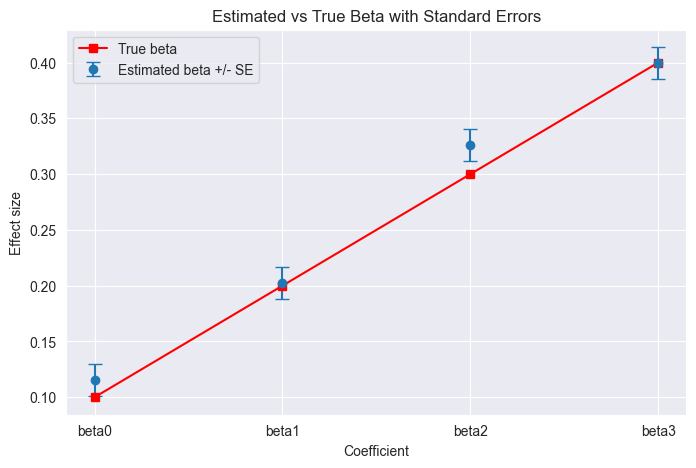

In [29]:
indices = np.arange(len(beta_true))

plt.figure(figsize=(8, 5))
plt.errorbar(indices, beta_hat, yerr=beta_se, fmt='o', label='Estimated beta +/- SE', capsize=5)
plt.plot(indices, beta_true, 's-', color='red', label='True beta', markersize=6)

plt.xticks(indices, [f'beta{i}' for i in range(len(beta_true))])
plt.xlabel('Coefficient')
plt.ylabel('Effect size')
plt.title('Estimated vs True Beta with Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

## Linear models for genetics

**Objectives:**
- **Given \(N=500\) samples:**
    1. Generate age, sex, and one genotype.
    2. Generate a phenotype as a linear function of age and sex (null model).
- **Build a lrt_test function:**
    1. Function should take as input: phenotype, covariates (age and sex), and genotype vector.
    2. Returns should include: effect size (beta), standard error (se), and p-value.

#### Generate data

In [30]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
N = 500

# Generate random age between 20 and 80
age = np.random.randint(20, 80, (N, 1))

# Generate random sex (0 = male, 1 = female)
sex = np.random.randint(0, 2, (N, 1))

# Generate random genotype (0, 1, or 2) using binomial with 2 trials and specified allele frequency
maf = 0.3 # minor allele frequency
genotype = np.random.binomial(2, maf, (N, 1))

# Generate phenotype
variance_age = 0.10
variance_sex = 0.10
variance_genotype = 0.
variance_noise = 1 - variance_age - variance_sex - variance_genotype
phenotype = np.sqrt(variance_age) * StandardScaler().fit_transform(age)
phenotype+= np.sqrt(variance_sex) * StandardScaler().fit_transform(sex)
phenotype+= np.sqrt(variance_genotype) * StandardScaler().fit_transform(genotype)
phenotype+= np.sqrt(variance_noise) * np.random.normal(0, 1, (N, 1))

In [31]:
# final data
F = np.column_stack((np.ones(N), age, sex))
g = genotype
y = phenotype

In [51]:
def lrt_test(y, F, g):
    """
    Conducts a likelihood ratio test for a given genotype and set of covariates.

    Parameters:
    - y: observed data (phenotype)
    - F: design matrix for null model (covariates without genotype)
    - g: genotype data

    Returns:
    - beta_geno: Effect size of genotype under the alternative model
    - beta_se_geno: Standard error of the effect size of genotype under the alternative model
    - p_value: p-value from the likelihood ratio test
    """

    # null model
    beta_null, beta_se_null, sigma2_null, llh_null = compute_MLE_and_LML(y, F)

    # alternative model
    X_alt = np.column_stack((F, g))
    beta_alt, beta_se_alt, sigma2_alt, llh_alt = compute_MLE_and_LML(y, X_alt)

    # genotype effect and standard err
    beta_geno = beta_alt[-1]
    beta_se_geno = beta_se_alt[-1]

    # likelihood ratio test
    D = 2 * (llh_alt - llh_null)
    p_value = 1 - st.chi2.cdf(D, df=1)

    beta_geno = np.array(beta_geno).flatten()
    beta_se_geno = np.array(beta_se_geno).flatten()
    if isinstance(p_value, np.ndarray):
        p_value = float(p_value.flatten()[0])


    return beta_geno[0], beta_se_geno[0], p_value

In [52]:
# Call the lrt_test function
beta_geno, beta_se_geno, p_value = lrt_test(y, F, g)
print(f"Effect size of genotype: {beta_geno:.4f}")
print(f"Standard error: {beta_se_geno:.4f}")
print(f"P-value: {p_value:.4f}")

[[-1.13126771]
 [ 0.0176478 ]
 [ 0.69117861]] [[0.78671824]] [[0.12921075 0.0022912  0.07936329]] [[-649.49798907]]
[[-1.13138475e+00]
 [ 1.76471583e-02]
 [ 6.91171292e-01]
 [ 2.67523852e-04]] [[0.78671821]] [[0.13201635 0.002296   0.07938132 0.06187848]] [[-649.49797973]]
Effect size of genotype: 0.0003
Standard error: 0.1320
P-value: 0.9966


#### Questions:
* Complete lrt_test
* Explain simulation strategy line by line
* What happens to beta, standard errors adn P values if you increase sample size? Why?
#### Answer:
* beta becomes closer to true population value
* standard error increases
* p-value should decrease as test becomes more sensitive

## Assessing the Distribution of P-values Under the Null

To understand the behavior of our statistical test under the null hypothesis, we will simulate data where the true genetic effect is zero and evaluate the distribution of resulting p-values from the likelihood ratio test. This helps in verifying whether our test maintains the desired type I error rate.

### Steps:

1. **Loop Over Simulations**:
   - We'll perform this process for 10,000 iterations to ensure a robust assessment of the p-value distribution.
   
2. **Generate a Random Genetic Variant**:
   - In each iteration, simulate a genetic variant to be tested.
   
3. **Simulate Phenotype Under the Null**:
   - Use the `simulate_phenotype` function to generate phenotypic values. Ensure the genetic variance (`variance_genotype`) is set to zero to simulate data under the null hypothesis.
   
4. **Perform the Likelihood Ratio Test**:
   - For each simulated dataset, apply the `lrt_test` function to obtain a p-value. This p-value indicates the significance of the genetic variant's association with the phenotype in the context of the given covariates.
   
5. **Collect and Analyze P-values**:
   - Store the p-values from each iteration in a list.
   - Plot a histogram to visualize the distribution of these p-values.
   - Create a QQ (quantile-quantile) plot to compare the distribution of our p-values to what we'd expect under the null hypothesis. A QQ plot helps in identifying systematic deviations from the expected uniform distribution of p-values under the null.

By the end of this analysis, we aim to validate that when there's truly no genetic effect, our test yields a uniform distribution of p-values, thereby maintaining the nominal type I error rate.


In [53]:
def simulate_phenotype(g, variance_genotype, N):
    """
    Simulates a phenotype based on a genetic variant.

    Parameters:
    - g: Genetic variant
    - variance_genotype: Variance explained by the genetic variant
    - N: Number of samples

    Returns:
    - phenotype: Simulated phenotype
    """

    # Ensure that g has the right shape
    if len(g.shape) == 1:
        g = g.reshape((N, 1))

    # Calculate variance due to noise
    variance_noise = 1 - variance_genotype

    # Generate phenotype
    phenotype = np.sqrt(variance_genotype) * StandardScaler().fit_transform(g)
    phenotype += np.sqrt(variance_noise) * np.random.normal(0, 1, (N, 1))

    return phenotype

In [54]:
# Parameters
N = 500
iterations = 10000
maf = 0.3

In [55]:
# Initializing list for p-values
p_values = []

# Progress loop
for sim_index in tqdm(range(iterations)):
    # Generate random genetic variant (0, 1, or 2)
    geno_probs = [(1 - maf) ** 2, 2 * maf * (1 - maf), maf ** 2]
    genotype = np.random.choice([0, 1, 2], size=N, p=geno_probs)

    # Simulate phenotype under the null
    phenotype = simulate_phenotype(genotype, variance_genotype=0, N=N)

    # Generate random covariates (intercept only)
    intercept = np.ones((N, 1))

    # Perform the likelihood ratio test and store the p-value
    _, _, p_value = lrt_test(phenotype, intercept, genotype)
    p_values.append(p_value)



  0%|          | 30/10000 [00:00<01:04, 155.63it/s]

[[-0.00098897]] [[0.93939317]] [[0.04334497]] [[-693.83897247]]
[[-0.08184506]
 [ 0.13704423]] [[0.93199529]] [[0.05925579 0.06879056]] [[-691.86238595]]
[[-0.00482015]] [[0.97893438]] [[0.04424781]] [[-704.14660029]]
[[ 0.07446812]
 [-0.12913399]] [[0.97178049]] [[0.06042768 0.06730827]] [[-702.3129326]]
[[-0.03025433]] [[0.99876465]] [[0.04469373]] [[-709.16023921]]
[[-0.04748678]
 [ 0.02991744]] [[0.99840285]] [[0.06029701 0.07028406]] [[-709.06966041]]
[[-0.03791158]] [[0.97259793]] [[0.04410437]] [[-702.52313908]]
[[-0.15246837]
 [ 0.1954894 ]] [[0.95568333]] [[0.05826069 0.06571497]] [[-698.13709963]]
[[-0.0718168]] [[0.93161525]] [[0.04316515]] [[-691.76042287]]
[[-0.08657143]
 [ 0.02426748]] [[0.93136888]] [[0.05923472 0.06672879]] [[-691.69430249]]
[[-0.0461467]] [[1.02565725]] [[0.04529144]] [[-715.80267404]]
[[-0.04743356]
 [ 0.00228166]] [[1.0256552]] [[0.06089204 0.07216398]] [[-715.8021742]]
[[-0.00828039]] [[1.12524597]] [[0.04743935]] [[-738.96968038]]
[[-0.02834282]
 [

  1%|          | 63/10000 [00:00<01:04, 155.22it/s]

[[-0.01857005]] [[0.93156847]] [[0.04316407]] [[-691.74787012]]
[[-0.11145087]
 [ 0.1584997 ]] [[0.92085126]] [[0.05765575 0.06570483]] [[-688.85507776]]
[[-0.04553914]] [[1.08900371]] [[0.04666913]] [[-730.78508012]]
[[-0.06975711]
 [ 0.04063419]] [[1.08828252]] [[0.06282248 0.07059151]] [[-730.61946333]]
[[0.08958083]] [[1.00190083]] [[0.04476384]] [[-709.94402421]]
[[0.08717538]
 [0.00424991]] [[1.00189372]] [[0.06028692 0.07134672]] [[-709.9422501]]
[[-0.03905401]] [[1.01993522]] [[0.04516492]] [[-714.40404491]]
[[-0.03947981]
 [ 0.00069348]] [[1.01993501]] [[0.06177287 0.06863653]] [[-714.40399387]]
[[-0.06069888]] [[1.00207345]] [[0.0447677]] [[-709.98709278]]
[[-0.01122855]
 [-0.08529367]] [[0.99878806]] [[0.05903884 0.06650812]] [[-709.16609708]]
[[0.01196276]] [[1.00810047]] [[0.04490213]] [[-711.48622693]]
[[ 0.04146438]
 [-0.04773726]] [[1.00707026]] [[0.0609568  0.06674814]] [[-711.23061299]]
[[0.01702509]] [[0.93656657]] [[0.04327971]] [[-693.08559637]]
[[ 0.02031688]
 [-0

  1%|          | 102/10000 [00:00<00:56, 175.18it/s]

[[0.10993659]] [[0.96173444]] [[0.04385737]] [[-699.71503797]]
[[ 0.14318223]
 [-0.0548608 ]] [[0.96049816]] [[0.06031938 0.06838598]] [[-699.39346405]]
[[0.00217484]] [[0.97485989]] [[0.04415563]] [[-703.10388741]]
[[ 0.01390564]
 [-0.01916797]] [[0.97471533]] [[0.06168597 0.07038916]] [[-703.06681266]]
[[0.04254503]] [[1.07231665]] [[0.04631019]] [[-726.92461799]]
[[0.01051879]
 [0.05618639]] [[1.07107567]] [[0.06255122 0.07381992]] [[-726.63512795]]
[[0.00109592]] [[1.00610676]] [[0.0448577]] [[-710.99131469]]
[[ 0.01155794]
 [-0.01773223]] [[1.00598668]] [[0.06201514 0.07258323]] [[-710.96147472]]
[[-0.00732244]] [[1.04192984]] [[0.04564931]] [[-719.73791902]]
[[-0.02782456]
 [ 0.03486756]] [[1.04143594]] [[0.06209267 0.07160303]] [[-719.61938381]]
[[0.0419029]] [[1.05367654]] [[0.04590592]] [[-722.54064508]]
[[0.02952119]
 [0.02036465]] [[1.05349807]] [[0.0625854 0.0699726]] [[-722.49829724]]
[[-0.0115111]] [[0.98226246]] [[0.04432296]] [[-704.99508163]]
[[-0.06121817]
 [ 0.080693

  1%|▏         | 142/10000 [00:00<00:52, 188.34it/s]

[[-0.04023216]] [[0.99468939]] [[0.04460245]] [[-708.13807669]]
[[-0.06950743]
 [ 0.05209122]] [[0.993609]] [[0.059696   0.07064739]] [[-707.86638848]]
[[-0.00421358]] [[0.99560195]] [[0.04462291]] [[-708.36733027]]
[[ 0.00689405]
 [-0.01990615]] [[0.99545509]] [[0.06052631 0.07329123]] [[-708.33044879]]
[[0.01058732]] [[0.97369687]] [[0.04412928]] [[-702.80545582]]
[[-0.00246252]
 [ 0.0224224 ]] [[0.97348406]] [[0.05920319 0.06782153]] [[-702.75081068]]
[[-0.01781251]] [[0.99904283]] [[0.04469995]] [[-709.22985945]]
[[-0.02811835]
 [ 0.01723385]] [[0.99890965]] [[0.05992593 0.06674938]] [[-709.19653131]]
[[-0.01177361]] [[0.97489159]] [[0.04415635]] [[-703.11201613]]
[[ 0.07565307]
 [-0.14426845]] [[0.96584268]] [[0.05969371 0.06665633]] [[-700.78068813]]
[[0.03777602]] [[1.0201284]] [[0.0451692]] [[-714.45139273]]
[[ 0.0866362 ]
 [-0.08693982]] [[1.0172701]] [[0.06110509 0.07334958]] [[-713.7499329]]
[[0.02714023]] [[0.99531622]] [[0.0446165]] [[-708.29557148]]
[[ 0.07071847]
 [-0.07

  2%|▏         | 183/10000 [00:01<00:50, 195.04it/s]

[[-0.01273599]] [[1.0896913]] [[0.04668386]] [[-730.94287864]]
[[-0.03453819]
 [ 0.03707858]] [[1.08917127]] [[0.06457129 0.07588749]] [[-730.82354247]]
[[0.06128889]] [[1.05963849]] [[0.04603561]] [[-723.95121642]]
[[-0.01766235]
 [ 0.1315854 ]] [[1.05236631]] [[0.06252031 0.07079031]] [[-722.22957977]]
[[0.01762618]] [[1.1124662]] [[0.04716919]] [[-736.11410363]]
[[-0.0373655 ]
 [ 0.09514133]] [[1.10902724]] [[0.06456415 0.07640861]] [[-735.34008515]]
[[-0.02313862]] [[1.05663722]] [[0.04597036]] [[-723.24212362]]
[[ 0.0660611 ]
 [-0.14480473]] [[1.04765133]] [[0.06285377 0.0699239 ]] [[-721.10697417]]
[[0.00338807]] [[0.99720267]] [[0.04465877]] [[-708.76895527]]
[[-0.01337061]
 [ 0.02811859]] [[0.9968763]] [[0.06090526 0.0694983 ]] [[-708.68712054]]
[[0.01966723]] [[0.94386884]] [[0.0434481]] [[-695.02725048]]
[[ 0.0256287 ]
 [-0.00955364]] [[0.9438299]] [[0.06008752 0.06651801]] [[-695.01693664]]
[[0.02047285]] [[0.94567627]] [[0.04348968]] [[-695.5055222]]
[[ 0.03649982]
 [-0.030

  2%|▏         | 226/10000 [00:01<00:48, 201.34it/s]

[[-0.04188689]] [[0.92234972]] [[0.04294996]] [[-689.26156008]]
[[ 0.00656262]
 [-0.07789311]] [[0.91970972]] [[0.05894864 0.06501864]] [[-688.54497166]]
[[-0.00753105]] [[0.95864309]] [[0.04378683]] [[-698.91015708]]
[[ 0.04144202]
 [-0.08189476]] [[0.95590408]] [[0.05988193 0.06841974]] [[-698.19484108]]
[[-0.03008522]] [[1.09103248]] [[0.04671258]] [[-731.25038534]]
[[-0.05753621]
 [ 0.04316194]] [[1.09024351]] [[0.06529248 0.07175431]] [[-731.06953519]]
[[0.03822514]] [[0.9967238]] [[0.04464804]] [[-708.64887081]]
[[0.00417295]
 [0.0595318 ]] [[0.99531747]] [[0.06026574 0.07082739]] [[-708.29588365]]
[[-0.01847254]] [[0.99822235]] [[0.04468159]] [[-709.0244596]]
[[ 0.00308273]
 [-0.03703655]] [[0.99766369]] [[0.06045498 0.0699943 ]] [[-708.88450597]]
[[0.0214924]] [[0.98428282]] [[0.04436852]] [[-705.50876557]]
[[0.01367495]
 [0.01307265]] [[0.98420756]] [[0.05972252 0.06685543]] [[-705.48964911]]
[[0.01279992]] [[1.011197]] [[0.04497104]] [[-712.25296173]]
[[-0.04139368]
 [ 0.0826

  3%|▎         | 272/10000 [00:01<00:49, 194.94it/s]

[[ 0.11738288]
 [-0.18919628]] [[0.99677167]] [[0.06209143 0.06959454]] [[-708.66087951]]
[[0.02191344]] [[0.99506472]] [[0.04461087]] [[-708.23239236]]
[[0.00886815]
 [0.02304821]] [[0.99484074]] [[0.05917262 0.068694  ]] [[-708.17611187]]
[[-0.02501024]] [[0.97119063]] [[0.04407245]] [[-702.16114048]]
[[-0.028395  ]
 [ 0.00606589]] [[0.97117685]] [[0.05963778 0.07200446]] [[-702.15759204]]
[[-0.00116132]] [[0.91589513]] [[0.04279942]] [[-687.50591566]]
[[ 0.00780707]
 [-0.01405704]] [[0.91581788]] [[0.06114445 0.06844719]] [[-687.484828]]
[[-0.05701038]] [[0.98280514]] [[0.0443352]] [[-705.13316334]]
[[-0.05679372]
 [-0.00035058]] [[0.98280508]] [[0.06139935 0.06873254]] [[-705.13315033]]
[[-0.09273145]] [[0.83451275]] [[0.04085371]] [[-664.24245123]]
[[ 0.0077755 ]
 [-0.15704211]] [[0.82449002]] [[0.0575408  0.06369874]] [[-661.22170592]]
[[-0.01118203]] [[0.9838169]] [[0.04435802]] [[-705.39039862]]
[[-0.04160878]
 [ 0.0489176 ]] [[0.98287142]] [[0.06237412 0.07053441]] [[-705.1500

  3%|▎         | 316/10000 [00:01<00:47, 204.84it/s]

[[0.04186866]] [[0.99065024]] [[0.0445118]] [[-707.1208301]]
[[ 0.06380315]
 [-0.03959293]] [[0.99001209]] [[0.0589308  0.06974181]] [[-706.95973629]]
[[-0.02364012]] [[1.1014254]] [[0.04693454]] [[-733.62055642]]
[[-0.05827118]
 [ 0.05479598]] [[1.10011454]] [[0.06490933 0.07099112]] [[-733.32284144]]
[[-0.01467846]] [[1.12384651]] [[0.04740984]] [[-738.65856234]]
[[ 0.01166895]
 [-0.04405921]] [[1.12302266]] [[0.06433199 0.07274843]] [[-738.47523089]]
[[-0.05697767]] [[1.01272831]] [[0.04500507]] [[-712.63126343]]
[[-0.05561185]
 [-0.0023878 ]] [[1.01272596]] [[0.06025576 0.0700459 ]] [[-712.6306824]]
[[0.00353048]] [[1.05848899]] [[0.04601063]] [[-723.67987018]]
[[-0.05242632]
 [ 0.09203421]] [[1.05467452]] [[0.06197447 0.06843935]] [[-722.77731731]]
[[-0.02916612]] [[0.92617465]] [[0.04303893]] [[-690.29615342]]
[[-0.17168256]
 [ 0.23832181]] [[0.90320606]] [[0.05834216 0.06683516]] [[-684.0181267]]
[[-0.01324412]] [[0.98708593]] [[0.04443165]] [[-706.21972123]]
[[-0.02934024]
 [ 0

  4%|▎         | 363/10000 [00:01<00:44, 218.29it/s]

[[-0.00399868]] [[1.03344444]] [[0.04546305]] [[-717.69360054]]
[[ 0.00701535]
 [-0.01939089]] [[1.033289]] [[0.06065857 0.07070551]] [[-717.6559972]]
[[0.07006852]] [[0.99388522]] [[0.04458442]] [[-707.93587905]]
[[0.06684658]
 [0.00571265]] [[0.99387263]] [[0.0602181  0.07176963]] [[-707.93271123]]
[[-0.11589197]] [[0.94420617]] [[0.04345587]] [[-695.1165818]]
[[-0.07036381]
 [-0.07876844]] [[0.94140227]] [[0.0572249  0.06454666]] [[-694.37308164]]
[[-0.03585187]] [[0.96045606]] [[0.04382821]] [[-699.38250626]]
[[-0.01766696]
 [-0.03000811]] [[0.96006817]] [[0.05964139 0.06676461]] [[-699.28151893]]
[[0.00683325]] [[1.17571145]] [[0.04849147]] [[-749.93763076]]
[[ 0.02462146]
 [-0.03004766]] [[1.1753092]] [[0.06480465 0.07263562]] [[-749.8520812]]
[[-0.06825705]] [[0.89984935]] [[0.04242286]] [[-683.08728714]]
[[-0.0709541 ]
 [ 0.00466618]] [[0.89984056]] [[0.057343   0.06675015]] [[-683.08484379]]
[[0.09329591]] [[0.9712575]] [[0.04407397]] [[-702.1783521]]
[[-0.04628058]
 [ 0.22956

  4%|▍         | 411/10000 [00:02<00:41, 228.50it/s]

[[0.0068025]] [[0.94678335]] [[0.04351513]] [[-695.79802024]]
[[-0.04681167]
 [ 0.08456494]] [[0.94369371]] [[0.06036005 0.06609469]] [[-694.98085921]]
[[-0.01891533]] [[1.05231031]] [[0.04587614]] [[-722.21627649]]
[[ 0.00996672]
 [-0.04895262]] [[1.05133763]] [[0.06249744 0.07197416]] [[-721.98508713]]
[[-0.05284649]] [[0.94345372]] [[0.04343855]] [[-694.91727374]]
[[-0.0764109 ]
 [ 0.03813011]] [[0.94288949]] [[0.06116914 0.0697087 ]] [[-694.76771833]]
[[-0.06031988]] [[0.90941485]] [[0.04264774]] [[-685.73078897]]
[[-0.11199986]
 [ 0.08024842]] [[0.90672775]] [[0.06013255 0.06592467]] [[-684.99100602]]
[[0.01298305]] [[0.94436345]] [[0.04345949]] [[-695.15822167]]
[[-0.00053577]
 [ 0.02485076]] [[0.94411885]] [[0.05743792 0.06904713]] [[-695.0934624]]
[[0.03475521]] [[0.95584708]] [[0.04372292]] [[-698.17993123]]
[[0.00899158]
 [0.0453585 ]] [[0.95502129]] [[0.05869689 0.0689836 ]] [[-697.96385449]]
[[-0.04355993]] [[1.12861635]] [[0.04751034]] [[-739.71737047]]
[[-0.0125717 ]
 [-0

  5%|▍         | 460/10000 [00:02<00:40, 236.70it/s]

[[0.03277887]] [[1.02524798]] [[0.0452824]] [[-715.70289577]]
[[0.02650925]
 [0.01088476]] [[1.02519725]] [[0.06032398 0.06919635]] [[-715.69052402]]
[[-0.03898309]] [[0.92472526]] [[0.04300524]] [[-689.90461691]]
[[ 0.0324734 ]
 [-0.11562539]] [[0.91894874]] [[0.05884272 0.06521997]] [[-688.33803237]]
[[-0.02561327]] [[1.00419581]] [[0.04481508]] [[-710.51602517]]
[[ 0.01040341]
 [-0.06125286]] [[1.00253651]] [[0.05977111 0.06733304]] [[-710.10259023]]
[[0.06546022]] [[0.97070899]] [[0.04406152]] [[-702.0371276]]
[[0.02275422]
 [0.07287713]] [[0.96842202]] [[0.05900364 0.06706691]] [[-701.44743769]]
[[0.0141139]] [[0.93574128]] [[0.04326064]] [[-692.86520375]]
[[-0.10059423]
 [ 0.18561187]] [[0.92126892]] [[0.05931048 0.0662284 ]] [[-688.96844199]]
[[-0.00260911]] [[0.96208361]] [[0.04386533]] [[-699.80578801]]
[[ 0.04737518]
 [-0.07713624]] [[0.95963164]] [[0.06224862 0.06824457]] [[-699.1678234]]
[[0.03917661]] [[0.94450844]] [[0.04346282]] [[-695.19660175]]
[[0.0214873 ]
 [0.030289

  5%|▌         | 507/10000 [00:02<00:41, 226.91it/s]

[[0.03113565]] [[0.93047601]] [[0.04313875]] [[-691.45451936]]
[[ 0.09225449]
 [-0.10836673]] [[0.92575631]] [[0.05759283 0.0678738 ]] [[-690.1832052]]
[[-0.00740025]] [[1.01707293]] [[0.04510151]] [[-713.70147265]]
[[-0.10095973]
 [ 0.14482892]] [[1.0079133]] [[0.06278731 0.06794272]] [[-711.43980518]]
[[-0.04401215]] [[1.01022718]] [[0.04494946]] [[-712.01307598]]
[[-0.0295429]
 [-0.0231879]] [[1.01000425]] [[0.06258603 0.06979903]] [[-711.9579005]]
[[-0.00285543]] [[0.9577706]] [[0.0437669]] [[-698.68251871]]
[[-0.01070916]
 [ 0.01262659]] [[0.95770378]] [[0.06069194 0.06760261]] [[-698.66507656]]
[[0.02884918]] [[1.0425157]] [[0.04566214]] [[-719.87845126]]
[[ 0.09749178]
 [-0.11035787]] [[1.0375575]] [[0.06361686 0.07139405]] [[-718.68661394]]
[[-0.00489418]] [[1.00713073]] [[0.04488052]] [[-711.24562263]]
[[-0.00255771]
 [-0.00362806]] [[1.00712487]] [[0.06237307 0.06725861]] [[-711.24416776]]
[[-0.04693628]] [[0.94148932]] [[0.0433933]] [[-694.39619835]]
[[-0.03335943]
 [-0.0239

  6%|▌         | 553/10000 [00:02<00:42, 220.47it/s]

[[0.04785266]] [[1.08712892]] [[0.04662894]] [[-730.35431686]]
[[0.02337446]
 [0.04107081]] [[1.08639889]] [[0.06289805 0.07085558]] [[-730.18638134]]
[[-0.04385856]] [[0.91468504]] [[0.04277114]] [[-687.17539249]]
[[-0.04908564]
 [ 0.00982534]] [[0.91464671]] [[0.05597757 0.06788277]] [[-687.16491791]]
[[0.00661305]] [[1.01938309]] [[0.0451527]] [[-714.26867434]]
[[ 0.0493023 ]
 [-0.07360215]] [[1.01702332]] [[0.06004062 0.06833395]] [[-713.68927944]]
[[-0.07153629]] [[1.01694719]] [[0.04509872]] [[-713.67056309]]
[[-0.14241301]
 [ 0.12478296]] [[1.01044831]] [[0.05985827 0.06958383]] [[-712.06779359]]
[[-0.03651634]] [[0.92681727]] [[0.04305386]] [[-690.46955381]]
[[-0.02605975]
 [-0.01908137]] [[0.92667757]] [[0.0574796  0.06950014]] [[-690.4318674]]
[[0.00581875]] [[0.98166159]] [[0.0443094]] [[-704.84210494]]
[[-0.0024266 ]
 [ 0.01329895]] [[0.98158667]] [[0.06119374 0.06807715]] [[-704.82302463]]
[[-0.03384173]] [[0.95194283]] [[0.04363354]] [[-697.15669085]]
[[-0.00968808]
 [-0.

  6%|▌         | 600/10000 [00:02<00:41, 225.66it/s]

[[0.05136138]] [[1.02449447]] [[0.04526576]] [[-715.51908882]]
[[ 0.08906099]
 [-0.06262394]] [[1.02297441]] [[0.06291995 0.0726537 ]] [[-715.14788471]]
[[-0.00447612]] [[0.97551576]] [[0.04417048]] [[-703.27202505]]
[[-0.03120144]
 [ 0.04296676]] [[0.97471986]] [[0.06081833 0.06724466]] [[-703.06797239]]
[[-0.06072144]] [[0.9412485]] [[0.04338775]] [[-694.33224322]]
[[-0.01978534]
 [-0.07310018]] [[0.93907685]] [[0.05768395 0.06798118]] [[-693.75477544]]
[[-0.07384419]] [[1.0433567]] [[0.04568056]] [[-720.08004427]]
[[-0.08671771]
 [ 0.02096664]] [[1.0431769]] [[0.06332008 0.0714217 ]] [[-720.0369589]]
[[-0.05649178]] [[0.97067303]] [[0.04406071]] [[-702.02786528]]
[[-0.08961482]
 [ 0.05893779]] [[0.96910934]] [[0.0574294  0.06561753]] [[-701.62480703]]
[[-0.03152935]] [[1.03443651]] [[0.04548487]] [[-717.9334768]]
[[-0.01060338]
 [-0.03570985]] [[1.0338517]] [[0.06013293 0.06714678]] [[-717.79210175]]
[[-0.06891627]] [[1.07361236]] [[0.04633816]] [[-727.2265159]]
[[-0.06817663]
 [-0.

  6%|▋         | 648/10000 [00:03<00:40, 229.39it/s]

[[0.00570552]] [[0.98457271]] [[0.04437505]] [[-705.58238453]]
[[-0.00369718]
 [ 0.01536388]] [[0.98447134]] [[0.06071349 0.06771068]] [[-705.55664295]]
[[-0.00728492]] [[1.015924]] [[0.04507602]] [[-713.41890143]]
[[-0.04869338]
 [ 0.06370532]] [[1.01409164]] [[0.06265856 0.06702313]] [[-712.96758626]]
[[-0.01249884]] [[0.93956769]] [[0.043349]] [[-693.88541385]]
[[-0.0426898 ]
 [ 0.04792217]] [[0.93857306]] [[0.05997828 0.06583471]] [[-693.62062297]]
[[0.01404256]] [[1.10951856]] [[0.04710666]] [[-735.45081415]]
[[-0.00101629]
 [ 0.02484958]] [[1.10926244]] [[0.06467479 0.07313607]] [[-735.39309835]]
[[-0.00503534]] [[1.03940247]] [[0.04559391]] [[-719.13076712]]
[[ 0.00779632]
 [-0.02204752]] [[1.03921422]] [[0.06242026 0.07325837]] [[-719.08548406]]
[[0.03265644]] [[1.06305189]] [[0.04610969]] [[-724.75524521]]
[[-0.04554846]
 [ 0.12695601]] [[1.05627364]] [[0.06339317 0.07087572]] [[-723.15608569]]
[[-0.01773084]] [[0.97200104]] [[0.04409084]] [[-702.36966613]]
[[ 0.03550576]
 [-0

  7%|▋         | 694/10000 [00:03<00:41, 223.77it/s]

[[0.00595406]] [[0.97178525]] [[0.04408594]] [[-702.31415898]]
[[ 0.04941742]
 [-0.08231697]] [[0.96912079]] [[0.05755367 0.07020828]] [[-701.62776149]]
[[0.00115465]] [[1.07245603]] [[0.0463132]] [[-726.95711054]]
[[ 0.01963493]
 [-0.02905705]] [[1.07208158]] [[0.0640292  0.06953127]] [[-726.86980599]]
[[-0.00912386]] [[1.01809025]] [[0.04512406]] [[-713.95140773]]
[[-0.03273925]
 [ 0.03858724]] [[1.01747462]] [[0.06227665 0.07015557]] [[-713.80019029]]
[[0.02600236]] [[1.06468989]] [[0.0461452]] [[-725.14016035]]
[[ 0.07953464]
 [-0.09293798]] [[1.06102567]] [[0.0614952 0.0707262]] [[-724.27828009]]
[[-0.09198081]] [[0.93067368]] [[0.04314334]] [[-691.50762502]]
[[-0.05973142]
 [-0.05218348]] [[0.9296278]] [[0.06089412 0.06957624]] [[-691.22651913]]
[[0.03320285]] [[1.00609475]] [[0.04485744]] [[-710.98832848]]
[[0.00563551]
 [0.04640966]] [[1.00525654]] [[0.06191403 0.07187653]] [[-710.77996024]]
[[-0.06855818]] [[0.98512427]] [[0.04438748]] [[-705.7223969]]
[[-0.05676416]
 [-0.0208

  7%|▋         | 741/10000 [00:03<00:42, 219.60it/s]

[[-0.03899098]] [[0.97319931]] [[0.04411801]] [[-702.67767215]]
[[-0.08740727]
 [ 0.08150892]] [[0.9703215]] [[0.05934142 0.06693398]] [[-701.93731076]]
[[-0.03730869]] [[0.96806389]] [[0.04400145]] [[-701.35496991]]
[[-0.068801  ]
 [ 0.05355834]] [[0.96695592]] [[0.06053914 0.07075884]] [[-701.06867464]]
[[0.01419959]] [[1.02506768]] [[0.04527842]] [[-715.65892771]]
[[-0.03447963]
 [ 0.07558884]] [[1.02266072]] [[0.06370987 0.06967927]] [[-715.07121158]]
[[-0.02599485]] [[0.91874483]] [[0.04286595]] [[-688.28255271]]
[[ 0.02508988]
 [-0.08717531]] [[0.91571563]] [[0.05838838 0.06778358]] [[-687.45691273]]
[[-0.06745842]] [[0.96503252]] [[0.04393251]] [[-700.57089742]]
[[-0.05389814]
 [-0.02112194]] [[0.96484076]] [[0.06148193 0.06700256]] [[-700.52121401]]
[[0.02134642]] [[1.00986176]] [[0.04494133]] [[-711.92262918]]
[[ 0.05299097]
 [-0.05630702]] [[1.00857405]] [[0.05988128 0.07047295]] [[-711.60364209]]
[[-0.01272387]] [[1.2060959]] [[0.04911407]] [[-756.31642067]]
[[ 0.05263957]
 

  8%|▊         | 791/10000 [00:03<00:39, 232.30it/s]

[[-0.03803373]] [[1.0117163]] [[0.04498258]] [[-712.38131473]]
[[-0.07030593]
 [ 0.05804352]] [[1.01034555]] [[0.05963234 0.07047342]] [[-712.04236721]]
[[-0.10266934]] [[1.01667894]] [[0.04509277]] [[-713.60461025]]
[[-0.08663491]
 [-0.02654706]] [[1.0163807]] [[0.06152359 0.06930724]] [[-713.53126332]]
[[-0.01559019]] [[0.94532802]] [[0.04348167]] [[-695.41344212]]
[[-0.03912519]
 [ 0.03795968]] [[0.94468882]] [[0.05938528 0.06526249]] [[-695.24434318]]
[[0.04719591]] [[1.06360302]] [[0.04612164]] [[-724.88482164]]
[[ 0.11707324]
 [-0.10619655]] [[1.0588547]] [[0.06553941 0.07092079]] [[-723.76622961]]
[[0.06481331]] [[0.95650479]] [[0.04373796]] [[-698.35189632]]
[[ 0.14031844]
 [-0.1254238 ]] [[0.94965237]] [[0.05898707 0.06603214]] [[-696.55444586]]
[[-0.00087156]] [[0.91409691]] [[0.04275738]] [[-687.01459583]]
[[-0.0477229 ]
 [ 0.07731244]] [[0.91159387]] [[0.05849817 0.06598284]] [[-686.32909]]
[[0.06065017]] [[0.82789437]] [[0.04069138]] [[-662.25184165]]
[[ 0.06329168]
 [-0.0

  8%|▊         | 840/10000 [00:03<00:38, 235.04it/s]

[[0.01390974]] [[1.0265567]] [[0.04531129]] [[-716.02181566]]
[[ 0.08240419]
 [-0.10537609]] [[1.02212061]] [[0.06485502 0.0715332 ]] [[-714.93914084]]
[[-0.04871109]] [[0.96877845]] [[0.04401769]] [[-701.53943395]]
[[ 0.0073861 ]
 [-0.09773029]] [[0.96491476]] [[0.0591746  0.06906966]] [[-700.54038745]]
[[0.07363403]] [[1.05865099]] [[0.04601415]] [[-723.71812713]]
[[0.03674741]
 [0.06294646]] [[1.05715086]] [[0.06349792 0.07472929]] [[-723.36362169]]
[[0.10060631]] [[1.07456724]] [[0.04635876]] [[-727.44877069]]
[[ 0.13869228]
 [-0.06499312]] [[1.07279902]] [[0.06249568 0.07159332]] [[-727.0370506]]
[[-0.0311147]] [[0.95465838]] [[0.04369573]] [[-697.86883697]]
[[-0.05286383]
 [ 0.03686294]] [[0.9541503]] [[0.06070357 0.07144069]] [[-697.73574771]]
[[0.01990465]] [[1.02746139]] [[0.04533126]] [[-716.24203874]]
[[ 0.05576989]
 [-0.05803436]] [[1.02601963]] [[0.06231246 0.06923607]] [[-715.89098734]]
[[-0.04625149]] [[0.91527836]] [[0.04278501]] [[-687.33750654]]
[[-0.03029602]
 [-0.02

  9%|▉         | 889/10000 [00:04<00:38, 234.11it/s]

[[-0.04986809]] [[0.93728894]] [[0.0432964]] [[-693.278346]]
[[-0.00468426]
 [-0.07658276]] [[0.93502566]] [[0.05963997 0.06961284]] [[-692.67394086]]
[[0.00835803]] [[1.12527761]] [[0.04744002]] [[-738.97670962]]
[[ 0.08180344]
 [-0.12448376]] [[1.1189877]] [[0.06447685 0.07425371]] [[-737.57537653]]
[[-0.0260277]] [[0.95500355]] [[0.04370363]] [[-697.9592113]]
[[-0.00375546]
 [-0.03490948]] [[0.95447836]] [[0.06092613 0.06655514]] [[-697.82168867]]
[[-0.01200918]] [[1.0758997]] [[0.04638749]] [[-727.75857672]]
[[-0.07128737]
 [ 0.10047151]] [[1.0716812]] [[0.06267957 0.07161626]] [[-726.77642347]]
[[0.03183677]] [[1.13488777]] [[0.04764216]] [[-741.10270854]]
[[-0.05233577]
 [ 0.13532563]] [[1.12706599]] [[0.0655434  0.07264684]] [[-739.37371257]]
[[-0.05254982]] [[1.01926168]] [[0.04515001]] [[-714.23889638]]
[[-0.12662685]
 [ 0.12064662]] [[1.01307549]] [[0.06183389 0.06904614]] [[-712.71695139]]
[[0.05854086]] [[1.03585035]] [[0.04551594]] [[-718.27493671]]
[[0.03966267]
 [0.03323

  9%|▉         | 937/10000 [00:04<00:38, 233.73it/s]

[[0.0167962]] [[1.01247465]] [[0.04499944]] [[-712.56863694]]
[[-0.01928215]
 [ 0.05637241]] [[1.01113233]] [[0.06311298 0.06919218]] [[-712.23697085]]
[[-0.04711119]] [[0.94678304]] [[0.04351512]] [[-695.79793849]]
[[-0.05658038]
 [ 0.01673002]] [[0.94667846]] [[0.05930168 0.0711848 ]] [[-695.77032227]]
[[0.01627277]] [[0.95911825]] [[0.04379768]] [[-699.03404118]]
[[0.01190051]
 [0.00702936]] [[0.95909675]] [[0.06019766 0.06639627]] [[-699.02843704]]
[[-0.05189066]] [[1.02734509]] [[0.04532869]] [[-716.21373857]]
[[-0.11886565]
 [ 0.11275252]] [[1.02188907]] [[0.06102512 0.06900892]] [[-714.88250205]]
[[0.04555096]] [[1.01221707]] [[0.04499371]] [[-712.50502827]]
[[ 0.05430572]
 [-0.01435205]] [[1.01212687]] [[0.06119099 0.06798999]] [[-712.48274963]]
[[-0.00986144]] [[1.01537074]] [[0.04506375]] [[-713.28271766]]
[[ 0.0076254 ]
 [-0.02749503]] [[1.01503546]] [[0.0623024  0.06765608]] [[-713.20015323]]
[[0.05437357]] [[0.98285469]] [[0.04433632]] [[-705.14576744]]
[[ 0.08435983]
 [-0

 10%|▉         | 986/10000 [00:04<00:37, 238.11it/s]

[[0.01947644]] [[0.94209567]] [[0.04340727]] [[-694.55715329]]
[[ 0.08305466]
 [-0.10321139]] [[0.93744534]] [[0.05919964 0.0655351 ]] [[-693.32006017]]
[[-0.0457636]] [[0.95735295]] [[0.04375735]] [[-698.57348049]]
[[-0.15893181]
 [ 0.19116252]] [[0.9415102]] [[0.05835431 0.06590448]] [[-694.4017419]]
[[-0.03741608]] [[1.07981826]] [[0.04647189]] [[-728.66745373]]
[[-0.04127718]
 [ 0.00588582]] [[1.07980171]] [[0.06407206 0.0672397 ]] [[-728.66362258]]
[[0.02626104]] [[1.11746839]] [[0.04727512]] [[-737.23570768]]
[[0.00190699]
 [0.03966458]] [[1.11679974]] [[0.06492221 0.07249468]] [[-737.08607262]]
[[0.05955477]] [[0.97210508]] [[0.0440932]] [[-702.39642312]]
[[ 0.09925978]
 [-0.06362983]] [[0.97024822]] [[0.05989988 0.06504711]] [[-701.91843161]]
[[-0.03925119]] [[0.93793786]] [[0.04331138]] [[-693.45137056]]
[[ 0.02476491]
 [-0.10924249]] [[0.93289453]] [[0.0581539  0.06644533]] [[-692.10348516]]
[[-0.02380776]] [[0.9156268]] [[0.04279315]] [[-687.43266188]]
[[-0.04292013]
 [ 0.03

 10%|█         | 1034/10000 [00:04<00:39, 226.10it/s]

[[0.01586009]] [[0.98665069]] [[0.04442186]] [[-706.10946323]]
[[0.01039436]
 [0.0088157 ]] [[0.98661932]] [[0.06206937 0.06992206]] [[-706.10151541]]
[[0.00367673]] [[1.01948835]] [[0.04515503]] [[-714.29448845]]
[[ 0.0273222 ]
 [-0.04105116]] [[1.01883412]] [[0.06147405 0.07244786]] [[-714.13400492]]
[[-0.07754093]] [[0.94036664]] [[0.04336742]] [[-694.09790839]]
[[ 0.03849398]
 [-0.18775876]] [[0.92555756]] [[0.05944837 0.06638237]] [[-690.12952708]]
[[-0.00819861]] [[0.98782222]] [[0.04444822]] [[-706.40613179]]
[[ 0.06174628]
 [-0.11245159]] [[0.98257293]] [[0.0616169  0.06880384]] [[-705.07408834]]
[[-0.01468378]] [[0.93222201]] [[0.04317921]] [[-691.92319429]]
[[-0.03190003]
 [ 0.02759014]] [[0.93188507]] [[0.05918891 0.06489014]] [[-691.83282063]]
[[-0.0577043]] [[1.05498632]] [[0.04593444]] [[-722.85121673]]
[[-0.06980854]
 [ 0.02131029]] [[1.05478043]] [[0.06008937 0.06821294]] [[-722.80242203]]
[[0.06784314]] [[1.01112756]] [[0.04496949]] [[-712.23579195]]
[[0.01501358]
 [0.

 11%|█         | 1082/10000 [00:05<00:38, 231.48it/s]

[[-0.03634184]] [[1.04686029]] [[0.04575719]] [[-720.91813876]]
[[-0.08581934]
 [ 0.08218854]] [[1.04399892]] [[0.06224441 0.0702084 ]] [[-720.23388085]]
[[-0.09876517]] [[0.93538332]] [[0.04325236]] [[-692.76954964]]
[[-0.08178382]
 [-0.03098786]] [[0.93501103]] [[0.05760656 0.06945087]] [[-692.67002942]]
[[0.06924502]] [[1.02091367]] [[0.04518658]] [[-714.64376305]]
[[0.03036047]
 [0.06291998]] [[1.01926646]] [[0.06252792 0.06999589]] [[-714.2400699]]
[[-0.01523513]] [[1.07915005]] [[0.04645751]] [[-728.51270097]]
[[ 0.01477436]
 [-0.04871671]] [[1.07815196]] [[0.06404633 0.07160598]] [[-728.28137392]]
[[0.07255073]] [[1.07693749]] [[0.04640986]] [[-727.99960598]]
[[ 0.08147993]
 [-0.01449545]] [[1.07684745]] [[0.06372356 0.07089153]] [[-727.97870213]]
[[0.04769332]] [[0.96899155]] [[0.04402253]] [[-701.59441845]]
[[ 0.10969629]
 [-0.11439662]] [[0.96412025]] [[0.05873656 0.0719733 ]] [[-700.33445273]]
[[-0.03847521]] [[1.02267733]] [[0.0452256]] [[-715.07527139]]
[[-0.04159643]
 [ 0

 11%|█▏        | 1131/10000 [00:05<00:37, 236.83it/s]

[[0.01200214]] [[0.96254431]] [[0.04387583]] [[-699.92547239]]
[[-0.03114849]
 [ 0.07543817]] [[0.96035435]] [[0.05961344 0.0706487 ]] [[-699.35603079]]
[[-0.12727496]] [[0.91577935]] [[0.04279671]] [[-687.47431055]]
[[-0.12322035]
 [-0.00658215]] [[0.91576096]] [[0.05889423 0.06568175]] [[-687.46928929]]
[[0.00576517]] [[1.13641604]] [[0.04767423]] [[-741.43913761]]
[[ 0.03497182]
 [-0.04650741]] [[1.13541759]] [[0.06489172 0.07013784]] [[-741.21939274]]
[[-0.01363534]] [[1.02948946]] [[0.04537597]] [[-716.73501894]]
[[-0.06470089]
 [ 0.08131457]] [[1.02654302]] [[0.06221038 0.06787709]] [[-716.01848329]]
[[0.04127568]] [[1.04263619]] [[0.04566478]] [[-719.90734263]]
[[0.02266506]
 [0.03347234]] [[1.04218482]] [[0.06069433 0.07192968]] [[-719.79909166]]
[[0.0015012]] [[0.93012563]] [[0.04313063]] [[-691.36036304]]
[[ 0.01500599]
 [-0.02192336]] [[0.9299235]] [[0.05948095 0.06650172]] [[-691.3060291]]
[[0.01896651]] [[0.96828084]] [[0.04400638]] [[-701.41098881]]
[[ 0.06655706]
 [-0.08

 12%|█▏        | 1181/10000 [00:05<00:36, 240.49it/s]

[[0.00103134]] [[0.88842786]] [[0.04215277]] [[-679.89380878]]
[[-0.00211557]
 [ 0.00510862]] [[0.88841719]] [[0.05854195 0.06594837]] [[-679.89080848]]
[[-0.06602087]] [[1.03403559]] [[0.04547605]] [[-717.83656501]]
[[-0.02045585]
 [-0.07938157]] [[1.03141089]] [[0.06078274 0.07037377]] [[-717.20118179]]
[[-0.075938]] [[0.92861637]] [[0.04309562]] [[-690.95437237]]
[[-0.04895023]
 [-0.04637075]] [[0.92775783]] [[0.05856308 0.06817038]] [[-690.72313077]]
[[-0.00567785]] [[0.97896701]] [[0.04424855]] [[-704.15493173]]
[[-0.03341461]
 [ 0.04832189]] [[0.97805046]] [[0.05998341 0.07059314]] [[-703.92076273]]
[[0.03187235]] [[0.95405294]] [[0.04368187]] [[-697.71023683]]
[[ 3.19171913e-02]
 [-7.37506438e-05]] [[0.95405294]] [[0.06050837 0.06886631]] [[-697.71023626]]
[[-0.04085806]] [[1.11255956]] [[0.04717117]] [[-736.13508408]]
[[-0.03811406]
 [-0.00483098]] [[1.11255019]] [[0.06335318 0.0744559 ]] [[-736.13297914]]
[[0.00326977]] [[0.95157976]] [[0.04362522]] [[-697.06132382]]
[[ 0.0191

 12%|█▏        | 1232/10000 [00:05<00:35, 245.36it/s]

[[0.04622313]] [[1.08435547]] [[0.04656942]] [[-729.71571114]]
[[0.03485773]
 [0.01809778]] [[1.08421083]] [[0.06406969 0.0700728 ]] [[-729.68236138]]
[[-0.07366891]] [[0.94872321]] [[0.04355969]] [[-696.30971934]]
[[-0.06553865]
 [-0.01387415]] [[0.9486434]] [[0.0588958  0.06764719]] [[-696.28868809]]
[[0.00093339]] [[0.9533582]] [[0.04366596]] [[-697.52812083]]
[[ 0.07312628]
 [-0.11606575]] [[0.94760441]] [[0.06009908 0.06661248]] [[-696.01472765]]
[[0.01486106]] [[1.05185889]] [[0.0458663]] [[-722.10900972]]
[[ 0.01782583]
 [-0.00492487]] [[1.05184784]] [[0.06145796 0.06795188]] [[-722.10638336]]
[[-0.05253935]] [[1.008552]] [[0.04491218]] [[-711.59817618]]
[[-0.06486573]
 [ 0.02061267]] [[1.00836998]] [[0.0608294  0.06861234]] [[-711.55305351]]
[[-0.01480031]] [[1.08773031]] [[0.04664183]] [[-730.49257614]]
[[ 0.0002295 ]
 [-0.02432009]] [[1.08748894]] [[0.0648889  0.07300572]] [[-730.43709592]]
[[-0.0375341]] [[0.99825076]] [[0.04468223]] [[-709.03157267]]
[[-0.02031683]
 [-0.028

 13%|█▎        | 1283/10000 [00:05<00:35, 248.88it/s]

[[0.00674993]] [[0.9100304]] [[0.04266217]] [[-685.89994859]]
[[ 0.01664541]
 [-0.01606409]] [[0.90992394]] [[0.05910783 0.06641748]] [[-685.87070088]]
[[0.05825045]] [[1.07995788]] [[0.04647489]] [[-728.69977716]]
[[ 0.12836793]
 [-0.1153248 ]] [[1.07466009]] [[0.06437339 0.07345575]] [[-727.47037055]]
[[-0.00589029]] [[1.06418423]] [[0.04613424]] [[-725.02139722]]
[[-0.0497914 ]
 [ 0.06651684]] [[1.06228878]] [[0.06545886 0.07042252]] [[-724.57571751]]
[[-0.09371871]] [[1.02859922]] [[0.04535635]] [[-716.5187399]]
[[-0.11889609]
 [ 0.04267353]] [[1.02782364]] [[0.06112107 0.06947371]] [[-716.33016568]]
[[0.02526514]] [[1.0009663]] [[0.04474296]] [[-709.71072556]]
[[ 0.02898767]
 [-0.00630938]] [[1.00095078]] [[0.06155636 0.07165471]] [[-709.70684897]]
[[0.00926077]] [[0.95818948]] [[0.04377647]] [[-698.79183344]]
[[ 0.02875744]
 [-0.03249445]] [[0.9577629]] [[0.06018663 0.06885783]] [[-698.68051042]]
[[-0.06197335]] [[1.06397287]] [[0.04612966]] [[-724.97174051]]
[[-0.09287393]
 [ 0.

 13%|█▎        | 1334/10000 [00:06<00:35, 246.78it/s]

[[0.03942526]] [[0.968164]] [[0.04400373]] [[-701.38081939]]
[[ 0.07107577]
 [-0.05310487]] [[0.96690965]] [[0.05897641 0.06593764]] [[-701.05671089]]
[[0.01420365]] [[0.93077007]] [[0.04314557]] [[-691.53351613]]
[[-0.02429484]
 [ 0.07347039]] [[0.92860323]] [[0.05592446 0.06801872]] [[-690.95083409]]
[[0.03130356]] [[1.00534034]] [[0.04484061]] [[-710.80080057]]
[[ 0.03391699]
 [-0.00437029]] [[1.0053327]] [[0.06169637 0.0708639 ]] [[-710.79889889]]
[[-0.03262607]] [[0.88294624]] [[0.04202252]] [[-678.34652664]]
[[-0.07136193]
 [ 0.0620767 ]] [[0.88131765]] [[0.05819453 0.06458091]] [[-677.88497747]]
[[-0.00343721]] [[0.88526396]] [[0.04207764]] [[-679.00191109]]
[[-0.05641688]
 [ 0.08685192]] [[0.88211163]] [[0.05775029 0.06497415]] [[-678.11010005]]
[[0.03713399]] [[0.98883005]] [[0.04447089]] [[-706.66106501]]
[[-0.01267445]
 [ 0.08926244]] [[0.98584503]] [[0.06008646 0.07254618]] [[-705.90523921]]
[[0.06898298]] [[0.97860373]] [[0.04424034]] [[-704.06214447]]
[[0.04535446]
 [0.03

 14%|█▍        | 1385/10000 [00:06<00:34, 248.34it/s]

[[-0.00236637]] [[1.02542148]] [[0.04528623]] [[-715.74519772]]
[[-0.02220991]
 [ 0.03568981]] [[1.02487775]] [[0.05944908 0.0692957 ]] [[-715.61260161]]
[[0.12177627]] [[0.9429204]] [[0.04342627]] [[-694.77591275]]
[[ 0.13808214]
 [-0.02782571]] [[0.94260867]] [[0.05910321 0.06842923]] [[-694.69325048]]
[[0.04621668]] [[1.10733426]] [[0.04706026]] [[-734.95815579]]
[[ 0.10916918]
 [-0.10891436]] [[1.10273267]] [[0.06406928 0.07540172]] [[-733.91710203]]
[[-0.00083432]] [[1.01581961]] [[0.04507371]] [[-713.39321238]]
[[ 0.01631659]
 [-0.02877669]] [[1.01546453]] [[0.06093771 0.06882213]] [[-713.30581073]]
[[0.04761362]] [[0.96191461]] [[0.04386148]] [[-699.76186829]]
[[-0.00328606]
 [ 0.08156999]] [[0.95904938]] [[0.06043566 0.06674003]] [[-699.01608932]]
[[0.04648087]] [[0.97000295]] [[0.0440455]] [[-701.85522399]]
[[ 0.05673509]
 [-0.01643305]] [[0.9698845]] [[0.06051234 0.0665011 ]] [[-701.8246943]]
[[0.03431364]] [[1.00939119]] [[0.04493086]] [[-711.8061085]]
[[0.00982316]
 [0.0395

 14%|█▍        | 1435/10000 [00:06<00:35, 238.56it/s]

[[0.01572932]] [[0.9079003]] [[0.04261221]] [[-685.31408949]]
[[-0.0204897 ]
 [ 0.06331996]] [[0.90621307]] [[0.05675901 0.06562722]] [[-684.84906136]]
[[0.01523788]] [[1.08958277]] [[0.04668153]] [[-730.91797852]]
[[ 0.05283993]
 [-0.06643473]] [[1.08779244]] [[0.06239989 0.07323446]] [[-730.50685514]]
[[0.01747981]] [[1.04258051]] [[0.04566356]] [[-719.89399114]]
[[ 0.02788357]
 [-0.01739759]] [[1.04245932]] [[0.06282526 0.07216053]] [[-719.86492928]]
[[0.01873602]] [[1.00292833]] [[0.04478679]] [[-710.20027848]]
[[ 0.05831445]
 [-0.06968034]] [[1.00086298]] [[0.05932894 0.06859869]] [[-709.68491791]]
[[-0.07270839]] [[0.95947882]] [[0.04380591]] [[-699.12800826]]
[[-0.18027362]
 [ 0.19416106]] [[0.94398157]] [[0.05742403 0.06776906]] [[-695.05710688]]
[[0.00523063]] [[1.01325983]] [[0.04501688]] [[-712.76243967]]
[[-0.05054069]
 [ 0.08909157]] [[1.00987756]] [[0.06226701 0.06884642]] [[-711.92653977]]
[[-0.01190747]] [[0.92429043]] [[0.04299513]] [[-689.78703204]]
[[-0.00926726]
 [-

 15%|█▍        | 1485/10000 [00:06<00:35, 241.66it/s]

[[0.01940612]] [[1.04333898]] [[0.04568017]] [[-720.07579755]]
[[0.00053815]
 [0.03134215]] [[1.04294251]] [[0.06291963 0.07189054]] [[-719.98078049]]
[[-0.02758249]] [[0.91779308]] [[0.04284374]] [[-688.02343684]]
[[-0.08071155]
 [ 0.08173701]] [[0.91474991]] [[0.05938397 0.06337559]] [[-687.19312327]]
[[-0.01035661]] [[1.01797283]] [[0.04512145]] [[-713.92257311]]
[[-0.00142174]
 [-0.01479283]] [[1.01788548]] [[0.06242012 0.0714131 ]] [[-713.9011196]]
[[-0.00234198]] [[1.05400828]] [[0.04591314]] [[-722.61934286]]
[[ 0.00799683]
 [-0.02003647]] [[1.05384378]] [[0.05896851 0.07172108]] [[-722.58032309]]
[[-0.03096865]] [[0.98138924]] [[0.04430326]] [[-704.77273581]]
[[-0.05243219]
 [ 0.0343967 ]] [[0.98087975]] [[0.06111963 0.06749534]] [[-704.6429153]]
[[0.015909]] [[0.98077015]] [[0.04428928]] [[-704.61497964]]
[[ 0.02817281]
 [-0.01959074]] [[0.98060507]] [[0.0612211 0.0675251]] [[-704.57289685]]
[[-0.05684525]] [[1.03073097]] [[0.04540333]] [[-717.03632498]]
[[-0.07374241]
 [ 0.02

 15%|█▌        | 1510/10000 [00:06<00:37, 228.61it/s]

[[-0.05508985]] [[1.07199397]] [[0.04630322]] [[-726.8493764]]
[[-0.04655786]
 [-0.01556933]] [[1.07189902]] [[0.06154183 0.07398052]] [[-726.82723241]]
[[0.00436863]] [[1.05528663]] [[0.04594098]] [[-722.92237154]]
[[ 0.0157595 ]
 [-0.02078626]] [[1.05510875]] [[0.0604109  0.07159378]] [[-722.88022757]]
[[-0.00702735]] [[0.97599549]] [[0.04418134]] [[-703.39493775]]
[[ 0.03800711]
 [-0.07928602]] [[0.97367349]] [[0.06040048 0.07260848]] [[-702.79945219]]
[[0.02951129]] [[1.07306955]] [[0.04632644]] [[-727.10008607]]
[[ 0.11064986]
 [-0.13941335]] [[1.06523144]] [[0.06260914 0.07268349]] [[-725.26728966]]
[[-0.03202192]] [[0.97670411]] [[0.04419738]] [[-703.57638544]]
[[-0.05270675]
 [ 0.0360363 ]] [[0.9761736]] [[0.05938789 0.06913051]] [[-703.44055633]]
[[0.11441918]] [[1.08145381]] [[0.04650707]] [[-729.04582964]]
[[0.10019681]
 [0.0236252 ]] [[1.08122184]] [[0.06362481 0.07213345]] [[-728.9922005]]
[[0.02575673]] [[0.99468959]] [[0.04460246]] [[-708.13812684]]
[[ 0.07899849]
 [-0.0

 16%|█▌        | 1559/10000 [00:07<00:36, 232.33it/s]

[[-0.01485014]] [[1.01080816]] [[0.04496239]] [[-712.15680984]]
[[ 0.06903553]
 [-0.14169876]] [[1.00202308]] [[0.06007725 0.06767791]] [[-709.97452574]]
[[-0.03624145]] [[0.98085772]] [[0.04429126]] [[-704.63729957]]
[[-0.06239779]
 [ 0.04403423]] [[0.98002556]] [[0.05976204 0.0675806 ]] [[-704.42511076]]
[[0.04794566]] [[0.98721877]] [[0.04443464]] [[-706.25336339]]
[[0.04180997]
 [0.01026036]] [[0.98717367]] [[0.06018667 0.06788738]] [[-706.24194232]]
[[0.00801953]] [[1.02290773]] [[0.04523069]] [[-715.13158774]]
[[-0.0139457 ]
 [ 0.03722921]] [[1.02231188]] [[0.06082929 0.06896409]] [[-714.98591944]]
[[-0.02490598]] [[0.98107416]] [[0.04429614]] [[-704.6924601]]
[[-0.01225854]
 [-0.02107907]] [[0.98088932]] [[0.06049357 0.06867178]] [[-704.6453542]]
[[0.0388704]] [[1.03886489]] [[0.04558212]] [[-719.00143281]]
[[-0.01741609]
 [ 0.09381083]] [[1.03513349]] [[0.06187116 0.06987636]] [[-718.10186505]]
[[0.07848307]] [[0.97223168]] [[0.04409607]] [[-702.42897935]]
[[ 0.12033482]
 [-0.0

 16%|█▌        | 1610/10000 [00:07<00:34, 239.93it/s]

[[0.14215994]] [[1.0713857]] [[0.04629008]] [[-726.70748016]]
[[0.12037365]
 [0.03717797]] [[1.07077946]] [[0.06179198 0.06987611]] [[-726.56597866]]
[[0.00854643]] [[1.12300021]] [[0.04739199]] [[-738.47023213]]
[[-0.02141278]
 [ 0.04895296]] [[1.12196148]] [[0.0646751  0.07195011]] [[-738.23888507]]
[[-0.03192053]] [[1.02554668]] [[0.045289]] [[-715.77572133]]
[[-0.07688046]
 [ 0.07419131]] [[1.02310955]] [[0.06118323 0.06798137]] [[-715.18090968]]
[[-0.00298097]] [[0.98399521]] [[0.04436204]] [[-705.43570388]]
[[ 0.0231704 ]
 [-0.04204401]] [[0.98323313]] [[0.06108335 0.06753769]] [[-705.24200922]]
[[-0.03001368]] [[0.91017397]] [[0.04266554]] [[-685.93938671]]
[[ 0.0038457 ]
 [-0.05738877]] [[0.9089162]] [[0.05894725 0.06899253]] [[-685.59367085]]
[[-0.02012365]] [[1.09779003]] [[0.04685702]] [[-732.79404076]]
[[-0.03959097]
 [ 0.03201862]] [[1.09735296]] [[0.06401308 0.07174839]] [[-732.69448545]]
[[-0.04807151]] [[1.00832005]] [[0.04490702]] [[-711.54067416]]
[[-0.0255972 ]
 [-0.

 17%|█▋        | 1661/10000 [00:07<00:34, 244.04it/s]

[[0.00588364]] [[1.10761636]] [[0.04706626]] [[-735.02183713]]
[[ 0.01255555]
 [-0.01119447]] [[1.10756363]] [[0.06391468 0.0725554 ]] [[-735.00993493]]
[[0.04513197]] [[1.07299691]] [[0.04632487]] [[-727.0831627]]
[[0.00883736]
 [0.05989209]] [[1.07150913]] [[0.06356467 0.07188072]] [[-726.73627984]]
[[-0.03728201]] [[1.04748736]] [[0.04577089]] [[-721.06784194]]
[[-0.0186772 ]
 [-0.03287069]] [[1.04707067]] [[0.06191731 0.0736902 ]] [[-720.9683743]]
[[-0.0494886]] [[0.98402537]] [[0.04436272]] [[-705.44336581]]
[[-0.05741191]
 [ 0.0146728 ]] [[0.98393916]] [[0.05831834 0.0701055 ]] [[-705.42146436]]
[[-0.02829154]] [[0.99882193]] [[0.04469501]] [[-709.17457641]]
[[-0.0658044 ]
 [ 0.06921191]] [[0.99682804]] [[0.05831556 0.06920784]] [[-708.67501702]]
[[0.01138078]] [[0.97337563]] [[0.044122]] [[-702.72296188]]
[[ 0.0686233 ]
 [-0.09702123]] [[0.96985606]] [[0.06120114 0.07202627]] [[-701.81736505]]
[[-0.02182195]] [[0.99153178]] [[0.0445316]] [[-707.3431971]]
[[-0.02371729]
 [ 0.0030

 17%|█▋        | 1738/10000 [00:07<00:33, 249.28it/s]

[[-0.04219635]] [[1.00495915]] [[0.04483211]] [[-710.70599011]]
[[ 0.09108918]
 [-0.20825864]] [[0.98577153]] [[0.0616191  0.06675681]] [[-705.88659951]]
[[0.03637711]] [[1.02592595]] [[0.04529737]] [[-715.86815947]]
[[0.02749961]
 [0.01460115]] [[1.02583506]] [[0.06189197 0.06937097]] [[-715.8460097]]
[[-0.00479932]] [[1.08765241]] [[0.04664016]] [[-730.47467161]]
[[ 0.07603644]
 [-0.14181713]] [[1.0791832]] [[0.06183571 0.0715929 ]] [[-728.52038214]]
[[0.02705719]] [[0.91818486]] [[0.04285288]] [[-688.13013251]]
[[ 0.05474442]
 [-0.04538889]] [[0.91730744]] [[0.05863003 0.06563245]] [[-687.89111803]]
[[0.06297311]] [[1.05661979]] [[0.04596999]] [[-723.23800062]]
[[ 0.11184691]
 [-0.0742763 ]] [[1.05431902]] [[0.0655577  0.07110731]] [[-722.69303565]]
[[0.07416592]] [[1.13651397]] [[0.04767628]] [[-741.46068016]]
[[ 0.11456832]
 [-0.07138234]] [[1.13438589]] [[0.06331702 0.07370421]] [[-740.99212582]]
[[-0.07965083]] [[0.99225038]] [[0.04454774]] [[-707.52431527]]
[[ 0.01802822]
 [-0.

 18%|█▊        | 1788/10000 [00:07<00:33, 246.54it/s]

[[0.02123754]] [[0.90334528]] [[0.04250518]] [[-684.05665837]]
[[ 0.09654774]
 [-0.12678485]] [[0.8969611]] [[0.05820328 0.06720736]] [[-682.28357169]]
[[0.01846682]] [[0.86096146]] [[0.04149606]] [[-672.04288088]]
[[0.00242572]
 [0.02437857]] [[0.86069696]] [[0.05827601 0.06219315]] [[-671.96606787]]
[[0.03284729]] [[1.09360387]] [[0.04676759]] [[-731.83890181]]
[[ 0.0460422 ]
 [-0.02107812]] [[1.09341099]] [[0.06450447 0.07097409]] [[-731.79480614]]
[[-0.01579053]] [[0.94393298]] [[0.04344958]] [[-695.04423888]]
[[-0.02118182]
 [ 0.00929533]] [[0.94389603]] [[0.0580771  0.06644438]] [[-695.03445356]]
[[-0.04863481]] [[1.06750484]] [[0.04620617]] [[-725.80026714]]
[[-0.01429428]
 [-0.05840226]] [[1.06607824]] [[0.06240726 0.07139839]] [[-725.46594737]]
[[-0.00329418]] [[1.02698253]] [[0.04532069]] [[-716.1254967]]
[[-3.32519135e-03]
 [ 5.20402410e-05]] [[1.02698253]] [[0.06210001 0.07123359]] [[-716.12549643]]
[[0.05658965]] [[0.98731684]] [[0.04443685]] [[-706.27819667]]
[[0.00799513

 18%|█▊        | 1839/10000 [00:08<00:32, 248.48it/s]

[[0.01842745]] [[1.05975562]] [[0.04603815]] [[-723.97884951]]
[[ 0.04090707]
 [-0.03943793]] [[1.05913177]] [[0.06192015 0.07267142]] [[-723.83163755]]
[[0.01337564]] [[0.95337285]] [[0.0436663]] [[-697.53196443]]
[[ 0.03259979]
 [-0.03003774]] [[0.95295565]] [[0.05995159 0.06420109]] [[-697.42253741]]
[[-0.0756123]] [[1.00597591]] [[0.04485479]] [[-710.95879861]]
[[-0.04138098]
 [-0.06005494]] [[1.00455816]] [[0.06057776 0.07149094]] [[-710.60621739]]
[[0.05124948]] [[0.95141114]] [[0.04362135]] [[-697.01702109]]
[[0.02585847]
 [0.04231836]] [[0.95070913]] [[0.06039552 0.06964594]] [[-696.83248733]]
[[-6.45368366e-05]] [[0.91103701]] [[0.04268576]] [[-686.17632826]]
[[ 0.04853917]
 [-0.07789056]] [[0.90844871]] [[0.05895052 0.06525932]] [[-685.46505482]]
[[0.02770806]] [[0.91637929]] [[0.04281073]] [[-687.63803366]]
[[ 0.08210571]
 [-0.09219941]] [[0.91275883]] [[0.0575983  0.06546953]] [[-686.64836919]]
[[0.06125979]] [[0.9736734]] [[0.04412875]] [[-702.79943005]]
[[0.05521272]
 [0.

 19%|█▊        | 1864/10000 [00:08<00:34, 232.47it/s]

[[0.02991637]] [[0.99492257]] [[0.04460768]] [[-708.19667663]]
[[ 0.07612388]
 [-0.0742886 ]] [[0.99256541]] [[0.06150832 0.06817445]] [[-707.60367495]]
[[0.01062229]] [[1.02445251]] [[0.04526483]] [[-715.50884875]]
[[-0.03008015]
 [ 0.06993546]] [[1.02253879]] [[0.06176959 0.07229584]] [[-715.04140198]]
[[0.02400558]] [[1.00843874]] [[0.04490966]] [[-711.57010099]]
[[ 0.07121703]
 [-0.08168071]] [[1.00582398]] [[0.06104468 0.07164395]] [[-710.92103904]]
[[0.0084727]] [[0.9530594]] [[0.04365912]] [[-697.44975487]]
[[ 0.04613638]
 [-0.0663093 ]] [[0.95122423]] [[0.05807759 0.06751383]] [[-696.96790155]]
[[-0.04156659]] [[0.95002502]] [[0.04358956]] [[-696.65252772]]
[[-0.05003604]
 [ 0.01361648]] [[0.94994286]] [[0.05965462 0.06547945]] [[-696.63090696]]
[[-5.73620207e-05]] [[0.90469129]] [[0.04253684]] [[-684.4288879]]
[[ 0.0464344 ]
 [-0.07697311]] [[0.90213658]] [[0.05771336 0.06468742]] [[-683.72192894]]
[[0.02349988]] [[1.03200344]] [[0.04543134]] [[-717.34476669]]
[[ 0.02830636]
 

 19%|█▉        | 1912/10000 [00:08<00:36, 219.71it/s]

[[-0.00083004]] [[1.11190439]] [[0.04715728]] [[-735.98782037]]
[[-0.0304721 ]
 [ 0.04765605]] [[1.11093437]] [[0.06507265 0.07212508]] [[-735.76962573]]
[[0.02100912]] [[1.01477049]] [[0.04505043]] [[-713.13488385]]
[[0.0159664 ]
 [0.00787925]] [[1.01474302]] [[0.06251803 0.06773069]] [[-713.12811736]]
[[-0.04130923]] [[0.92654012]] [[0.04304742]] [[-690.39478467]]
[[-0.04026467]
 [-0.00188549]] [[0.92653862]] [[0.05654509 0.06618102]] [[-690.39437883]]
[[0.02125501]] [[0.98666336]] [[0.04442214]] [[-706.11267316]]
[[ 0.0374874 ]
 [-0.02798688]] [[0.98633783]] [[0.05974465 0.06889538]] [[-706.03017824]]
[[-0.06455003]] [[0.94677315]] [[0.0435149]] [[-695.79532778]]
[[-0.07847307]
 [ 0.02459901]] [[0.94652285]] [[0.05795824 0.0676499 ]] [[-695.72922593]]
[[-0.04690217]] [[1.03591066]] [[0.04551726]] [[-718.28949266]]
[[-0.01125389]
 [-0.06083325]] [[1.03433193]] [[0.06110516 0.06963579]] [[-717.90820236]]
[[0.00648278]] [[0.90139436]] [[0.04245926]] [[-683.51615986]]
[[-0.03075759]
 [ 

 20%|█▉        | 1961/10000 [00:08<00:35, 229.34it/s]

[[0.02336512]] [[0.92639939]] [[0.04304415]] [[-690.3568085]]
[[ 0.04124471]
 [-0.030202  ]] [[0.92601853]] [[0.05836581 0.06660056]] [[-690.25400769]]
[[-0.0647985]] [[0.94109041]] [[0.04338411]] [[-694.29025159]]
[[-0.06138294]
 [-0.00575011]] [[0.94107623]] [[0.05856244 0.06622405]] [[-694.28648206]]
[[-0.04746344]] [[0.95157405]] [[0.04362509]] [[-697.05982395]]
[[-0.04307341]
 [-0.00685943]] [[0.95155361]] [[0.06080761 0.06618914]] [[-697.05445403]]
[[0.02088984]] [[1.02773878]] [[0.04533737]] [[-716.30952321]]
[[ 0.08207434]
 [-0.1077192 ]] [[1.02322068]] [[0.06117234 0.07249617]] [[-715.20806249]]
[[-0.09519088]] [[0.98974235]] [[0.0444914]] [[-706.89161021]]
[[-0.05937606]
 [-0.05613609]] [[0.98829606]] [[0.06107057 0.06562556]] [[-706.52602326]]
[[-0.01221652]] [[0.90959508]] [[0.04265197]] [[-685.78033021]]
[[-0.06420372]
 [ 0.08494641]] [[0.90638072]] [[0.05776634 0.06379225]] [[-684.89530579]]
[[-0.05772508]] [[0.99377213]] [[0.04458188]] [[-707.90743044]]
[[-0.08312577]
 [

 20%|██        | 2008/10000 [00:08<00:35, 222.32it/s]

[[0.05707847]] [[1.16684296]] [[0.04830824]] [[-748.0447108]]
[[0.02548893]
 [0.05247432]] [[1.16574265]] [[0.06667811 0.07638459]] [[-747.80885463]]
[[-0.04268789]] [[0.98590683]] [[0.04440511]] [[-705.92091103]]
[[-4.27283747e-02]
 [ 6.74768907e-05]] [[0.98590683]] [[0.06064809 0.0688472 ]] [[-705.92091055]]
[[0.01940375]] [[0.95108761]] [[0.04361393]] [[-696.93199133]]
[[-0.01464715]
 [ 0.05222531]] [[0.94990143]] [[0.06129299 0.06609393]] [[-696.62000333]]
[[0.01794647]] [[1.0129426]] [[0.04500983]] [[-712.68415764]]
[[ 0.08668251]
 [-0.11610818]] [[1.00715198]] [[0.06047975 0.06847984]] [[-711.25089863]]
[[0.02076569]] [[0.96652398]] [[0.04396644]] [[-700.95697455]]
[[0.01273987]
 [0.01238553]] [[0.96645892]] [[0.06202201 0.06751101]] [[-700.94014644]]
[[-0.02026059]] [[1.04816098]] [[0.04578561]] [[-721.22856276]]
[[ 0.02254343]
 [-0.0673019 ]] [[1.04622458]] [[0.06381445 0.06996122]] [[-720.76627928]]
[[-0.06599861]] [[0.96063947]] [[0.0438324]] [[-699.43024003]]
[[-0.13544771]


 21%|██        | 2056/10000 [00:09<00:35, 222.09it/s]

[[-0.07000696]] [[0.9666258]] [[0.04396876]] [[-700.98330863]]
[[-0.1152597 ]
 [ 0.07418482]] [[0.96419385]] [[0.05960015 0.06605948]] [[-700.35353773]]
[[0.04212565]] [[1.05532931]] [[0.0459419]] [[-722.93248123]]
[[ 0.05900256]
 [-0.02841231]] [[1.05501515]] [[0.06342785 0.07363394]] [[-722.85804879]]
[[-0.09231519]] [[0.93437697]] [[0.04322909]] [[-692.50043693]]
[[-0.09392969]
 [ 0.0026819 ]] [[0.93437403]] [[0.05941632 0.06771119]] [[-692.49965254]]
[[0.0141224]] [[1.01524252]] [[0.0450609]] [[-713.25114591]]
[[-0.04204277]
 [ 0.09683649]] [[1.01198297]] [[0.06310878 0.07630653]] [[-712.44720116]]
[[0.01245305]] [[1.07686745]] [[0.04640835]] [[-727.98334573]]
[[-0.05057349]
 [ 0.10132883]] [[1.07244095]] [[0.06379421 0.07053499]] [[-726.95359498]]
[[-0.01936981]] [[1.07718539]] [[0.0464152]] [[-728.0571466]]
[[-0.04303869]
 [ 0.04011675]] [[1.07653215]] [[0.06324186 0.07283145]] [[-727.90549334]]
[[0.00378792]] [[1.01749938]] [[0.04511096]] [[-713.80627375]]
[[ 0.01196351]
 [-0.01

 21%|██        | 2104/10000 [00:09<00:34, 230.91it/s]

[[0.0546218]] [[0.89362872]] [[0.04227597]] [[-681.3530427]]
[[ 0.05489662]
 [-0.00045349]] [[0.89362863]] [[0.05804922 0.06564369]] [[-681.35301884]]
[[-0.01250548]] [[1.04026793]] [[0.04561289]] [[-719.33884312]]
[[-0.02962995]
 [ 0.03171197]] [[1.03990147]] [[0.06118907 0.07554782]] [[-719.25075928]]
[[0.00656292]] [[1.03845223]] [[0.04557307]] [[-718.90210691]]
[[ 0.0221543 ]
 [-0.02651596]] [[1.03814128]] [[0.06082323 0.06851827]] [[-718.82723707]]
[[0.00347038]] [[1.03103635]] [[0.04541005]] [[-717.11038224]]
[[ 0.02428344]
 [-0.03651414]] [[1.03049624]] [[0.06094225 0.07132751]] [[-716.9793844]]
[[0.10068347]] [[1.00978363]] [[0.0449396]] [[-711.90328777]]
[[ 0.11278882]
 [-0.02225249]] [[1.0095994]] [[0.06021004 0.07366831]] [[-711.85767085]]
[[0.0513184]] [[1.01419867]] [[0.04503773]] [[-712.99396944]]
[[ 0.08164395]
 [-0.04382305]] [[1.01332844]] [[0.06456301 0.06687685]] [[-712.77936578]]
[[0.06354424]] [[1.04778982]] [[0.0457775]] [[-721.14001984]]
[[ 0.12459333]
 [-0.10525

 22%|██▏       | 2153/10000 [00:09<00:33, 234.38it/s]

[[0.02667042]] [[1.04227284]] [[0.04565683]] [[-719.82020406]]
[[0.01686607]
 [0.01684597]] [[1.04215612]] [[0.06165174 0.0711893 ]] [[-719.79220727]]
[[-0.06832643]] [[0.97850747]] [[0.04423816]] [[-704.03755268]]
[[-0.05258251]
 [-0.02598006]] [[0.97823022]] [[0.06087362 0.06901434]] [[-703.96670753]]
[[0.0129499]] [[1.000198]] [[0.04472579]] [[-709.51876269]]
[[ 0.03512381]
 [-0.03849638]] [[0.99956932]] [[0.05968769 0.06864736]] [[-709.36157243]]
[[0.00790567]] [[0.93751318]] [[0.04330157]] [[-693.3381504]]
[[-0.03500715]
 [ 0.06855083]] [[0.93556712]] [[0.06034688 0.06721826]] [[-692.8186695]]
[[-0.0205594]] [[0.96798434]] [[0.04399964]] [[-701.33442371]]
[[ 0.01352977]
 [-0.05817264]] [[0.96650008]] [[0.05870607 0.06638648]] [[-700.9507915]]
[[-0.04180917]] [[0.9764719]] [[0.04419212]] [[-703.51693971]]
[[-0.07317071]
 [ 0.05370128]] [[0.97533295]] [[0.0602924  0.07027869]] [[-703.2251712]]
[[-0.00586419]] [[0.91726435]] [[0.0428314]] [[-687.87937459]]
[[ 0.0363974 ]
 [-0.0713878

 22%|██▏       | 2203/10000 [00:09<00:32, 241.57it/s]

[[0.0705649]] [[0.96349091]] [[0.0438974]] [[-700.17121137]]
[[0.06626258]
 [0.00712304]] [[0.96347005]] [[0.0603041  0.06845671]] [[-700.16579804]]
[[-0.00277382]] [[1.12141709]] [[0.04735857]] [[-738.11755217]]
[[ 0.06426661]
 [-0.10574201]] [[1.11640734]] [[0.06508418 0.07059371]] [[-736.99821606]]
[[-0.00773956]] [[0.92537671]] [[0.04302038]] [[-690.08067395]]
[[ 0.05382737]
 [-0.10801215]] [[0.92041723]] [[0.05698919 0.06580544]] [[-688.73721583]]
[[-0.003727]] [[0.95810397]] [[0.04377451]] [[-698.76952212]]
[[-0.01968332]
 [ 0.02819138]] [[0.95778794]] [[0.05881183 0.06940687]] [[-698.68704641]]
[[0.00836548]] [[1.00122757]] [[0.0447488]] [[-709.77596982]]
[[ 0.0257263 ]
 [-0.02874309]] [[1.00086803]] [[0.06066133 0.06782143]] [[-709.68618045]]
[[0.04685543]] [[1.03459824]] [[0.04548842]] [[-717.97255993]]
[[0.03439339]
 [0.01935099]] [[1.0344345]] [[0.06349133 0.06878514]] [[-717.93299114]]
[[0.02598112]] [[1.06109491]] [[0.04606723]] [[-724.29459386]]
[[ 0.05081992]
 [-0.043424

 23%|██▎       | 2253/10000 [00:09<00:31, 242.24it/s]

[[0.05956087]] [[0.96084724]] [[0.04383714]] [[-699.48430703]]
[[0.04796054]
 [0.01993184]] [[0.96067432]] [[0.0584509  0.06643864]] [[-699.43930998]]
[[0.06896929]] [[0.94906808]] [[0.0435676]] [[-696.40058152]]
[[ 0.08402696]
 [-0.02509612]] [[0.94880104]] [[0.0592349 0.066899 ]] [[-696.33022847]]
[[0.01146587]] [[1.06143628]] [[0.04607464]] [[-724.37500942]]
[[ 0.02795339]
 [-0.02498108]] [[1.06114647]] [[0.06413245 0.06760154]] [[-724.30674096]]
[[-0.01626491]] [[1.05894922]] [[0.04602063]] [[-723.78854484]]
[[ 0.00934023]
 [-0.03975953]] [[1.05826431]] [[0.06436262 0.06989334]] [[-723.62679625]]
[[-0.04070093]] [[1.02974698]] [[0.04538165]] [[-716.7975477]]
[[-0.09134155]
 [ 0.08089556]] [[1.02695839]] [[0.06279139 0.0694262 ]] [[-716.11961969]]
[[0.03165582]] [[0.97360831]] [[0.04412728]] [[-702.78271516]]
[[ 0.09515781]
 [-0.11891758]] [[0.96805295]] [[0.05780552 0.07020281]] [[-701.35214239]]
[[0.02128416]] [[0.96857541]] [[0.04401308]] [[-701.48703163]]
[[-0.0130887 ]
 [ 0.059

 23%|██▎       | 2304/10000 [00:10<00:31, 245.47it/s]

[[-0.0134419]] [[0.93823026]] [[0.04331813]] [[-693.52929545]]
[[-0.12757975]
 [ 0.18291322]] [[0.92342128]] [[0.05891951 0.06459478]] [[-689.55183444]]
[[0.01654363]] [[1.01777692]] [[0.04511711]] [[-713.87445687]]
[[ 0.08407696]
 [-0.10585163]] [[1.01272416]] [[0.06207792 0.06701831]] [[-712.63023763]]
[[0.0865955]] [[1.01827388]] [[0.04512813]] [[-713.99649641]]
[[0.04979926]
 [0.06300727]] [[1.01662659]] [[0.0608642  0.07000047]] [[-713.59173628]]
[[-0.01465491]] [[0.99111146]] [[0.04452216]] [[-707.23719586]]
[[ 0.0620927 ]
 [-0.11991813]] [[0.98463454]] [[0.06132006 0.06612312]] [[-705.59808413]]
[[0.02872896]] [[1.15947701]] [[0.04815552]] [[-746.46152925]]
[[-0.01134387]
 [ 0.06656616]] [[1.15758231]] [[0.06540149 0.07358243]] [[-746.05267021]]
[[-0.00620937]] [[0.94210959]] [[0.04340759]] [[-694.56084867]]
[[ 0.0021238 ]
 [-0.01302057]] [[0.94203866]] [[0.06106167 0.06710479]] [[-694.54202491]]
[[-0.02997385]] [[1.11475286]] [[0.04721764]] [[-736.6274498]]
[[-0.04102106]
 [ 0.

 24%|██▎       | 2355/10000 [00:10<00:30, 247.56it/s]

[[0.08784723]] [[0.9377717]] [[0.04330754]] [[-693.40707924]]
[[ 0.11747701]
 [-0.0481003 ]] [[0.93672468]] [[0.0586884  0.06434141]] [[-693.12779801]]
[[0.02092103]] [[1.00874959]] [[0.04491658]] [[-711.64715097]]
[[-0.04068935]
 [ 0.10549723]] [[1.00359718]] [[0.05904165 0.06584616]] [[-710.36694842]]
[[0.01951219]] [[0.9001686]] [[0.04243038]] [[-683.17596751]]
[[0.00337682]
 [0.02671418]] [[0.89986945]] [[0.05801769 0.0655243 ]] [[-683.09287214]]
[[0.01812472]] [[0.94658259]] [[0.04351052]] [[-695.74500323]]
[[-0.03583847]
 [ 0.09054225]] [[0.94310025]] [[0.05885145 0.06663614]] [[-694.82359453]]
[[0.00523669]] [[0.9421632]] [[0.04340883]] [[-694.57507295]]
[[ 0.00855731]
 [-0.00520473]] [[0.94215033]] [[0.05915381 0.06298664]] [[-694.57165893]]
[[0.01337475]] [[1.03624619]] [[0.04552463]] [[-718.37045527]]
[[-0.00970386]
 [ 0.03965397]] [[1.03563723]] [[0.06231274 0.07313218]] [[-718.22349545]]
[[-0.05534901]] [[1.08941855]] [[0.04667802]] [[-730.88029433]]
[[-0.12872234]
 [ 0.121

 24%|██▍       | 2405/10000 [00:10<00:32, 235.44it/s]

[[-0.03780755]] [[1.04097934]] [[0.04562849]] [[-719.50975258]]
[[-0.01532751]
 [-0.03649356]] [[1.04041394]] [[0.06277472 0.07000946]] [[-719.37393031]]
[[-0.04762316]] [[0.94557138]] [[0.04348727]] [[-695.47779096]]
[[-0.13311415]
 [ 0.13833494]] [[0.93707329]] [[0.05904228 0.06496406]] [[-693.22082159]]
[[-0.02525543]] [[1.0357279]] [[0.04551325]] [[-718.24538153]]
[[-0.04446043]
 [ 0.03504563]] [[1.03527629]] [[0.06133197 0.07504101]] [[-718.13635164]]
[[-0.03694993]] [[0.93533314]] [[0.0432512]] [[-692.7561378]]
[[-0.04942126]
 [ 0.01960901]] [[0.93515953]] [[0.05954755 0.06436163]] [[-692.70973044]]
[[-0.03533833]] [[0.93573805]] [[0.04326056]] [[-692.86434168]]
[[-0.03303212]
 [-0.00358107]] [[0.9357325]] [[0.06052189 0.06572257]] [[-692.86285723]]
[[0.04350557]] [[1.04731232]] [[0.04576707]] [[-721.02606298]]
[[ 0.08909873]
 [-0.07548536]] [[1.04485541]] [[0.06211097 0.06961643]] [[-720.43889582]]
[[-0.03693114]] [[0.96421553]] [[0.04391391]] [[-700.35915973]]
[[-0.0041002 ]
 [

 25%|██▍       | 2454/10000 [00:10<00:31, 240.39it/s]

[[-0.01411033]] [[1.00608136]] [[0.04485714]] [[-710.98500259]]
[[-0.00322466]
 [-0.01706217]] [[1.00595823]] [[0.06283425 0.06896955]] [[-710.95440431]]
[[-0.05069718]] [[1.07895639]] [[0.04645334]] [[-728.46783339]]
[[-0.09137032]
 [ 0.06200175]] [[1.0773508]] [[0.0661421  0.07182573]] [[-728.09553224]]
[[-0.10226925]] [[0.98657298]] [[0.04442011]] [[-706.08977312]]
[[-0.09290572]
 [-0.01608855]] [[0.98646963]] [[0.06038769 0.07029432]] [[-706.06358282]]
[[0.02025188]] [[0.95957697]] [[0.04380815]] [[-699.15357872]]
[[0.01679105]
 [0.00596696]] [[0.95956188]] [[0.05867868 0.06730906]] [[-699.14964933]]
[[-0.00377344]] [[0.9366888]] [[0.04328253]] [[-693.11822334]]
[[ 0.01305016]
 [-0.02588247]] [[0.93644261]] [[0.06345129 0.07138828]] [[-693.05250744]]
[[0.02327315]] [[1.05440873]] [[0.04592186]] [[-722.71430685]]
[[ 0.11107478]
 [-0.13591583]] [[1.04582457]] [[0.0630086 0.0670912]] [[-720.67067503]]
[[0.00989669]] [[0.97795417]] [[0.04422565]] [[-703.89614801]]
[[-0.06666309]
 [ 0.1

 25%|██▌       | 2504/10000 [00:11<00:32, 233.14it/s]

[[0.03465268]] [[1.09094186]] [[0.04671064]] [[-731.22962118]]
[[-0.03263951]
 [ 0.11104322]] [[1.08582758]] [[0.06398796 0.07235939]] [[-730.05487642]]
[[0.04044145]] [[0.96763927]] [[0.0439918]] [[-701.24528756]]
[[ 0.04585555]
 [-0.00851273]] [[0.96760858]] [[0.06151078 0.06759835]] [[-701.23735836]]
[[-0.07224581]] [[0.95139773]] [[0.04362104]] [[-697.01349711]]
[[-0.11928669]
 [ 0.07514517]] [[0.94892374]] [[0.05996132 0.0658161 ]] [[-696.36255498]]
[[0.06796012]] [[1.09426245]] [[0.04678167]] [[-731.98940958]]
[[ 0.08733008]
 [-0.03217601]] [[1.09382804]] [[0.0638524  0.07220609]] [[-731.89014362]]
[[0.03247102]] [[1.02109519]] [[0.0451906]] [[-714.68820949]]
[[0.02956797]
 [0.00522132]] [[1.02108432]] [[0.06020742 0.07155391]] [[-714.68554717]]
[[0.05251252]] [[0.98284724]] [[0.04433615]] [[-705.1438741]]
[[0.03106228]
 [0.041895  ]] [[0.98218403]] [[0.05768173 0.07210216]] [[-704.97512121]]
[[-0.00255112]] [[1.12602905]] [[0.04745585]] [[-739.14359983]]
[[-0.05275319]
 [ 0.0817

 26%|██▌       | 2554/10000 [00:11<00:32, 228.92it/s]

[[-0.06019257]] [[1.07670128]] [[0.04640477]] [[-727.9447669]]
[[-0.04989461]
 [-0.01733663]] [[1.07658672]] [[0.06439195 0.07515945]] [[-727.9181652]]
[[-0.02317696]] [[0.92657262]] [[0.04304817]] [[-690.40355191]]
[[-0.03553145]
 [ 0.02144876]] [[0.92637929]] [[0.05758083 0.06640014]] [[-690.35138549]]
[[-0.04331653]] [[1.04552657]] [[0.04572803]] [[-720.59942884]]
[[-0.02315383]
 [-0.03613387]] [[1.0449643]] [[0.06000846 0.06966435]] [[-720.46494779]]
[[-0.02842501]] [[0.9889702]] [[0.04447404]] [[-706.69649589]]
[[ 0.03378435]
 [-0.09874502]] [[0.98486423]] [[0.06185677 0.06839283]] [[-705.65639478]]
[[0.06580732]] [[0.97618125]] [[0.04418555]] [[-703.44251642]]
[[0.03477226]
 [0.04973569]] [[0.97512594]] [[0.06107561 0.06761183]] [[-703.17210444]]
[[0.01869422]] [[0.94492615]] [[0.04347243]] [[-695.30714109]]
[[ 0.01974361]
 [-0.0017969 ]] [[0.94492477]] [[0.0583054  0.06653163]] [[-695.30677637]]
[[0.05907903]] [[1.00294461]] [[0.04478715]] [[-710.2043368]]
[[0.04354094]
 [0.0245

 26%|██▌       | 2605/10000 [00:11<00:30, 239.20it/s]

[[-0.00564035]] [[0.9898154]] [[0.04449304]] [[-706.91006185]]
[[-0.01503308]
 [ 0.01602854]] [[0.98971299]] [[0.06070169 0.07046911]] [[-706.88419534]]
[[0.04763148]] [[1.14444513]] [[0.04784235]] [[-743.19924527]]
[[0.01229413]
 [0.05929085]] [[1.14305027]] [[0.06582328 0.07590504]] [[-742.89435798]]
[[0.05876832]] [[0.96394426]] [[0.04390773]] [[-700.28881502]]
[[ 0.0729266]
 [-0.0237555]] [[0.96370003]] [[0.05923978 0.06673449]] [[-700.22546559]]
[[0.09204264]] [[1.02465552]] [[0.04526932]] [[-715.55838576]]
[[ 0.10239303]
 [-0.01504418]] [[1.02455171]] [[0.06452773 0.0668403 ]] [[-715.53305734]]
[[0.03460144]] [[1.02979798]] [[0.04538277]] [[-716.80992766]]
[[ 0.08720947]
 [-0.08738876]] [[1.02622704]] [[0.06035877 0.06625236]] [[-715.94151927]]
[[0.07713858]] [[0.99089895]] [[0.04451739]] [[-707.18358723]]
[[0.02680347]
 [0.08473925]] [[0.98784596]] [[0.06012723 0.06816813]] [[-706.41214002]]
[[-0.08656795]] [[0.87913657]] [[0.04193177]] [[-677.2655115]]
[[-0.0630203 ]
 [-0.03749

 27%|██▋       | 2656/10000 [00:11<00:30, 242.16it/s]

[[0.02496706]] [[1.06684708]] [[0.04619193]] [[-725.64617849]]
[[-0.01127196]
 [ 0.06402654]] [[1.06520059]] [[0.06188404 0.07282996]] [[-725.26004766]]
[[-0.02120824]] [[1.02191934]] [[0.04520883]] [[-714.88990898]]
[[-0.01954431]
 [-0.00286886]] [[1.02191609]] [[0.06149645 0.07187775]] [[-714.88911246]]
[[-0.03310095]] [[1.0567017]] [[0.04597177]] [[-723.25738058]]
[[-0.03634941]
 [ 0.00569905]] [[1.05668842]] [[0.06157746 0.07187432]] [[-723.254237]]
[[-0.05597228]] [[1.05774939]] [[0.04599455]] [[-723.50512444]]
[[-0.05211898]
 [-0.00653103]] [[1.0577331]] [[0.06359012 0.07442661]] [[-723.50127433]]
[[0.03304247]] [[0.942284]] [[0.04341161]] [[-694.60712673]]
[[ 0.04924347]
 [-0.02571587]] [[0.94198701]] [[0.05957322 0.06476881]] [[-694.52831841]]
[[-0.03292515]] [[1.01747972]] [[0.04511052]] [[-713.80144453]]
[[ 0.01551713]
 [-0.07889623]] [[1.01495873]] [[0.06260556 0.07079613]] [[-713.18125478]]
[[-0.07860916]] [[0.96488973]] [[0.04392926]] [[-700.5339044]]
[[-0.07628068]
 [-0.0

 27%|██▋       | 2708/10000 [00:11<00:29, 248.51it/s]

[[-0.02098961]] [[0.91416254]] [[0.04275892]] [[-687.03254467]]
[[-0.0219434 ]
 [ 0.00154334]] [[0.91416152]] [[0.05881777 0.06535307]] [[-687.03226583]]
[[-0.02785868]] [[1.09385465]] [[0.04677295]] [[-731.89622618]]
[[-0.01903015]
 [-0.01559811]] [[1.09375596]] [[0.0625707  0.07343493]] [[-731.87366879]]
[[-0.04332063]] [[0.88496467]] [[0.04207053]] [[-678.91737877]]
[[-0.01911866]
 [-0.03890992]] [[0.88430592]] [[0.0578029  0.06375492]] [[-678.73121227]]
[[0.04598889]] [[1.00699838]] [[0.04487758]] [[-711.21276906]]
[[ 0.06793973]
 [-0.03551915]] [[1.00646841]] [[0.06199238 0.06922311]] [[-711.08116223]]
[[0.0627793]] [[1.06196243]] [[0.04608606]] [[-724.49890192]]
[[0.05795102]
 [0.00823939]] [[1.06193482]] [[0.06259055 0.07227334]] [[-724.49240364]]
[[0.05953511]] [[0.89430334]] [[0.04229192]] [[-681.54170365]]
[[ 0.0802785 ]
 [-0.03411742]] [[0.89383037]] [[0.05842931 0.06632846]] [[-681.40945002]]
[[0.03417603]] [[0.87819137]] [[0.04190922]] [[-676.99657909]]
[[0.00856181]
 [0.0

 28%|██▊       | 2758/10000 [00:12<00:29, 245.16it/s]

[[-0.04342039]] [[0.93155439]] [[0.04316374]] [[-691.74409046]]
[[ 0.01459269]
 [-0.09604815]] [[0.92776111]] [[0.05917603 0.06717613]] [[-690.72401635]]
[[0.08651706]] [[0.98582373]] [[0.04440324]] [[-705.89983796]]
[[0.07665792]
 [0.01648687]] [[0.98571272]] [[0.06080843 0.06947834]] [[-705.87168507]]
[[0.00369053]] [[1.05323499]] [[0.0458963]] [[-722.4358585]]
[[ 0.02396576]
 [-0.03367979]] [[1.05271819]] [[0.06148338 0.06797999]] [[-722.3131598]]
[[-0.06571203]] [[1.04106155]] [[0.04563029]] [[-719.52949421]]
[[-0.06549035]
 [-0.00037071]] [[1.04106149]] [[0.06308434 0.07284352]] [[-719.52948126]]
[[0.09570368]] [[1.06243017]] [[0.04609621]] [[-724.60899148]]
[[0.05023618]
 [0.08148299]] [[1.05983655]] [[0.06171871 0.07366282]] [[-723.99794199]]
[[-0.05811212]] [[0.97001825]] [[0.04404585]] [[-701.85916701]]
[[-0.12106426]
 [ 0.11201448]] [[0.96517305]] [[0.0592386  0.07070273]] [[-700.60730026]]
[[-0.03207581]] [[1.06036019]] [[0.04605128]] [[-724.1214306]]
[[-0.04024985]
 [ 0.013

 28%|██▊       | 2809/10000 [00:12<00:30, 238.73it/s]

[[-0.08831798]] [[1.08255877]] [[0.04653082]] [[-729.301135]]
[[-0.11205884]
 [ 0.04136038]] [[1.08181202]] [[0.0616171 0.0704023]] [[-729.12862447]]
[[0.00803487]] [[0.9550709]] [[0.04370517]] [[-697.97684077]]
[[ 0.05639913]
 [-0.07954648]] [[0.95234788]] [[0.05950507 0.06652869]] [[-697.26304517]]
[[0.02357449]] [[0.91759153]] [[0.04283904]] [[-687.96852942]]
[[ 0.04414612]
 [-0.03318005]] [[0.91710756]] [[0.0586354  0.06459461]] [[-687.83663787]]
[[0.02875663]] [[0.99898909]] [[0.04469875]] [[-709.21641197]]
[[ 0.07926333]
 [-0.08892025]] [[0.99575223]] [[0.05967398 0.06974763]] [[-708.40506339]]
[[-0.09953452]] [[0.9979863]] [[0.04467631]] [[-708.96533477]]
[[-0.11623818]
 [ 0.02685477]] [[0.99768981]] [[0.06223462 0.06966756]] [[-708.89105217]]
[[-0.02271446]] [[0.98302068]] [[0.04434006]] [[-705.18798558]]
[[ 0.02632534]
 [-0.08340102]] [[0.98002793]] [[0.05945681 0.06749487]] [[-704.42571542]]
[[0.01341006]] [[0.98388505]] [[0.04435955]] [[-705.40771482]]
[[-0.01457509]
 [ 0.04

 29%|██▊       | 2858/10000 [00:12<00:29, 238.78it/s]

[[-0.04959185]] [[1.01465087]] [[0.04504777]] [[-713.10541292]]
[[-0.05190644]
 [ 0.00401839]] [[1.01464409]] [[0.06026156 0.06949146]] [[-713.10374102]]
[[0.05049263]] [[0.98834429]] [[0.04445997]] [[-706.53822364]]
[[0.02519045]
 [0.03822081]] [[0.98766098]] [[0.06185479 0.06498442]] [[-706.36532121]]
[[-0.00379565]] [[1.05716073]] [[0.04598175]] [[-723.36595595]]
[[-0.02857819]
 [ 0.03860209]] [[1.05649638]] [[0.06376834 0.06884326]] [[-723.20879949]]
[[0.03795472]] [[0.91075129]] [[0.04267906]] [[-686.09790966]]
[[ 0.05736752]
 [-0.03301497]] [[0.91029975]] [[0.05779358 0.06629378]] [[-685.97393342]]
[[0.04288]] [[0.97628688]] [[0.04418794]] [[-703.4695663]]
[[ 0.08668784]
 [-0.07325726]] [[0.97409517]] [[0.06044903 0.06906769]] [[-702.9076996]]
[[-0.02206086]] [[0.94227405]] [[0.04341138]] [[-694.60448533]]
[[-0.04224351]
 [ 0.03375024]] [[0.94178607]] [[0.05878678 0.06630838]] [[-694.47498393]]
[[0.03074895]] [[0.92690019]] [[0.04305578]] [[-690.4919188]]
[[-0.03238445]
 [ 0.1021

 29%|██▉       | 2907/10000 [00:12<00:29, 240.60it/s]

[[0.01537101]] [[1.00076422]] [[0.04473844]] [[-709.6602495]]
[[ 0.06430462]
 [-0.08265812]] [[0.99772016]] [[0.05970827 0.0669234 ]] [[-708.8986556]]
[[-0.0262697]] [[0.96860461]] [[0.04401374]] [[-701.49457025]]
[[-0.0047058 ]
 [-0.03642551]] [[0.96806654]] [[0.06007777 0.069096  ]] [[-701.35565345]]
[[0.02636734]] [[0.9556254]] [[0.04371785]] [[-698.12194515]]
[[ 0.0478856]
 [-0.0373581]] [[0.95509475]] [[0.05980789 0.07087914]] [[-697.98308357]]
[[-0.0235219]] [[0.97845397]] [[0.04423695]] [[-704.02388317]]
[[-0.01334297]
 [-0.01707875]] [[0.97833824]] [[0.06089636 0.07022349]] [[-703.99431043]]
[[0.05197064]] [[1.0350525]] [[0.04549841]] [[-718.0823036]]
[[0.04607752]
 [0.00959793]] [[1.03501482]] [[0.06307188 0.07114174]] [[-718.07320304]]
[[-0.00233021]] [[1.02587385]] [[0.04529622]] [[-715.85546239]]
[[ 0.06639267]
 [-0.12821432]] [[1.01895793]] [[0.05856275 0.06959929]] [[-714.16438371]]
[[-0.08526195]] [[0.99484849]] [[0.04460602]] [[-708.17805946]]
[[-0.08312899]
 [-0.003652

 30%|██▉       | 2958/10000 [00:12<00:28, 245.77it/s]

[[0.06238599]] [[1.02558346]] [[0.04528981]] [[-715.78468736]]
[[-0.00514368]
 [ 0.11643047]] [[1.01973267]] [[0.06024182 0.06874125]] [[-714.35439292]]
[[-0.02429903]] [[1.00199035]] [[0.04476584]] [[-709.96635958]]
[[-0.06150205]
 [ 0.0615944 ]] [[1.00033932]] [[0.06064531 0.06780351]] [[-709.55408187]]
[[-0.02594042]] [[0.99233151]] [[0.04454956]] [[-707.54475486]]
[[-0.05562294]
 [ 0.04818591]] [[0.99138292]] [[0.06184141 0.06966527]] [[-707.30566024]]
[[0.00161354]] [[1.02289006]] [[0.0452303]] [[-715.12727099]]
[[-0.0118648 ]
 [ 0.02307935]] [[1.0226733]] [[0.06131503 0.07089509]] [[-715.07428771]]
[[0.01807262]] [[1.01038505]] [[0.04495298]] [[-712.05214049]]
[[ 0.05544063]
 [-0.06027098]] [[1.00870098]] [[0.06074666 0.06596666]] [[-711.63510289]]
[[-0.09323458]] [[0.98960672]] [[0.04448835]] [[-706.85734908]]
[[-0.06580366]
 [-0.04617999]] [[0.98875973]] [[0.06110913 0.07056274]] [[-706.64328648]]
[[-0.03507499]] [[1.03339781]] [[0.04546202]] [[-717.68232163]]
[[-0.0693123 ]
 [

 30%|███       | 3007/10000 [00:13<00:29, 233.42it/s]

[[0.03314131]] [[0.97959631]] [[0.04426277]] [[-704.31558759]]
[[0.01534195]
 [0.03100934]] [[0.97921503]] [[0.0598808  0.07027798]] [[-704.2182609]]
[[0.03701266]] [[0.91194312]] [[0.04270698]] [[-686.42485075]]
[[0.01959565]
 [0.02912544]] [[0.91160346]] [[0.05874998 0.0674797 ]] [[-686.33172112]]
[[0.0119345]] [[0.98199778]] [[0.04431699]] [[-704.9277084]]
[[-0.025521  ]
 [ 0.06180776]] [[0.98036746]] [[0.06039845 0.06778218]] [[-704.51231077]]
[[-0.05578622]] [[1.09225628]] [[0.04673877]] [[-731.53065167]]
[[-0.13658455]
 [ 0.13202342]] [[1.08491023]] [[0.06401656 0.07175229]] [[-729.84357743]]
[[-0.02824793]] [[1.0532133]] [[0.04589582]] [[-722.4307106]]
[[-0.02045248]
 [-0.01299241]] [[1.05314308]] [[0.06268201 0.07115608]] [[-722.41404155]]
[[-0.04191587]] [[0.97264657]] [[0.04410548]] [[-702.53564045]]
[[-0.03095066]
 [-0.01803488]] [[0.9725157]] [[0.06109104 0.06952946]] [[-702.50200248]]
[[-0.08668709]] [[1.13828883]] [[0.0477135]] [[-741.85079444]]
[[-0.0821529 ]
 [-0.007582

 31%|███       | 3054/10000 [00:13<00:30, 228.75it/s]

[[-0.02148371]] [[0.92958]] [[0.04311798]] [[-691.21366503]]
[[ 0.0052392]
 [-0.0468823]] [[0.92873357]] [[0.05851982 0.06945025]] [[-690.98592346]]
[[-0.02496597]] [[0.93997521]] [[0.0433584]] [[-693.99382372]]
[[-0.00384288]
 [-0.03474193]] [[0.93947994]] [[0.05976353 0.06766887]] [[-693.86206315]]
[[-0.02452361]] [[0.9914425]] [[0.0445296]] [[-707.32068507]]
[[ 0.0320396 ]
 [-0.09586984]] [[0.98774863]] [[0.06071694 0.07010988]] [[-706.38750642]]
[[-0.07522561]] [[1.07188964]] [[0.04630096]] [[-726.82504361]]
[[-0.10537889]
 [ 0.05403813]] [[1.07078398]] [[0.06247115 0.07520643]] [[-726.56703364]]
[[-0.00068933]] [[0.9826753]] [[0.04433227]] [[-705.10013392]]
[[-0.03236154]
 [ 0.05278702]] [[0.981583]] [[0.06136834 0.07076776]] [[-704.82209107]]
[[-0.00976727]] [[0.99138264]] [[0.04452825]] [[-707.30559131]]
[[-0.03058196]
 [ 0.03423469]] [[0.99089704]] [[0.06123658 0.06915967]] [[-707.18310418]]
[[0.00370811]] [[0.97571391]] [[0.04417497]] [[-703.32280069]]
[[ 0.03275376]
 [-0.0477

 31%|███▏      | 3129/10000 [00:13<00:29, 236.47it/s]

[[-0.04181361]] [[0.97213451]] [[0.04409387]] [[-702.40399297]]
[[-0.00726924]
 [-0.05935458]] [[0.97060105]] [[0.05875211 0.06678102]] [[-702.00932706]]
[[0.00329863]] [[1.09325943]] [[0.04676023]] [[-731.76014979]]
[[ 0.0535347 ]
 [-0.07923671]] [[1.09054686]] [[0.06488678 0.07105149]] [[-731.13908485]]
[[0.04493037]] [[0.98639918]] [[0.04441619]] [[-706.04572656]]
[[ 0.08674187]
 [-0.06679153]] [[0.98440897]] [[0.06081308 0.06643164]] [[-705.54080474]]
[[0.04141883]] [[0.94714909]] [[0.04352354]] [[-695.89457438]]
[[ 0.07598396]
 [-0.05666415]] [[0.94591003]] [[0.0609589  0.07001684]] [[-695.56731095]]
[[0.00044007]] [[0.9804026]] [[0.04428098]] [[-704.52127189]]
[[-0.02871919]
 [ 0.04942248]] [[0.97940138]] [[0.06018538 0.06912838]] [[-704.26583458]]
[[0.05690608]] [[1.0029629]] [[0.04478756]] [[-710.20889649]]
[[0.0123754]
 [0.0737263]] [[1.00070614]] [[0.06131903 0.06943013]] [[-709.64573924]]
[[0.03693226]] [[1.03817256]] [[0.04556693]] [[-718.83477005]]
[[ 0.10439517]
 [-0.1120

 32%|███▏      | 3179/10000 [00:13<00:28, 238.12it/s]

[[0.00596641]] [[0.99728767]] [[0.04466067]] [[-708.7902631]]
[[ 0.02807995]
 [-0.03760806]] [[0.99670742]] [[0.06060832 0.06970619]] [[-708.64476315]]
[[-0.14398355]] [[0.98379286]] [[0.04435748]] [[-705.38428859]]
[[-0.15002781]
 [ 0.01175928]] [[0.98373896]] [[0.05745405 0.07104472]] [[-705.37059063]]
[[-0.01931369]] [[1.01252405]] [[0.04500053]] [[-712.58083526]]
[[ 0.00239117]
 [-0.03666362]] [[1.01199505]] [[0.06185836 0.07171532]] [[-712.45018713]]
[[0.05105721]] [[1.04473305]] [[0.04571068]] [[-720.40961561]]
[[ 0.07264954]
 [-0.0356309 ]] [[1.04418617]] [[0.06219933 0.06962806]] [[-720.27871508]]
[[-0.01617254]] [[1.04117293]] [[0.04563273]] [[-719.55624087]]
[[-0.04402098]
 [ 0.04704129]] [[1.04027553]] [[0.0622781  0.07162662]] [[-719.34066896]]
[[-0.00049357]] [[0.98519132]] [[0.04438899]] [[-705.73941105]]
[[-0.03670696]
 [ 0.0609653 ]] [[0.98355162]] [[0.05950094 0.06677495]] [[-705.32297664]]
[[0.03838451]] [[1.03594285]] [[0.04551797]] [[-718.29726048]]
[[ 0.05095057]
 

 32%|███▏      | 3229/10000 [00:14<00:28, 237.20it/s]

[[0.04278058]] [[0.92083613]] [[0.04291471]] [[-688.85097125]]
[[ 0.0627885 ]
 [-0.03248039]] [[0.92040091]] [[0.05944714 0.06679876]] [[-688.7327833]]
[[0.03463815]] [[1.00165159]] [[0.04475828]] [[-709.88182426]]
[[0.00819563]
 [0.04590715]] [[1.00082499]] [[0.06078498 0.07143762]] [[-709.67543008]]
[[0.04157864]] [[0.96912752]] [[0.04402562]] [[-701.62949789]]
[[ 0.05995321]
 [-0.0314633 ]] [[0.96873259]] [[0.0599483  0.06968848]] [[-701.5275993]]
[[-0.00191903]] [[1.04358671]] [[0.04568559]] [[-720.13515198]]
[[-0.01755629]
 [ 0.02555106]] [[1.0432985]] [[0.06210416 0.06875046]] [[-720.06609989]]
[[-0.01366115]] [[1.01834373]] [[0.04512967]] [[-714.01364487]]
[[ 0.00140822]
 [-0.02276341]] [[1.01811379]] [[0.06361731 0.06773935]] [[-713.95718843]]
[[-0.07447845]] [[1.14939639]] [[0.04794573]] [[-744.27849789]]
[[-0.10966277]
 [ 0.05602599]] [[1.14798508]] [[0.06564981 0.07145987]] [[-743.97134279]]
[[0.04922931]] [[0.88745372]] [[0.04212965]] [[-679.61954054]]
[[0.03024194]
 [0.030

 33%|███▎      | 3279/10000 [00:14<00:27, 242.70it/s]

[[-0.03504963]] [[0.93803604]] [[0.04331365]] [[-693.47754018]]
[[ 0.00051017]
 [-0.06349963]] [[0.936478]] [[0.05824977 0.0696218 ]] [[-693.06195414]]
[[0.05298331]] [[0.92499964]] [[0.04301162]] [[-689.97878498]]
[[ 0.05460069]
 [-0.00267778]] [[0.92499684]] [[0.05979371 0.0687693 ]] [[-689.97802687]]
[[-0.06291464]] [[1.07556297]] [[0.04638023]] [[-727.68032097]]
[[-0.10335414]
 [ 0.06762458]] [[1.07356729]] [[0.0625028  0.07014379]] [[-727.21602242]]
[[-0.00208406]] [[0.95903502]] [[0.04379578]] [[-699.01234579]]
[[-0.07226822]
 [ 0.11035245]] [[0.95412129]] [[0.06181567 0.06876903]] [[-697.72814693]]
[[0.07522473]] [[1.01481973]] [[0.04505152]] [[-713.14701366]]
[[0.03870393]
 [0.06086801]] [[1.0132192]] [[0.06095192 0.06848963]] [[-712.75241485]]
[[0.00211308]] [[1.02016096]] [[0.04516992]] [[-714.45937022]]
[[ 0.00386878]
 [-0.00290677]] [[1.02015731]] [[0.0613725  0.06878872]] [[-714.45847741]]
[[0.01411464]] [[1.05729898]] [[0.04598476]] [[-723.39864834]]
[[-0.03708851]
 [ 0.0

 33%|███▎      | 3330/10000 [00:14<00:27, 245.42it/s]

[[0.07126639]] [[1.05580396]] [[0.04595224]] [[-723.04489808]]
[[0.03114387]
 [0.0721628 ]] [[1.05370606]] [[0.06102889 0.07232618]] [[-722.54764919]]
[[0.03733863]] [[0.88973182]] [[0.04218369]] [[-680.26046962]]
[[ 0.03772104]
 [-0.00060506]] [[0.88973166]] [[0.05824702 0.06355271]] [[-680.26042429]]
[[0.04561115]] [[0.97448554]] [[0.04414715]] [[-703.00786762]]
[[ 0.11026805]
 [-0.10198249]] [[0.9698673]] [[0.06079157 0.06609341]] [[-701.82026011]]
[[0.04329689]] [[0.8943733]] [[0.04229358]] [[-681.56125921]]
[[ 0.09781362]
 [-0.09598016]] [[0.89078629]] [[0.05707648 0.06764211]] [[-680.55658409]]
[[0.02256838]] [[0.94405363]] [[0.04345236]] [[-695.07619175]]
[[ 0.09991158]
 [-0.12315796]] [[0.93777995]] [[0.06053025 0.06733902]] [[-693.40927966]]
[[0.03215529]] [[1.00575455]] [[0.04484985]] [[-710.90378098]]
[[ 0.07554523]
 [-0.069313  ]] [[1.00380341]] [[0.06280749 0.07030885]] [[-710.41831622]]
[[-0.00718946]] [[1.08909347]] [[0.04667105]] [[-730.80568538]]
[[ 0.05724042]
 [-0.10

 34%|███▍      | 3381/10000 [00:14<00:26, 246.79it/s]

[[-0.00366344]] [[1.04606312]] [[0.04573977]] [[-720.72769376]]
[[ 0.01330603]
 [-0.0306308 ]] [[1.04569243]] [[0.06095942 0.07275658]] [[-720.63908732]]
[[0.01096031]] [[0.93088081]] [[0.04314814]] [[-691.56325788]]
[[ 0.10207738]
 [-0.15602239]] [[0.92058509]] [[0.0576703  0.06597897]] [[-688.7828052]]
[[-0.01849635]] [[0.99436314]] [[0.04459514]] [[-708.05606474]]
[[-0.05891234]
 [ 0.07217141]] [[0.99230882]] [[0.05968794 0.07093654]] [[-707.53904004]]
[[-0.02209661]] [[1.03871968]] [[0.04557894]] [[-718.96648634]]
[[-0.04640694]
 [ 0.03728577]] [[1.03809283]] [[0.06351071 0.06785704]] [[-718.81557032]]
[[0.04313579]] [[1.02409571]] [[0.04525695]] [[-715.42176505]]
[[0.03346094]
 [0.01591258]] [[1.02398878]] [[0.06197209 0.06963596]] [[-715.39565779]]
[[-0.00590066]] [[1.02357938]] [[0.04524554]] [[-715.29568587]]
[[-0.02612583]
 [ 0.03523549]] [[1.02301755]] [[0.05946194 0.06724124]] [[-715.15842712]]
[[0.01330892]] [[0.9545879]] [[0.04369412]] [[-697.85038019]]
[[-0.07129984]
 [ 0

 34%|███▍      | 3432/10000 [00:14<00:26, 244.98it/s]

[[0.02838348]] [[1.03781216]] [[0.04555902]] [[-718.7479684]]
[[ 0.0369757 ]
 [-0.01334196]] [[1.03773077]] [[0.0629118  0.06737113]] [[-718.7283599]]
[[-0.01075505]] [[1.08538549]] [[0.04659153]] [[-729.95306908]]
[[ 0.0441366 ]
 [-0.08853492]] [[1.08203377]] [[0.06410539 0.07114044]] [[-729.17986471]]
[[-0.02018136]] [[1.026997]] [[0.04532101]] [[-716.12902026]]
[[-0.00328184]
 [-0.02923793]] [[1.02665171]] [[0.06125044 0.07129861]] [[-716.04495278]]
[[-0.02518936]] [[0.98293785]] [[0.0443382]] [[-705.16691986]]
[[ 0.04296079]
 [-0.11063336]] [[0.9777905]] [[0.0609926 0.0681918]] [[-703.85430521]]
[[0.05603949]] [[0.93644468]] [[0.04327689]] [[-693.05305996]]
[[0.04729147]
 [0.01443567]] [[0.93635908]] [[0.05955659 0.06752118]] [[-693.03020693]]
[[-0.03119543]] [[0.96253434]] [[0.0438756]] [[-699.92288344]]
[[-0.02135152]
 [-0.01603243]] [[0.96242304]] [[0.06000598 0.06667332]] [[-699.89397402]]
[[0.02676341]] [[1.05797552]] [[0.04599947]] [[-723.55856615]]
[[-0.02421494]
 [ 0.084681

 35%|███▍      | 3483/10000 [00:15<00:26, 241.46it/s]

[[-0.0565738]] [[1.13699204]] [[0.04768631]] [[-741.56582019]]
[[ 0.01002443]
 [-0.10183215]] [[1.132696]] [[0.0678545  0.07394735]] [[-740.61942537]]
[[0.01107395]] [[0.99156346]] [[0.04453231]] [[-707.3511833]]
[[ 0.03310506]
 [-0.03431637]] [[0.99106199]] [[0.06245486 0.06822511]] [[-707.22471713]]
[[0.0597688]] [[1.08176469]] [[0.04651375]] [[-729.11768678]]
[[ 0.13288009]
 [-0.11568242]] [[1.07597578]] [[0.06433491 0.07053181]] [[-727.77625385]]
[[-0.01703704]] [[1.06118852]] [[0.04606926]] [[-724.31664848]]
[[-0.04514055]
 [ 0.04828783]] [[1.06025752]] [[0.06260547 0.07287592]] [[-724.09722323]]
[[-0.05384698]] [[1.08285577]] [[0.04653721]] [[-729.36971172]]
[[ 0.0357884 ]
 [-0.15192437]] [[1.07339486]] [[0.06300723 0.07236954]] [[-727.17586448]]
[[0.0329432]] [[1.01065736]] [[0.04495903]] [[-712.11950978]]
[[ 0.1005962 ]
 [-0.10738571]] [[1.00566299]] [[0.06208493 0.06814706]] [[-710.88101974]]
[[-0.03091434]] [[1.01675529]] [[0.04509446]] [[-713.62338426]]
[[-0.06672627]
 [ 0.0

 35%|███▌      | 3534/10000 [00:15<00:26, 246.30it/s]

[[0.01921668]] [[1.03194835]] [[0.04543013]] [[-717.33142149]]
[[ 0.04823739]
 [-0.04902147]] [[1.03094497]] [[0.06158379 0.07027256]] [[-717.08822361]]
[[-0.0460651]] [[0.99791093]] [[0.04467462]] [[-708.94645405]]
[[-0.01454728]
 [-0.0520096 ]] [[0.99683228]] [[0.06188458 0.07070792]] [[-708.67607941]]
[[0.07556322]] [[0.98076063]] [[0.04428906]] [[-704.61255223]]
[[ 0.15534189]
 [-0.12273641]] [[0.97353733]] [[0.06052019 0.06372311]] [[-702.76448984]]
[[-0.07378624]] [[0.89324755]] [[0.04226695]] [[-681.24638454]]
[[-0.03482801]
 [-0.06858843]] [[0.89137814]] [[0.05683442 0.06698   ]] [[-680.72263176]]
[[-0.03239369]] [[0.97081652]] [[0.04406397]] [[-702.06481841]]
[[-0.02780552]
 [-0.00799333]] [[0.97078965]] [[0.05884544 0.06794886]] [[-702.05789922]]
[[-0.02599588]] [[0.95399461]] [[0.04368054]] [[-697.69495252]]
[[-0.03901641]
 [ 0.02268385]] [[0.95379058]] [[0.05909831 0.06935963]] [[-697.64147841]]
[[0.02134164]] [[1.029656]] [[0.04537964]] [[-716.77545697]]
[[0.01559379]
 [0.

 36%|███▌      | 3584/10000 [00:15<00:25, 246.92it/s]

[[-0.00163981]] [[0.99113414]] [[0.04452267]] [[-707.24291766]]
[[-0.02193979]
 [ 0.03212021]] [[0.99069197]] [[0.06187078 0.06799397]] [[-707.13136264]]
[[-0.01718015]] [[1.00678031]] [[0.04487272]] [[-711.15862387]]
[[-0.00321367]
 [-0.02231068]] [[1.00658811]] [[0.06368942 0.0722067 ]] [[-711.11089303]]
[[-0.0123375]] [[0.98537855]] [[0.04439321]] [[-705.78691852]]
[[ 0.06214386]
 [-0.13395927]] [[0.97850803]] [[0.05947411 0.07149488]] [[-704.03769439]]
[[0.00114335]] [[1.06964965]] [[0.04625256]] [[-726.30205855]]
[[ 0.04204973]
 [-0.06576589]] [[1.06778501]] [[0.06365558 0.07038171]] [[-725.86587148]]
[[0.03708923]] [[0.99660279]] [[0.04464533]] [[-708.61851793]]
[[ 0.04234437]
 [-0.00861499]] [[0.99657266]] [[0.06180872 0.07007449]] [[-708.61096086]]
[[-0.02425151]] [[1.05947627]] [[0.04603208]] [[-723.91294123]]
[[-0.07389509]
 [ 0.08059023]] [[1.05671894]] [[0.06326469 0.07055591]] [[-723.26145979]]
[[0.03136805]] [[1.04671638]] [[0.04575405]] [[-720.88376794]]
[[0.00216151]
 [

 36%|███▋      | 3634/10000 [00:15<00:26, 244.42it/s]

[[-0.00985925]] [[0.87917917]] [[0.04193278]] [[-677.27762506]]
[[-0.03832024]
 [ 0.04807598]] [[0.87826959]] [[0.05762662 0.06680926]] [[-677.01884658]]
[[0.05475805]] [[1.04271726]] [[0.04566656]] [[-719.92678052]]
[[ 0.10534345]
 [-0.08375066]] [[1.03949646]] [[0.06107968 0.0672873 ]] [[-719.15337327]]
[[0.0180322]] [[1.08250492]] [[0.04652967]] [[-729.28869903]]
[[ 0.02082191]
 [-0.00441409]] [[1.0824965]] [[0.06452956 0.07074521]] [[-729.28675252]]
[[-0.03263706]] [[1.0574843]] [[0.04598879]] [[-723.44246204]]
[[ 0.05575842]
 [-0.14982285]] [[1.04792417]] [[0.06171583 0.07014975]] [[-721.17207264]]
[[-0.00342069]] [[0.92548661]] [[0.04302294]] [[-690.11036274]]
[[-0.01574839]
 [ 0.02007768]] [[0.92532335]] [[0.05977719 0.06759773]] [[-690.06625704]]
[[-0.04098608]] [[0.98129496]] [[0.04430113]] [[-704.74871933]]
[[ 0.06039996]
 [-0.17068357]] [[0.97007403]] [[0.06097092 0.07097323]] [[-701.8735427]]
[[-0.03623529]] [[0.99508286]] [[0.04461127]] [[-708.23694958]]
[[-0.12544861]
 [ 

 37%|███▋      | 3686/10000 [00:15<00:25, 250.14it/s]

[[-0.0321862]] [[0.9638535]] [[0.04390566]] [[-700.26527529]]
[[-0.00165318]
 [-0.0519269 ]] [[0.96269336]] [[0.05892863 0.06689529]] [[-699.96418123]]
[[-0.01529682]] [[0.90149493]] [[0.04246163]] [[-683.54405238]]
[[ 0.01119316]
 [-0.0417823 ]] [[0.90070577]] [[0.05833713 0.06312714]] [[-683.32510874]]
[[0.07879489]] [[1.00879975]] [[0.0449177]] [[-711.65958156]]
[[ 0.17453802]
 [-0.15851512]] [[0.99886995]] [[0.06198357 0.07110003]] [[-709.18659346]]
[[0.01557981]] [[0.95472334]] [[0.04369722]] [[-697.88584756]]
[[0.0083222 ]
 [0.01260002]] [[0.95466425]] [[0.06009308 0.07162063]] [[-697.87037284]]
[[0.00752276]] [[0.97441973]] [[0.04414566]] [[-702.99098265]]
[[0.00573374]
 [0.00287623]] [[0.97441586]] [[0.0596903  0.06459142]] [[-702.98999121]]
[[0.05295215]] [[1.09347077]] [[0.04676475]] [[-731.80847343]]
[[0.02951494]
 [0.03817137]] [[1.0929098]] [[0.06577366 0.07534849]] [[-731.68018577]]
[[-0.06079976]] [[0.95256496]] [[0.04364779]] [[-697.32002204]]
[[-0.06884769]
 [ 0.013324

 37%|███▋      | 3737/10000 [00:16<00:25, 247.25it/s]

[[0.02167325]] [[1.05245741]] [[0.04587935]] [[-722.25122069]]
[[-0.02473115]
 [ 0.07389236]] [[1.05004615]] [[0.06305215 0.06895993]] [[-721.67779476]]
[[0.03386162]] [[0.94802046]] [[0.04354355]] [[-696.12446849]]
[[ 0.05479666]
 [-0.03489173]] [[0.9474994]] [[0.05906711 0.06653997]] [[-695.98702303]]
[[-0.02190378]] [[1.0037917]] [[0.04480606]] [[-710.41539856]]
[[-0.06175856]
 [ 0.06847901]] [[1.00188183]] [[0.06058265 0.07014211]] [[-709.93928161]]
[[-0.00869696]] [[1.03396926]] [[0.04547459]] [[-717.82052836]]
[[-0.036681  ]
 [ 0.04470294]] [[1.03314169]] [[0.06341577 0.07063659]] [[-717.62035379]]
[[0.10663711]] [[0.98954221]] [[0.0444869]] [[-706.84105184]]
[[ 0.11485883]
 [-0.01309191]] [[0.98946652]] [[0.06120632 0.06694115]] [[-706.82192808]]
[[0.00736941]] [[0.94896189]] [[0.04356517]] [[-696.37260581]]
[[-0.0028475]
 [ 0.0159142]] [[0.94884391]] [[0.05980577 0.06382574]] [[-696.34152294]]
[[-0.02960118]] [[0.99547979]] [[0.04462017]] [[-708.33665222]]
[[-0.05620397]
 [ 0.0

 38%|███▊      | 3788/10000 [00:16<00:25, 247.20it/s]

[[-0.05017823]] [[0.99272399]] [[0.04455837]] [[-707.64361471]]
[[-0.00806362]
 [-0.08067933]] [[0.99003235]] [[0.05731332 0.069198  ]] [[-706.96485234]]
[[-0.02806917]] [[0.95945501]] [[0.04380537]] [[-699.12180378]]
[[-0.04043837]
 [ 0.02103606]] [[0.95926993]] [[0.05919854 0.06772739]] [[-699.07357256]]
[[0.11918519]] [[1.11970406]] [[0.04732239]] [[-737.73537173]]
[[ 0.12817239]
 [-0.01634035]] [[1.11960701]] [[0.064052   0.07848661]] [[-737.71370054]]
[[0.07415655]] [[0.92721438]] [[0.04306308]] [[-690.57664702]]
[[0.04763737]
 [0.04390592]] [[0.92641402]] [[0.05899899 0.0668032 ]] [[-690.36075627]]
[[-0.01118172]] [[0.90664691]] [[0.04258279]] [[-684.96871616]]
[[-0.07210304]
 [ 0.10053023]] [[0.90241474]] [[0.05820291 0.0656498 ]] [[-683.79900092]]
[[0.02690259]] [[1.05985495]] [[0.04604031]] [[-724.00228111]]
[[ 0.03139791]
 [-0.00767118]] [[1.05983173]] [[0.06296235 0.07329135]] [[-723.99680358]]
[[0.01992778]] [[0.96509538]] [[0.04393394]] [[-700.587182]]
[[ 0.07039605]
 [-0.

 38%|███▊      | 3838/10000 [00:16<00:25, 244.91it/s]

[[-0.02652568]] [[0.99715197]] [[0.04465763]] [[-708.75624271]]
[[-0.12542147]
 [ 0.16482632]] [[0.98606754]] [[0.06092827 0.06952456]] [[-705.96165964]]
[[0.01865917]] [[0.96980527]] [[0.04404101]] [[-701.80427282]]
[[ 0.06948224]
 [-0.08527361]] [[0.96689094]] [[0.06039618 0.0694622 ]] [[-701.05187333]]
[[0.00632044]] [[0.85822143]] [[0.04142998]] [[-671.24598349]]
[[ 0.06033062]
 [-0.08796445]] [[0.85530427]] [[0.05849086 0.06736004]] [[-670.39476677]]
[[0.00311482]] [[1.09037598]] [[0.04669852]] [[-731.09991019]]
[[ 0.05565004]
 [-0.09216706]] [[1.08679884]] [[0.06205351 0.07184507]] [[-730.27839848]]
[[-0.03347804]] [[0.92961935]] [[0.04311889]] [[-691.22424755]]
[[-0.00657142]
 [-0.04270891]] [[0.92880017]] [[0.05915477 0.06431387]] [[-691.0038502]]
[[-0.06635904]] [[1.0814845]] [[0.04650773]] [[-729.05292623]]
[[-0.02112809]
 [-0.07248549]] [[1.07915889]] [[0.06369449 0.06982971]] [[-728.51475035]]
[[-0.01450479]] [[0.95047286]] [[0.04359984]] [[-696.77034969]]
[[ 0.05996449]
 [

 39%|███▉      | 3887/10000 [00:16<00:26, 231.78it/s]

[[-0.02412363]] [[0.91250963]] [[0.04272024]] [[-686.58010578]]
[[-0.03938727]
 [ 0.02446097]] [[0.91226872]] [[0.0599086  0.06731728]] [[-686.51409622]]
[[0.00443885]] [[1.08348085]] [[0.04655064]] [[-729.51398292]]
[[-0.03911125]
 [ 0.07307064]] [[1.08117008]] [[0.0627465  0.07068486]] [[-728.98023113]]
[[0.01228734]] [[1.02204083]] [[0.04521152]] [[-714.9196261]]
[[ 0.10963747]
 [-0.14358426]] [[1.01308678]] [[0.06458091 0.06830231]] [[-712.71973772]]
[[-0.0373874]] [[1.04269116]] [[0.04566599]] [[-719.92052308]]
[[-0.04669824]
 [ 0.01516423]] [[1.04259251]] [[0.0625906  0.06971747]] [[-719.89686894]]
[[-0.01113173]] [[1.05196409]] [[0.0458686]] [[-722.13401205]]
[[-0.00556848]
 [-0.0094613 ]] [[1.05192952]] [[0.06314315 0.07380244]] [[-722.12579486]]
[[-0.00928285]] [[0.94432006]] [[0.04345849]] [[-695.14673563]]
[[-0.01614321]
 [ 0.01132072]] [[0.94426588]] [[0.05940551 0.06683642]] [[-695.13239134]]
[[-0.03820948]] [[0.93740452]] [[0.04329907]] [[-693.30917237]]
[[-0.10117471]
 [

 39%|███▉      | 3936/10000 [00:16<00:25, 237.04it/s]

[[-0.00184706]] [[1.05833665]] [[0.04600732]] [[-723.64388576]]
[[ 0.00039382]
 [-0.00351234]] [[1.05833133]] [[0.06415513 0.07008246]] [[-723.64262989]]
[[0.06899282]] [[0.90805181]] [[0.04261577]] [[-685.35580674]]
[[ 0.10947158]
 [-0.07076707]] [[0.90610463]] [[0.05776817 0.06827035]] [[-684.81914332]]
[[-0.047985]] [[1.02116233]] [[0.04519209]] [[-714.70464646]]
[[-0.02809072]
 [-0.03208756]] [[1.02070971]] [[0.06185871 0.06814552]] [[-714.59381258]]
[[0.02823709]] [[0.98169539]] [[0.04431017]] [[-704.85071451]]
[[ 0.05482966]
 [-0.04142144]] [[0.98098536]] [[0.06257807 0.06885447]] [[-704.66983097]]
[[0.062332]] [[1.13293221]] [[0.0476011]] [[-740.67155342]]
[[ 0.10493657]
 [-0.0712451 ]] [[1.13079834]] [[0.06469461 0.07334631]] [[-740.20023547]]
[[0.0190178]] [[0.9513137]] [[0.04361912]] [[-696.99141363]]
[[-0.05098132]
 [ 0.11824176]] [[0.94525238]] [[0.05847017 0.06603532]] [[-695.39343688]]
[[-0.0639205]] [[0.975209]] [[0.04416354]] [[-703.19339892]]
[[-0.0517304 ]
 [-0.021690

 40%|███▉      | 3987/10000 [00:17<00:24, 243.36it/s]

[[-0.0040801]] [[1.10073336]] [[0.04691979]] [[-733.46342792]]
[[-0.00564836]
 [ 0.00276103]] [[1.10073021]] [[0.06260683 0.07297646]] [[-733.46271219]]
[[-0.02365238]] [[1.02850017]] [[0.04535417]] [[-716.49466455]]
[[ 0.02410536]
 [-0.07347346]] [[1.02617078]] [[0.06373285 0.0689659 ]] [[-715.92781259]]
[[-0.01677834]] [[0.96075058]] [[0.04383493]] [[-699.45915598]]
[[-0.05495157]
 [ 0.0600208 ]] [[0.95925373]] [[0.06153201 0.06795073]] [[-699.06935167]]
[[0.02648518]] [[0.92288785]] [[0.04296249]] [[-689.40737824]]
[[-0.0186191 ]
 [ 0.07885363]] [[0.92042049]] [[0.05795392 0.06811042]] [[-688.73810282]]
[[0.06588869]] [[1.01048731]] [[0.04495525]] [[-712.07744179]]
[[ 0.07277738]
 [-0.01195953]] [[1.01043121]] [[0.061076   0.07177964]] [[-712.06356197]]
[[0.0334184]] [[0.97815128]] [[0.04423011]] [[-703.9465328]]
[[0.0174548 ]
 [0.02533904]] [[0.97790145]] [[0.06285549 0.07089766]] [[-703.88267249]]
[[0.00240539]] [[1.09613754]] [[0.04682174]] [[-732.41743519]]
[[ 0.08000381]
 [-0.1

 40%|████      | 4037/10000 [00:17<00:26, 224.02it/s]

[[-0.01970959]] [[0.88930923]] [[0.04217367]] [[-680.14170002]]
[[-0.03397815]
 [ 0.02339108]] [[0.88907182]] [[0.05747197 0.06401601]] [[-680.07495245]]
[[0.02170108]] [[1.05525076]] [[0.0459402]] [[-722.91387415]]
[[-0.05609993]
 [ 0.12796219]] [[1.04794232]] [[0.06190102 0.06852558]] [[-721.17640206]]
[[0.06032043]] [[0.97892062]] [[0.0442475]] [[-704.14308682]]
[[0.04626904]
 [0.02195529]] [[0.97869195]] [[0.06039372 0.0642341 ]] [[-704.08467961]]
[[0.01914564]] [[0.95684132]] [[0.04374566]] [[-698.43983949]]
[[ 0.08127845]
 [-0.10938874]] [[0.95189491]] [[0.05822048 0.0678636 ]] [[-697.1441063]]
[[0.03729922]] [[0.94655763]] [[0.04350994]] [[-695.73841217]]
[[ 0.06939784]
 [-0.05922256]] [[0.94529417]] [[0.05858599 0.07244442]] [[-695.40449063]]
[[0.04987374]] [[1.03664945]] [[0.04553349]] [[-718.4677234]]
[[ 0.05788873]
 [-0.01484258]] [[1.03656476]] [[0.06038025 0.07343812]] [[-718.44730001]]
[[-0.09037304]] [[0.99586507]] [[0.0446288]] [[-708.43339212]]
[[-0.08300468]
 [-0.0124

 41%|████      | 4085/10000 [00:17<00:26, 222.40it/s]

[[0.0036729]] [[1.13431006]] [[0.04763003]] [[-740.97541467]]
[[ 0.0453902 ]
 [-0.06976136]] [[1.13214734]] [[0.06392468 0.0713808 ]] [[-740.49830019]]
[[0.02712754]] [[0.92989083]] [[0.04312519]] [[-691.29724393]]
[[0.003177  ]
 [0.04059415]] [[0.92916263]] [[0.05763847 0.06484834]] [[-691.10139148]]
[[0.05830895]] [[0.98561115]] [[0.04439845]] [[-705.84592329]]
[[ 0.08633469]
 [-0.04640022]] [[0.98471727]] [[0.06082719 0.06887323]] [[-705.61908721]]
[[0.05774415]] [[1.13494289]] [[0.04764332]] [[-741.1148506]]
[[0.01077564]
 [0.08070192]] [[1.13226434]] [[0.0642618  0.07420313]] [[-740.52413282]]
[[-0.01007589]] [[1.00790814]] [[0.04489784]] [[-711.4385245]]
[[ 0.01484347]
 [-0.03968052]] [[1.0071939]] [[0.06136564 0.06663883]] [[-711.26130317]]
[[-0.06727281]] [[0.88012204]] [[0.04195526]] [[-677.545593]]
[[-0.10340909]
 [ 0.06124793]] [[0.8786444]] [[0.05753479 0.06679264]] [[-677.12551416]]
[[-0.02309677]] [[0.95915127]] [[0.04379843]] [[-699.04264739]]
[[ 0.03034092]
 [-0.0867494

 41%|████▏     | 4133/10000 [00:17<00:25, 227.06it/s]

[[-0.04112528]] [[0.9199626]] [[0.04289435]] [[-688.6137021]]
[[ 0.00462565]
 [-0.07216234]] [[0.91769195]] [[0.05939096 0.06487813]] [[-687.99588786]]
[[0.03955291]] [[1.00224601]] [[0.04477155]] [[-710.03013892]]
[[ 0.05689309]
 [-0.03052848]] [[1.00187193]] [[0.06011941 0.07065541]] [[-709.93681168]]
[[-0.02052557]] [[0.94189107]] [[0.04340256]] [[-694.50285477]]
[[ 0.00576313]
 [-0.04007424]] [[0.94116251]] [[0.06056285 0.06441398]] [[-694.30940321]]
[[-0.01386392]] [[1.12934005]] [[0.04752557]] [[-739.87762464]]
[[-0.00746988]
 [-0.01069237]] [[1.12929107]] [[0.06437341 0.0726098 ]] [[-739.86678242]]
[[-0.02087327]] [[1.16496833]] [[0.04826942]] [[-747.6427421]]
[[-0.03096829]
 [ 0.01728599]] [[1.16484076]] [[0.06473564 0.0738691 ]] [[-747.61536363]]
[[-0.02822657]] [[0.96425254]] [[0.04391475]] [[-700.36875504]]
[[-0.02112137]
 [-0.01196163]] [[0.96418827]] [[0.05867872 0.06552295]] [[-700.35209219]]
[[0.06793813]] [[0.96256471]] [[0.0438763]] [[-699.93076966]]
[[0.0407271 ]
 [0.

 42%|████▏     | 4179/10000 [00:18<00:26, 223.39it/s]

[[0.01472361]] [[1.06375725]] [[0.04612499]] [[-724.92106993]]
[[ 0.0355976 ]
 [-0.03345191]] [[1.06331117]] [[0.06483755 0.07304045]] [[-724.81621379]]
[[-0.01920986]] [[0.92802336]] [[0.04308186]] [[-690.79467396]]
[[ 0.05094885]
 [-0.11891306]] [[0.92205756]] [[0.05801424 0.06611336]] [[-689.18236069]]
[[-0.01627621]] [[1.01027027]] [[0.04495042]] [[-712.02373806]]
[[ 0.02713907]
 [-0.07697744]] [[1.00784137]] [[0.0598323  0.07012454]] [[-711.42196303]]
[[-0.01299999]] [[0.91386759]] [[0.04275202]] [[-686.9518708]]
[[-0.03375711]
 [ 0.03358758]] [[0.91338016]] [[0.05866417 0.06502206]] [[-686.81849097]]
[[-0.03058387]] [[1.07423587]] [[0.04635161]] [[-727.37166468]]
[[-0.09831676]
 [ 0.11637955]] [[1.06806952]] [[0.06103622 0.06849792]] [[-725.93247541]]
[[0.00863691]] [[1.04600987]] [[0.0457386]] [[-720.71496691]]
[[-0.02425865]
 [ 0.05594483]] [[1.0447008]] [[0.06177839 0.07067891]] [[-720.40189929]]
[[-0.0068237]] [[0.99785723]] [[0.04467342]] [[-708.93300003]]
[[ 0.02198848]
 [-

 42%|████▏     | 4230/10000 [00:18<00:24, 237.99it/s]

[[0.02688579]] [[1.03772758]] [[0.04555716]] [[-718.72759335]]
[[-0.02269545]
 [ 0.07795792]] [[1.03483774]] [[0.06188927 0.06597419]] [[-718.03042645]]
[[0.00952879]] [[0.949517]] [[0.04357791]] [[-696.51880422]]
[[-0.01116269]
 [ 0.03222972]] [[0.94903311]] [[0.05981174 0.0638321 ]] [[-696.39136768]]
[[-0.02500121]] [[1.10077012]] [[0.04692057]] [[-733.47177852]]
[[ 0.00672933]
 [-0.05527968]] [[1.09949729]] [[0.0627569  0.07265944]] [[-733.18253368]]
[[-0.06998254]] [[1.13897665]] [[0.04772791]] [[-742.00181279]]
[[-0.04984054]
 [-0.03583985]] [[1.1384755]] [[0.06418892 0.07639373]] [[-741.89178775]]
[[-0.00146879]] [[0.95287506]] [[0.0436549]] [[-697.40139525]]
[[-0.05482062]
 [ 0.09135588]] [[0.94927845]] [[0.058319   0.06637452]] [[-696.45598824]]
[[0.01559106]] [[0.98239613]] [[0.04432598]] [[-705.02910259]]
[[ 0.03455647]
 [-0.02899911]] [[0.98200401]] [[0.06136421 0.06490025]] [[-704.92929584]]
[[0.03058555]] [[0.97013997]] [[0.04404861]] [[-701.89053728]]
[[ 0.1111834 ]
 [-0.

 43%|████▎     | 4280/10000 [00:18<00:23, 243.09it/s]

[[-0.08761508]] [[1.07189516]] [[0.04630108]] [[-726.82633192]]
[[-0.01917784]
 [-0.10760572]] [[1.06713036]] [[0.06505517 0.07201728]] [[-725.71255171]]
[[-0.00459145]] [[0.95135553]] [[0.04362008]] [[-697.00240615]]
[[-0.03878496]
 [ 0.05915832]] [[0.94989994]] [[0.05853043 0.06758512]] [[-696.61961054]]
[[-0.0631005]] [[0.98959868]] [[0.04448817]] [[-706.85531925]]
[[-0.035561  ]
 [-0.04848505]] [[0.98867393]] [[0.05999211 0.07089859]] [[-706.62159305]]
[[0.03488967]] [[1.05103916]] [[0.04584843]] [[-721.91410318]]
[[ 0.04792033]
 [-0.01986382]] [[1.050857]] [[0.06372447 0.06747203]] [[-721.87077104]]
[[-0.01071838]] [[0.9628654]] [[0.04388315]] [[-700.00885508]]
[[-0.00793675]
 [-0.00460534]] [[0.96285668]] [[0.0602849  0.06843491]] [[-700.00659077]]
[[0.00969534]] [[0.98576448]] [[0.0444019]] [[-705.88481171]]
[[ 0.01587877]
 [-0.01010365]] [[0.98571982]] [[0.06049264 0.06713122]] [[-705.87348595]]
[[-0.00889147]] [[1.0511075]] [[0.04584992]] [[-721.93035902]]
[[ 0.04866695]
 [-0.

 43%|████▎     | 4332/10000 [00:18<00:22, 248.73it/s]

[[-0.07764154]] [[1.11358045]] [[0.04719281]] [[-736.36437993]]
[[-0.10583607]
 [ 0.04667969]] [[1.1126932]] [[0.06495551 0.07392773]] [[-736.16511168]]
[[-0.01369733]] [[0.96715002]] [[0.04398068]] [[-701.11885346]]
[[ 0.0465571 ]
 [-0.10608173]] [[0.96240814]] [[0.058297   0.06758647]] [[-699.89010207]]
[[-0.0274608]] [[0.98961961]] [[0.04448864]] [[-706.86060494]]
[[-0.00041287]
 [-0.04599989]] [[0.98870072]] [[0.05959664 0.06747991]] [[-706.62836716]]
[[-0.03773034]] [[0.93692965]] [[0.0432881]] [[-693.18249734]]
[[ 0.03656182]
 [-0.13219246]] [[0.93025154]] [[0.05829383 0.0697742 ]] [[-691.3942013]]
[[0.01388974]] [[0.98704113]] [[0.04443065]] [[-706.2083738]]
[[0.00825469]
 [0.00936054]] [[0.98700822]] [[0.06227921 0.07249614]] [[-706.20003824]]
[[-0.03822485]] [[0.91611344]] [[0.04280452]] [[-687.56549628]]
[[ 0.00880479]
 [-0.08489106]] [[0.91355453]] [[0.05836408 0.07173262]] [[-686.86621323]]
[[0.00259211]] [[1.01171496]] [[0.04498255]] [[-712.38098543]]
[[-0.01970195]
 [ 0.0

 44%|████▍     | 4383/10000 [00:18<00:22, 247.90it/s]

[[0.05054124]] [[0.96589775]] [[0.0439522]] [[-700.79494173]]
[[-0.01389086]
 [ 0.10358858]] [[0.96148623]] [[0.06109502 0.06839185]] [[-699.65050798]]
[[0.04318823]] [[0.96644055]] [[0.04396454]] [[-700.9353925]]
[[ 0.08508265]
 [-0.06546002]] [[0.96452772]] [[0.0608201  0.06573706]] [[-700.44008887]]
[[-0.05134236]] [[1.04188726]] [[0.04564838]] [[-719.72770236]]
[[-0.04213554]
 [-0.01571129]] [[1.04177899]] [[0.06094946 0.06892337]] [[-719.70172241]]
[[0.00791177]] [[0.97977154]] [[0.04426673]] [[-704.36030145]]
[[ 0.02286283]
 [-0.02459056]] [[0.97952341]] [[0.06102389 0.06909595]] [[-704.2969806]]
[[0.00519007]] [[0.99606445]] [[0.04463327]] [[-708.48343839]]
[[-0.01448629]
 [ 0.03312519]] [[0.99558915]] [[0.06010909 0.06779988]] [[-708.36411508]]
[[-0.00024521]] [[0.93299171]] [[0.04319703]] [[-692.12952677]]
[[-0.10636186]
 [ 0.17627351]] [[0.92032675]] [[0.058968   0.06720028]] [[-688.71263899]]
[[-0.00697885]] [[1.08243848]] [[0.04652824]] [[-729.27335372]]
[[-0.00825266]
 [ 0

 44%|████▍     | 4434/10000 [00:19<00:22, 247.78it/s]

[[0.07334601]] [[0.98640967]] [[0.04441643]] [[-706.04838661]]
[[0.05245905]
 [0.03770208]] [[0.98583103]] [[0.05880623 0.06959439]] [[-705.90168839]]
[[-0.00860324]] [[0.99618327]] [[0.04463593]] [[-708.51325978]]
[[ 0.05608928]
 [-0.10139893]] [[0.99195793]] [[0.06284064 0.06948066]] [[-707.45062145]]
[[0.00900013]] [[1.02653588]] [[0.04531083]] [[-716.01674484]]
[[0.00830746]
 [0.00111721]] [[1.02653537]] [[0.06301164 0.07062595]] [[-716.01661972]]
[[0.05491757]] [[1.00119901]] [[0.04474816]] [[-709.76884078]]
[[ 0.0790408 ]
 [-0.04173568]] [[1.00046758]] [[0.05994058 0.06902959]] [[-709.58613355]]
[[0.02325022]] [[0.96465953]] [[0.04392401]] [[-700.47425226]]
[[ 0.07494068]
 [-0.08761095]] [[0.96139046]] [[0.0591128 0.067191 ]] [[-699.62560485]]
[[0.02101482]] [[0.87224461]] [[0.04176708]] [[-675.29792258]]
[[0.01395312]
 [0.01110329]] [[0.87219536]] [[0.05925013 0.06607867]] [[-675.2838057]]
[[0.03606037]] [[0.97206704]] [[0.04409234]] [[-702.38664079]]
[[ 0.08497918]
 [-0.0820785

 45%|████▍     | 4484/10000 [00:19<00:22, 241.56it/s]

[[0.00347506]] [[1.01407579]] [[0.045035]] [[-712.96367743]]
[[ 0.01284371]
 [-0.01643622]] [[1.01395771]] [[0.05945823 0.06811371]] [[-712.93456493]]
[[0.00021962]] [[1.0218431]] [[0.04520715]] [[-714.87125707]]
[[ 0.03691556]
 [-0.06015728]] [[1.02017154]] [[0.06069608 0.06646264]] [[-714.4619629]]
[[-0.01501827]] [[0.9554147]] [[0.04371303]] [[-698.06681877]]
[[-0.00207411]
 [-0.02344957]] [[0.95518634]] [[0.05755015 0.0678235 ]] [[-698.00705644]]
[[-0.02893612]] [[1.07913481]] [[0.04645718]] [[-728.50917008]]
[[-0.0252709 ]
 [-0.00606824]] [[1.07911804]] [[0.0623538  0.06885825]] [[-728.50528696]]
[[0.0140684]] [[0.92225989]] [[0.04294787]] [[-689.23721225]]
[[-0.02134775]
 [ 0.05786953]] [[0.92084848]] [[0.05897793 0.0661048 ]] [[-688.85432461]]
[[-0.04794149]] [[0.94658678]] [[0.04351061]] [[-695.74610906]]
[[-0.13172774]
 [ 0.15015458]] [[0.93777934]] [[0.05805609 0.06929138]] [[-693.40911662]]
[[0.04238139]] [[0.96932257]] [[0.04403005]] [[-701.67980901]]
[[ 0.0560685 ]
 [-0.02

 45%|████▌     | 4534/10000 [00:19<00:22, 244.21it/s]

[[0.02529456]] [[0.95207208]] [[0.0436365]] [[-697.19063363]]
[[-0.00665326]
 [ 0.05136304]] [[0.95090307]] [[0.05968476 0.06551254]] [[-696.88347987]]
[[0.01695856]] [[0.98048084]] [[0.04428275]] [[-704.54122314]]
[[0.01419638]
 [0.00454304]] [[0.98047212]] [[0.06064097 0.06814023]] [[-704.53900058]]
[[-0.04848176]] [[1.04320732]] [[0.04567729]] [[-720.04424862]]
[[ 0.04680673]
 [-0.15270591]] [[1.03279245]] [[0.06218042 0.06800651]] [[-717.53582948]]
[[-0.04479763]] [[1.04087749]] [[0.04562625]] [[-719.48529095]]
[[-0.0173424 ]
 [-0.04766532]] [[1.03994092]] [[0.06126877 0.07103178]] [[-719.26024344]]
[[-0.01502835]] [[1.061175]] [[0.04606897]] [[-724.31346376]]
[[-0.06413155]
 [ 0.08156677]] [[1.05830354]] [[0.06240102 0.07002956]] [[-723.63606368]]
[[0.03390825]] [[0.95589591]] [[0.04372404]] [[-698.19270435]]
[[ 0.04501223]
 [-0.01894878]] [[0.95574705]] [[0.0591159  0.06789999]] [[-698.15376766]]
[[0.00938642]] [[1.03862075]] [[0.04557676]] [[-718.94267362]]
[[ 0.01734657]
 [-0.0

 46%|████▌     | 4559/10000 [00:19<00:25, 215.36it/s]

[[0.04105474]] [[1.03422425]] [[0.0454802]] [[-717.88217306]]
[[-0.02189083]
 [ 0.10421452]] [[1.02962819]] [[0.06192324 0.06975745]] [[-716.76870501]]
[[-0.03867627]] [[1.08764216]] [[0.04663994]] [[-730.47231615]]
[[-0.00894623]
 [-0.0519756 ]] [[1.08659179]] [[0.0632605  0.07476118]] [[-730.23076624]]
[[-0.01001917]] [[0.931238]] [[0.04315641]] [[-691.65916845]]
[[-0.0199722 ]
 [ 0.01692691]] [[0.93112046]] [[0.05858027 0.06737371]] [[-691.62760991]]
[[0.01108344]] [[1.03857586]] [[0.04557578]] [[-718.93187007]]
[[-0.00312412]
 [ 0.02336769]] [[1.03834743]] [[0.06254417 0.07045693]] [[-718.87687719]]
[[0.08767041]] [[1.0591919]] [[0.0460259]] [[-723.84583223]]
[[ 0.10884713]
 [-0.0374147 ]] [[1.05866326]] [[0.06255764 0.07487772]] [[-723.72102469]]
[[-0.05549257]] [[1.05059641]] [[0.04583877]] [[-721.80877012]]
[[-0.03434852]
 [-0.03283239]] [[1.05010781]] [[0.06341853 0.06807009]] [[-721.69247506]]
[[-0.03588906]] [[0.96185078]] [[0.04386002]] [[-699.74527793]]
[[-0.00148073]
 [-0.

 46%|████▌     | 4604/10000 [00:19<00:25, 210.05it/s]

[[-0.03057076]] [[0.87845863]] [[0.0419156]] [[-677.07265111]]
[[-0.1110872 ]
 [ 0.12739943]] [[0.87195704]] [[0.05901536 0.06598118]] [[-675.21548522]]
[[0.01235409]] [[1.01979472]] [[0.04516181]] [[-714.36960463]]
[[ 0.04136664]
 [-0.04576111]] [[1.01886486]] [[0.06230824 0.06774235]] [[-714.14154712]]
[[-0.00376383]] [[0.95250646]] [[0.04364645]] [[-697.30466992]]
[[-0.02921575]
 [ 0.04145263]] [[0.95172806]] [[0.05905538 0.0648217 ]] [[-697.10028174]]
[[-0.04276365]] [[0.98706344]] [[0.04443115]] [[-706.21402399]]
[[-0.00709997]
 [-0.05678928]] [[0.98574241]] [[0.06220657 0.06937584]] [[-705.87921629]]
[[0.02925853]] [[0.91503715]] [[0.04277937]] [[-687.27161311]]
[[ 0.10178153]
 [-0.11367241]] [[0.9094169]] [[0.05933759 0.06466568]] [[-685.73135346]]
[[0.0178183]] [[0.95322295]] [[0.04366287]] [[-697.4926531]]
[[-0.02932616]
 [ 0.08634517]] [[0.95056966]] [[0.05910737 0.07308912]] [[-696.79580971]]
[[0.04594922]] [[0.91081168]] [[0.04268048]] [[-686.11448698]]
[[0.04581987]
 [0.00

 46%|████▋     | 4647/10000 [00:20<00:26, 198.31it/s]

[[0.03226518]] [[0.98641308]] [[0.04441651]] [[-706.04925099]]
[[0.00745394]
 [0.04446458]] [[0.98559331]] [[0.05874876 0.06894938]] [[-705.84139761]]
[[-0.03784468]] [[1.01007981]] [[0.04494619]] [[-711.97660342]]
[[-0.00930446]
 [-0.04501611]] [[1.00913945]] [[0.06137195 0.06594942]] [[-711.74375056]]
[[-0.00137719]] [[0.91484594]] [[0.0427749]] [[-687.21936569]]
[[-0.00229552]
 [ 0.00150054]] [[0.91484504]] [[0.05961463 0.06784912]] [[-687.21912114]]
[[-0.0123515]] [[0.95795943]] [[0.04377121]] [[-698.73180526]]
[[-0.01280174]
 [ 0.00075292]] [[0.9579592]] [[0.05981039 0.06816027]] [[-698.73174425]]
[[0.01196133]] [[1.00228212]] [[0.04477236]] [[-710.039146]]
[[-0.01174952]
 [ 0.03693279]] [[1.00169035]] [[0.06250347 0.06795461]] [[-709.89149783]]
[[-0.0082895]] [[1.18989402]] [[0.04878307]] [[-752.93532687]]
[[-0.01860165]
 [ 0.01616325]] [[1.18978561]] [[0.06865691 0.07572658]] [[-752.91254911]]
[[0.00858698]] [[0.95748863]] [[0.04376045]] [[-698.6089073]]
[[ 0.04743785]
 [-0.0674

 47%|████▋     | 4688/10000 [00:20<00:28, 183.96it/s]

[[0.04551289]] [[0.96669348]] [[0.0439703]] [[-701.00081252]]
[[0.01390842]
 [0.05130597]] [[0.96551277]] [[0.05970444 0.06561324]] [[-700.69528]]
[[0.07719892]] [[0.99756547]] [[0.04466689]] [[-708.85989218]]
[[0.06037491]
 [0.03047829]] [[0.99720199]] [[0.05956052 0.07139271]] [[-708.76878256]]
[[0.02143884]] [[1.0394088]] [[0.04559405]] [[-719.13228925]]
[[ 0.06828051]
 [-0.07729648]] [[1.0367634]] [[0.06159014 0.06843349]] [[-718.49520251]]
[[-0.03178784]] [[0.91812565]] [[0.0428515]] [[-688.11401188]]
[[-0.00080616]
 [-0.05062366]] [[0.91702506]] [[0.05859685 0.0653501 ]] [[-687.8141481]]
[[-0.02097811]] [[1.01528064]] [[0.04506175]] [[-713.26053415]]
[[ 0.02186131]
 [-0.07116183]] [[1.01337862]] [[0.0631057  0.07345822]] [[-712.7917465]]
[[-0.08623728]] [[1.10222542]] [[0.04695158]] [[-733.80207742]]
[[-0.09587284]
 [ 0.01616705]] [[1.10211753]] [[0.06403953 0.07307478]] [[-733.77760508]]
[[0.01173176]] [[0.99821165]] [[0.04468135]] [[-709.0217792]]
[[0.00202492]
 [0.01607092]] [

 47%|████▋     | 4732/10000 [00:20<00:26, 198.25it/s]

[[-0.00772452]] [[0.88930236]] [[0.04217351]] [[-680.13976935]]
[[ 0.04399325]
 [-0.08450617]] [[0.88629262]] [[0.05786074 0.06485261]] [[-679.29223834]]
[[0.00016719]] [[1.06120674]] [[0.04606966]] [[-724.32094035]]
[[ 0.02410141]
 [-0.04243655]] [[1.06049017]] [[0.06177826 0.07300947]] [[-724.1520732]]
[[-0.04299943]] [[0.95472394]] [[0.04369723]] [[-697.8860058]]
[[-0.04038764]
 [-0.00435299]] [[0.95471621]] [[0.05995186 0.06841039]] [[-697.88398138]]
[[-0.01053824]] [[1.05364106]] [[0.04590514]] [[-722.53222783]]
[[-0.01605375]
 [ 0.00883896]] [[1.05360679]] [[0.06307006 0.06931194]] [[-722.52409674]]
[[0.01296584]] [[0.95827722]] [[0.04377847]] [[-698.81472395]]
[[ 0.0444969 ]
 [-0.05290446]] [[0.95713308]] [[0.05981373 0.06843121]] [[-698.51605728]]
[[-0.04728422]] [[1.02936187]] [[0.04537316]] [[-716.70403269]]
[[ 0.01861581]
 [-0.10910601]] [[1.02427662]] [[0.06162809 0.06924942]] [[-715.4659227]]
[[-0.00084456]] [[1.06537231]] [[0.04615999]] [[-725.30034801]]
[[-0.02082082]
 [

 48%|████▊     | 4782/10000 [00:20<00:23, 222.11it/s]

[[0.06951507]] [[0.98448902]] [[0.04437317]] [[-705.56113306]]
[[ 0.11435981]
 [-0.08153588]] [[0.9818597]] [[0.05887002 0.07046387]] [[-704.89255245]]
[[0.04559141]] [[0.97405678]] [[0.04413744]] [[-702.89784696]]
[[0.01704605]
 [0.04887905]] [[0.97301763]] [[0.05892364 0.06688961]] [[-702.63099747]]
[[-0.02804019]] [[0.89089077]] [[0.04221115]] [[-680.58590264]]
[[ 0.01252383]
 [-0.06109039]] [[0.88932665]] [[0.0604135  0.06514555]] [[-680.14659909]]
[[0.0165196]] [[0.87848265]] [[0.04191617]] [[-677.07948543]]
[[ 0.05377747]
 [-0.06336373]] [[0.87675519]] [[0.05623692 0.06383968]] [[-676.58739759]]
[[0.07371459]] [[0.99444579]] [[0.04459699]] [[-708.07684265]]
[[ 0.10337838]
 [-0.04895015]] [[0.99342321]] [[0.06079929 0.06823202]] [[-707.8196384]]
[[-0.03967388]] [[1.06950076]] [[0.04624934]] [[-726.26725706]]
[[-0.02192687]
 [-0.02890392]] [[1.06915238]] [[0.06380797 0.07160852]] [[-726.1858085]]
[[0.08274129]] [[1.04278344]] [[0.04566801]] [[-719.94264728]]
[[0.01428681]
 [0.12537

 48%|████▊     | 4833/10000 [00:20<00:21, 237.31it/s]

[[0.01560399]] [[1.10075741]] [[0.0469203]] [[-733.46889094]]
[[-0.049309  ]
 [ 0.11153434]] [[1.09559141]] [[0.0630749  0.07263917]] [[-732.29284706]]
[[-0.00490953]] [[0.99098817]] [[0.04451939]] [[-707.20609595]]
[[-0.02562758]
 [ 0.03407573]] [[0.99047919]] [[0.06042822 0.06722551]] [[-707.07766174]]
[[-0.0365247]] [[1.07582125]] [[0.0463858]] [[-727.74034861]]
[[-0.01523242]
 [-0.03347842]] [[1.07531072]] [[0.06372137 0.06871252]] [[-727.62168294]]
[[0.00057016]] [[1.14232812]] [[0.04779808]] [[-742.73636399]]
[[ 0.03017173]
 [-0.04868678]] [[1.14132701]] [[0.06542648 0.07351754]] [[-742.51717448]]
[[-0.09697359]] [[1.00569563]] [[0.04484854]] [[-710.88913543]]
[[-0.0944301 ]
 [-0.00469279]] [[1.00568691]] [[0.05918259 0.07124747]] [[-710.88696627]]
[[-0.07286906]] [[1.02552371]] [[0.04528849]] [[-715.77012098]]
[[ 0.05288318]
 [-0.21606914]] [[1.0057627]] [[0.06017671 0.06893677]] [[-710.90580625]]
[[0.00972817]] [[1.0472109]] [[0.04576485]] [[-721.00185291]]
[[-0.00889251]
 [ 0.

 49%|████▉     | 4881/10000 [00:21<00:22, 227.64it/s]

[[0.00217243]] [[0.96483639]] [[0.04392804]] [[-700.52008185]]
[[-0.01414296]
 [ 0.02872428]] [[0.96453492]] [[0.06026958 0.07266143]] [[-700.4419564]]
[[-0.00865508]] [[0.77509065]] [[0.03937234]] [[-645.77544367]]
[[-0.02875523]
 [ 0.03273641]] [[0.77462661]] [[0.05383414 0.05981571]] [[-645.62572656]]
[[0.07329512]] [[1.03673857]] [[0.04553545]] [[-718.48921514]]
[[0.0299501 ]
 [0.07371602]] [[1.03448748]] [[0.06160983 0.07067132]] [[-717.94579563]]
[[0.02027285]] [[0.99652449]] [[0.04464358]] [[-708.59887648]]
[[-0.01348981]
 [ 0.05393396]] [[0.99521514]] [[0.06101877 0.06649782]] [[-708.27018054]]
[[0.02123425]] [[0.93437578]] [[0.04322906]] [[-692.5001191]]
[[-0.02429818]
 [ 0.07136745]] [[0.93214004]] [[0.05994187 0.0651696 ]] [[-691.90121146]]
[[-0.03962752]] [[0.99999462]] [[0.04472124]] [[-709.46792047]]
[[-0.06601317]
 [ 0.04457035]] [[0.99916517]] [[0.06062717 0.06918098]] [[-709.2604728]]
[[0.03090429]] [[1.00992325]] [[0.0449427]] [[-711.93785163]]
[[ 0.04909132]
 [-0.031

 49%|████▉     | 4930/10000 [00:21<00:22, 225.81it/s]

[[-0.02856861]] [[0.97529118]] [[0.0441654]] [[-703.21446525]]
[[-0.01003401]
 [-0.03120303]] [[0.97490839]] [[0.06082463 0.07042227]] [[-703.1163225]]
[[0.00908455]] [[1.1062516]] [[0.04703725]] [[-734.71360646]]
[[-0.0410252 ]
 [ 0.08030409]] [[1.10360359]] [[0.06557592 0.07331611]] [[-734.11446963]]
[[-0.06203951]] [[1.07882694]] [[0.04645055]] [[-728.43783711]]
[[ 0.02618705]
 [-0.138721  ]] [[1.07044631]] [[0.06426004 0.07011345]] [[-726.48818502]]
[[-0.03014535]] [[0.96343588]] [[0.04389615]] [[-700.15693098]]
[[ 0.01965012]
 [-0.07879031]] [[0.96082498]] [[0.06120992 0.06759505]] [[-699.47851436]]
[[-0.03866526]] [[0.95405412]] [[0.0436819]] [[-697.71054611]]
[[-0.07031342]
 [ 0.05137689]] [[0.95294406]] [[0.06021268 0.06731983]] [[-697.41949663]]
[[0.03496647]] [[1.01634701]] [[0.04508541]] [[-713.52297648]]
[[ 0.04971323]
 [-0.02318673]] [[1.01610427]] [[0.06207121 0.06708931]] [[-713.46326049]]
[[0.06714548]] [[1.19245404]] [[0.04883552]] [[-753.47261743]]
[[ 0.10230107]
 [-0

 50%|████▉     | 4978/10000 [00:21<00:21, 233.04it/s]

[[-0.08465595]] [[0.93692588]] [[0.04328801]] [[-693.18148964]]
[[-0.06016096]
 [-0.04137666]] [[0.9361905]] [[0.05831021 0.06602332]] [[-692.98519175]]
[[0.02304577]] [[0.88809516]] [[0.04214487]] [[-679.80017244]]
[[-0.00218252]
 [ 0.04247186]] [[0.8873138]] [[0.05674645 0.06400699]] [[-679.58011985]]
[[-0.0148791]] [[0.95482621]] [[0.04369957]] [[-697.9127834]]
[[ 0.00362628]
 [-0.03235206]] [[0.95442763]] [[0.05957246 0.07079929]] [[-697.80840144]]
[[-0.05241148]] [[0.9822659]] [[0.04432304]] [[-704.99595869]]
[[-0.08477703]
 [ 0.05137388]] [[0.98102782]] [[0.06018412 0.06467299]] [[-704.68065076]]
[[-0.00785072]] [[0.97429516]] [[0.04414284]] [[-702.95902083]]
[[ 0.02614467]
 [-0.05801261]] [[0.97284598]] [[0.05913825 0.06721992]] [[-702.58689016]]
[[-0.01129321]] [[1.10152603]] [[0.04693668]] [[-733.64339609]]
[[-0.07838014]
 [ 0.10133978]] [[1.097092]] [[0.06649316 0.07128815]] [[-732.63502788]]
[[-0.00087839]] [[0.98216789]] [[0.04432083]] [[-704.97101286]]
[[-0.03210443]
 [ 0.

 50%|█████     | 5028/10000 [00:21<00:20, 240.16it/s]

[[0.02006505]] [[1.00168279]] [[0.04475897]] [[-709.88961061]]
[[ 0.02266821]
 [-0.00433859]] [[1.00167488]] [[0.06099596 0.06906432]] [[-709.88763747]]
[[-0.01528498]] [[1.05500314]] [[0.0459348]] [[-722.85520346]]
[[-0.04774871]
 [ 0.05655701]] [[1.0537092]] [[0.06183741 0.07217773]] [[-722.5483932]]
[[-0.02364402]] [[0.9672108]] [[0.04398206]] [[-701.13456306]]
[[-0.03975399]
 [ 0.02667214]] [[0.96689836]] [[0.05949907 0.0663563 ]] [[-701.05379283]]
[[0.01044519]] [[1.08822822]] [[0.04665251]] [[-730.6069894]]
[[-0.05650727]
 [ 0.1150386 ]] [[1.08283838]] [[0.06298278 0.07292097]] [[-729.36569808]]
[[0.01514256]] [[1.00092088]] [[0.04474195]] [[-709.69938125]]
[[ 0.03032975]
 [-0.02441671]] [[1.00068532]] [[0.06293683 0.07117074]] [[-709.64053888]]
[[0.02213869]] [[1.00433313]] [[0.04481815]] [[-710.55020854]]
[[-0.03349114]
 [ 0.0927164 ]] [[1.0004132]] [[0.05983666 0.0662403 ]] [[-709.57254582]]
[[-0.01973008]] [[1.092607]] [[0.04674627]] [[-731.61091263]]
[[-2.82673885e-05]
 [-3.

 51%|█████     | 5078/10000 [00:22<00:20, 242.14it/s]

[[0.00631237]] [[1.06932059]] [[0.04624545]] [[-726.22513854]]
[[-0.04491435]
 [ 0.07856859]] [[1.06668536]] [[0.06525171 0.0706923 ]] [[-725.60827693]]
[[-0.0167919]] [[0.88419014]] [[0.04205211]] [[-678.69847929]]
[[-0.04047155]
 [ 0.03920471]] [[0.8835397]] [[0.0573623  0.06461947]] [[-678.51450382]]
[[0.00236428]] [[1.00352391]] [[0.04480009]] [[-710.34869534]]
[[ 0.01678888]
 [-0.02311636]] [[1.00327884]] [[0.06091095 0.06614506]] [[-710.28763476]]
[[-0.04324481]] [[1.07179429]] [[0.0462989]] [[-726.80280319]]
[[ 0.01955482]
 [-0.10501611]] [[1.06729034]] [[0.06327468 0.07229621]] [[-725.75002716]]
[[-0.06080408]] [[1.02595095]] [[0.04529792]] [[-715.87425204]]
[[-0.1362298 ]
 [ 0.13373354]] [[1.01912073]] [[0.06112231 0.07305513]] [[-714.20432315]]
[[-0.04129167]] [[0.88793025]] [[0.04214096]] [[-679.75374403]]
[[ 0.03242257]
 [-0.11271291]] [[0.88231138]] [[0.05891623 0.06316483]] [[-678.16670565]]
[[-0.01557745]] [[0.83952456]] [[0.0409762]] [[-665.73938015]]
[[-0.09439682]
 [ 

 51%|█████▏    | 5128/10000 [00:22<00:22, 221.45it/s]

[[0.09022926]] [[1.01691886]] [[0.04509809]] [[-713.66359851]]
[[ 0.1444973 ]
 [-0.09166899]] [[1.0133766]] [[0.06092447 0.06933988]] [[-712.79124851]]
[[0.01307639]] [[1.02225939]] [[0.04521636]] [[-714.97308241]]
[[0.01155974]
 [0.00258815]] [[1.02225642]] [[0.06025575 0.0679653 ]] [[-714.97235736]]
[[0.08062803]] [[0.97427912]] [[0.04414248]] [[-702.95490411]]
[[ 0.08142058]
 [-0.00128245]] [[0.97427842]] [[0.06099297 0.06810713]] [[-702.95472682]]
[[0.01611462]] [[0.98736348]] [[0.0444379]] [[-706.29000731]]
[[-0.02723796]
 [ 0.07083756]] [[0.98526871]] [[0.0611434  0.06870479]] [[-705.75904715]]
[[0.04238102]] [[0.91956304]] [[0.04288503]] [[-688.50509696]]
[[0.00435541]
 [0.0629563 ]] [[0.91790161]] [[0.0585961  0.06617755]] [[-688.05299726]]
[[-0.0128607]] [[1.03496303]] [[0.04549644]] [[-718.06069236]]
[[-0.00128844]
 [-0.01909615]] [[1.03480594]] [[0.06191932 0.06931461]] [[-718.02274521]]
[[-0.05452897]] [[1.0408234]] [[0.04562507]] [[-719.47229982]]
[[-0.05680572]
 [ 0.00420

 52%|█████▏    | 5151/10000 [00:22<00:24, 201.44it/s]

[[0.01340715]] [[0.95143431]] [[0.04362188]] [[-697.02310956]]
[[-0.02391917]
 [ 0.06391493]] [[0.94951045]] [[0.05722137 0.06350095]] [[-696.51708151]]
[[0.04350061]] [[1.01191958]] [[0.0449871]] [[-712.4315428]]
[[0.03934772]
 [0.00726029]] [[1.01189951]] [[0.06133985 0.07289976]] [[-712.42658349]]
[[-0.00950844]] [[1.07837318]] [[0.04644078]] [[-728.33266372]]
[[-0.01623119]
 [ 0.01163104]] [[1.07831583]] [[0.06209873 0.07132604]] [[-728.31936837]]
[[-0.0620758]] [[1.01894096]] [[0.04514291]] [[-714.1602209]]
[[-0.00676061]
 [-0.08893116]] [[1.01549974]] [[0.06194244 0.06832071]] [[-713.31447793]]
[[0.03553605]] [[0.96742446]] [[0.04398692]] [[-701.18978184]]
[[ 0.05552128]
 [-0.03254923]] [[0.96699961]] [[0.06125529 0.06944705]] [[-701.07997016]]
[[0.02429971]] [[0.81597925]] [[0.04039751]] [[-658.62767896]]
[[0.01667565]
 [0.01221805]] [[0.81591437]] [[0.05562167 0.06127459]] [[-658.6077999]]
[[0.10355821]] [[0.93951256]] [[0.04334772]] [[-693.87074506]]
[[ 0.11328065]
 [-0.015630

 52%|█████▏    | 5193/10000 [00:22<00:24, 192.53it/s]

[[0.00673859]] [[0.94719615]] [[0.04352462]] [[-695.90699724]]
[[0.00260628]
 [0.00639677]] [[0.94717812]] [[0.06073106 0.06556426]] [[-695.90223784]]
[[0.01239643]] [[0.93803536]] [[0.04331363]] [[-693.47735741]]
[[ 0.03437292]
 [-0.03590929]] [[0.93745064]] [[0.0585109  0.06430158]] [[-693.32147214]]
[[0.01389083]] [[1.01973346]] [[0.04516046]] [[-714.35458612]]
[[ 0.02719396]
 [-0.02309571]] [[1.01950291]] [[0.06003458 0.06868388]] [[-714.29805677]]
[[0.06828532]] [[1.06917742]] [[0.04624235]] [[-726.19166266]]
[[ 0.10096002]
 [-0.05814003]] [[1.06777746]] [[0.06135286 0.07180809]] [[-725.86410394]]
[[0.09730112]] [[0.98762503]] [[0.04444379]] [[-706.3562233]]
[[0.05920764]
 [0.06027449]] [[0.98598082]] [[0.06092889 0.06600905]] [[-705.9396722]]
[[0.02997709]] [[1.02605431]] [[0.04530021]] [[-715.89943683]]
[[0.02036893]
 [0.0165658 ]] [[1.02594355]] [[0.06133622 0.07130191]] [[-715.87244893]]
[[-0.07851488]] [[0.92114461]] [[0.0429219]] [[-688.93470512]]
[[-0.09196923]
 [ 0.0225744

 52%|█████▏    | 5233/10000 [00:22<00:25, 184.42it/s]

[[-0.01336215]] [[1.04721484]] [[0.04576494]] [[-721.00279303]]
[[ 0.01199534]
 [-0.04037817]] [[1.04648831]] [[0.06281183 0.06853332]] [[-720.82928927]]
[[-0.02823558]] [[0.97518642]] [[0.04416303]] [[-703.18760916]]
[[-0.03747518]
 [ 0.01534817]] [[0.97508286]] [[0.05964803 0.06660532]] [[-703.16106052]]
[[-0.01945592]] [[1.04109147]] [[0.04563094]] [[-719.5366791]]
[[-0.04827451]
 [ 0.04648159]] [[1.0401849]] [[0.06313651 0.07041295]] [[-719.31888917]]
[[-0.03801375]] [[0.95442732]] [[0.04369044]] [[-697.80832101]]
[[-0.04230163]
 [ 0.00698351]] [[0.9544064]] [[0.05988506 0.06670386]] [[-697.80284063]]
[[0.04442059]] [[0.97820014]] [[0.04423121]] [[-703.9590184]]
[[ 0.07566812]
 [-0.04882427]] [[0.97706926]] [[0.06034363 0.06418083]] [[-703.66983078]]
[[0.05567893]] [[1.00038559]] [[0.04472998]] [[-709.56564478]]
[[0.03317859]
 [0.03961327]] [[0.99975574]] [[0.06005588 0.07058075]] [[-709.40819499]]
[[0.03235994]] [[0.98530923]] [[0.04439165]] [[-705.76933021]]
[[ 0.06585168]
 [-0.0

 53%|█████▎    | 5271/10000 [00:23<00:28, 168.34it/s]

[[0.03887296]] [[0.97176939]] [[0.04408558]] [[-702.31007812]]
[[0.00780555]
 [0.05753224]] [[0.97049704]] [[0.05842433 0.07105922]] [[-701.98253596]]
[[-0.03268325]] [[1.05316096]] [[0.04589468]] [[-722.41828541]]
[[-0.03521946]
 [ 0.00467936]] [[1.0531528]] [[0.06138873 0.07522315]] [[-722.41635061]]
[[-0.02482308]] [[1.02658273]] [[0.04531187]] [[-716.02815371]]
[[-0.0471335 ]
 [ 0.03633618]] [[1.02604271]] [[0.06279791 0.07083272]] [[-715.89661115]]
[[-0.05758219]] [[1.0101208]] [[0.0449471]] [[-711.98674781]]
[[-0.11735444]
 [ 0.10270146]] [[1.00595159]] [[0.06112253 0.07134332]] [[-710.95275334]]
[[0.02033845]] [[1.02578397]] [[0.04529424]] [[-715.83355966]]
[[ 0.04939947]
 [-0.05080598]] [[1.02465644]] [[0.05986894 0.06849437]] [[-715.55861137]]
[[-0.05844568]] [[1.05755979]] [[0.04599043]] [[-723.46030803]]
[[-0.0123021 ]
 [-0.07690595]] [[1.05526495]] [[0.06378678 0.07375303]] [[-722.91723484]]
[[0.00658568]] [[0.95822652]] [[0.04377731]] [[-698.80149683]]
[[6.55139166e-03]
 [

 53%|█████▎    | 5311/10000 [00:23<00:25, 180.77it/s]

[[-0.01966822]] [[0.97499941]] [[0.04415879]] [[-703.13966291]]
[[-0.02734403]
 [ 0.01230097]] [[0.97493667]] [[0.06148993 0.06857661]] [[-703.12357563]]
[[0.06374188]] [[0.96924069]] [[0.04402819]] [[-701.65869054]]
[[ 0.0918443 ]
 [-0.04878892]] [[0.96826897]] [[0.05924881 0.06887534]] [[-701.40792541]]
[[-0.08661697]] [[1.01845556]] [[0.04513215]] [[-714.04109714]]
[[-0.0930223 ]
 [ 0.01039826]] [[1.01840706]] [[0.06131805 0.06738654]] [[-714.029192]]
[[0.00385794]] [[0.96005364]] [[0.04381903]] [[-699.27773676]]
[[ 0.06340664]
 [-0.10025034]] [[0.95610229]] [[0.06023511 0.06973974]] [[-698.24667367]]
[[-0.01205908]] [[0.99811753]] [[0.04467925]] [[-708.99820498]]
[[ 0.05225658]
 [-0.11736435]] [[0.99261196]] [[0.05896426 0.07047577]] [[-707.61539956]]
[[0.01539988]] [[0.92635891]] [[0.04304321]] [[-690.345884]]
[[ 0.10306014]
 [-0.14708098]] [[0.91630432]] [[0.05686122 0.06279272]] [[-687.6175815]]
[[-0.03545705]] [[0.95720686]] [[0.04375401]] [[-698.53532645]]
[[-0.00691419]
 [-0.

 54%|█████▎    | 5356/10000 [00:23<00:23, 199.26it/s]

[[0.02191998]] [[0.87319521]] [[0.04178984]] [[-675.57023087]]
[[0.00165197]
 [0.03555792]] [[0.87266278]] [[0.05560515 0.0643792 ]] [[-675.4177487]]
[[-0.05982368]] [[1.04628365]] [[0.04574459]] [[-720.78039261]]
[[-0.06922185]
 [ 0.01672272]] [[1.04616671]] [[0.06060303 0.07073694]] [[-720.75244999]]
[[0.02186143]] [[0.99571107]] [[0.04462535]] [[-708.39472756]]
[[ 0.04026782]
 [-0.02988051]] [[0.9953213]] [[0.0609997  0.06752781]] [[-708.29684715]]
[[-0.04614956]] [[0.96779515]] [[0.04399534]] [[-701.28555732]]
[[-0.06227461]
 [ 0.03053986]] [[0.9674396]] [[0.05787798 0.07124286]] [[-701.19369411]]
[[-0.07106657]] [[0.99067791]] [[0.04451242]] [[-707.12781396]]
[[-0.02991077]
 [-0.07297129]] [[0.98858045]] [[0.05978136 0.07084771]] [[-706.59795275]]
[[-0.04267979]] [[1.03378952]] [[0.04547064]] [[-717.77706572]]
[[-0.03908864]
 [-0.00557632]] [[1.03377555]] [[0.06305713 0.06783867]] [[-717.77368735]]
[[-0.03899711]] [[1.11197524]] [[0.04715878]] [[-736.0037491]]
[[-0.06303277]
 [ 0.

 54%|█████▍    | 5377/10000 [00:23<00:24, 187.18it/s]

[[0.00088157]] [[1.04638422]] [[0.04574679]] [[-720.80442134]]
[[ 0.02022301]
 [-0.03202226]] [[1.04597078]] [[0.06312534 0.07203161]] [[-720.70562479]]
[[-0.0437884]] [[1.07016996]] [[0.04626381]] [[-726.42363693]]
[[-0.05934063]
 [ 0.02508425]] [[1.06989336]] [[0.06333153 0.06976802]] [[-726.35901152]]
[[-0.03725542]] [[1.01496569]] [[0.04505476]] [[-713.18296909]]
[[-0.04050936]
 [ 0.00559097]] [[1.01495296]] [[0.06097657 0.07059819]] [[-713.17983324]]
[[0.02936711]] [[1.04659376]] [[0.04575137]] [[-720.85448083]]
[[0.01252031]
 [0.02657224]] [[1.04629718]] [[0.06399279 0.07058219]] [[-720.7836252]]
[[0.06724859]] [[0.88907126]] [[0.04216803]] [[-680.07479318]]
[[ 0.08980297]
 [-0.04027569]] [[0.888425]] [[0.05635153 0.06678297]] [[-679.89300459]]
[[0.03024683]] [[0.97042774]] [[0.04405514]] [[-701.96468263]]
[[-0.02064389]
 [ 0.08714164]] [[0.96767166]] [[0.06126967 0.07302292]] [[-701.25365689]]
[[-0.01259291]] [[0.99076177]] [[0.04451431]] [[-707.14897543]]
[[ 0.03777038]
 [-0.08

 54%|█████▍    | 5422/10000 [00:23<00:22, 202.05it/s]

[[0.00595923]] [[0.986283]] [[0.04441358]] [[-706.01628071]]
[[-0.01624216]
 [ 0.03950426]] [[0.98567413]] [[0.0597262  0.07108247]] [[-705.86189796]]
[[-0.03954984]] [[1.0468613]] [[0.04575721]] [[-720.91837856]]
[[-0.07153738]
 [ 0.05553394]] [[1.04563934]] [[0.06198709 0.07264999]] [[-720.62639247]]
[[-0.11212945]] [[1.05048682]] [[0.04583638]] [[-721.78269044]]
[[-0.07149949]
 [-0.07496302]] [[1.04821524]] [[0.0601659  0.07201496]] [[-721.24150204]]
[[0.0052187]] [[0.87268436]] [[0.04177761]] [[-675.42392983]]
[[-0.01346058]
 [ 0.02983911]] [[0.87228358]] [[0.057126   0.06225551]] [[-675.30909164]]
[[0.01066752]] [[0.94790495]] [[0.0435409]] [[-696.0940061]]
[[-0.01408113]
 [ 0.04004636]] [[0.94723127]] [[0.06014039 0.06715511]] [[-695.91626675]]
[[0.0328002]] [[0.97223945]] [[0.04409625]] [[-702.43097741]]
[[ 0.16032007]
 [-0.18976172]] [[0.95493991]] [[0.06086985 0.06305134]] [[-697.94254986]]
[[-0.00796237]] [[0.95183274]] [[0.04363102]] [[-697.12777756]]
[[-0.01542872]
 [ 0.011

 55%|█████▍    | 5463/10000 [00:24<00:24, 188.42it/s]

[[-0.0118509]] [[0.97056556]] [[0.04405827]] [[-702.00018504]]
[[-0.00147396]
 [-0.01621397]] [[0.97045346]] [[0.06168746 0.06746737]] [[-701.9713091]]
[[0.00753316]] [[0.92438028]] [[0.04299722]] [[-689.81133319]]
[[ 0.05755498]
 [-0.09473829]] [[0.92110234]] [[0.05699503 0.07102219]] [[-688.9232342]]
[[0.02859696]] [[0.96244842]] [[0.04387365]] [[-699.90056437]]
[[0.01885654]
 [0.01602043]] [[0.96233489]] [[0.05944016 0.06596324]] [[-699.8710734]]
[[0.04644942]] [[1.10465793]] [[0.04700336]] [[-734.353197]]
[[ 0.07058431]
 [-0.03956538]] [[1.10401]] [[0.06475377 0.07303883]] [[-734.20651875]]
[[0.02445863]] [[0.95796897]] [[0.04377143]] [[-698.7342943]]
[[0.00860944]
 [0.02659259]] [[0.95766858]] [[0.05930425 0.06714884]] [[-698.65588886]]
[[-0.07348685]] [[0.92839651]] [[0.04309052]] [[-690.89517592]]
[[-0.06031682]
 [-0.02224668]] [[0.92818987]] [[0.05843419 0.0666786 ]] [[-690.83952413]]
[[-0.07282269]] [[0.95698055]] [[0.04374884]] [[-698.47621486]]
[[-0.08452666]
 [ 0.01881667]]

 55%|█████▌    | 5508/10000 [00:24<00:22, 204.16it/s]

[[0.03884867]] [[1.14064332]] [[0.04776282]] [[-742.36737165]]
[[0.01545619]
 [0.04047142]] [[1.13994897]] [[0.06384875 0.0733361 ]] [[-742.2151421]]
[[-0.09126788]] [[0.99973998]] [[0.04471555]] [[-709.40425382]]
[[-0.13360693]
 [ 0.0633818 ]] [[0.99798133]] [[0.06348577 0.06752277]] [[-708.96408804]]
[[-0.0302613]] [[0.99406089]] [[0.04458836]] [[-707.98006254]]
[[-0.11350693]
 [ 0.13557922]] [[0.98632211]] [[0.06114806 0.06845123]] [[-706.02619335]]
[[0.02878975]] [[0.97753222]] [[0.04421611]] [[-703.78825921]]
[[ 0.04049103]
 [-0.01924552]] [[0.97738764]] [[0.061693   0.07076673]] [[-703.7512816]]
[[-0.0563272]] [[0.85411208]] [[0.04133067]] [[-670.04605327]]
[[-0.09097994]
 [ 0.05699464]] [[0.85276615]] [[0.05680828 0.06415842]] [[-669.65178825]]
[[-0.03329524]] [[1.09316945]] [[0.0467583]] [[-731.73957327]]
[[-0.08438794]
 [ 0.08431138]] [[1.0898515]] [[0.06240696 0.06833607]] [[-730.9796283]]
[[-0.00759507]] [[1.00437213]] [[0.04481902]] [[-710.55991725]]
[[ 0.00486377]
 [-0.021

 56%|█████▌    | 5557/10000 [00:24<00:20, 221.82it/s]

[[-0.04624126]] [[0.95618725]] [[0.0437307]] [[-698.26888639]]
[[-0.08600045]
 [ 0.06392152]] [[0.95432766]] [[0.05942357 0.06475938]] [[-697.78221481]]
[[-0.0316518]] [[1.0139245]] [[0.04503164]] [[-712.92637681]]
[[-0.09305794]
 [ 0.10033683]] [[1.00992312]] [[0.06263589 0.0712877 ]] [[-711.93781786]]
[[-0.03320675]] [[1.11935394]] [[0.04731499]] [[-737.65718622]]
[[ 0.00604984]
 [-0.06311348]] [[1.11758887]] [[0.06470478 0.07102272]] [[-737.26265907]]
[[-0.04560438]] [[1.07031101]] [[0.04626686]] [[-726.45658402]]
[[-0.0682891 ]
 [ 0.03635371]] [[1.06976833]] [[0.06456285 0.07218346]] [[-726.32979489]]
[[0.084438]] [[1.02268353]] [[0.04522573]] [[-715.0767884]]
[[ 0.13357172]
 [-0.0795044 ]] [[1.02005354]] [[0.06255206 0.07002291]] [[-714.433045]]
[[0.03916313]] [[1.09756856]] [[0.04685229]] [[-732.74360012]]
[[ 0.04481552]
 [-0.00935825]] [[1.0975322]] [[0.06421709 0.07271154]] [[-732.73531792]]
[[-0.03559556]] [[0.91265049]] [[0.04272354]] [[-686.61869524]]
[[-0.01263319]
 [-0.036

 56%|█████▌    | 5604/10000 [00:24<00:19, 225.63it/s]

[[0.08908663]] [[0.94947204]] [[0.04357688]] [[-696.50696758]]
[[0.06285347]
 [0.04386815]] [[0.94868612]] [[0.05965542 0.06816093]] [[-696.29994495]]
[[-0.03205646]] [[1.0723832]] [[0.04631162]] [[-726.94013132]]
[[-0.04990277]
 [ 0.02806024]] [[1.07202454]] [[0.06362393 0.06860745]] [[-726.85650602]]
[[0.06625593]] [[1.00704455]] [[0.0448786]] [[-711.22422971]]
[[ 0.08725444]
 [-0.03790344]] [[1.00641948]] [[0.05858952 0.06801708]] [[-711.06900655]]
[[0.0013268]] [[0.94256526]] [[0.04341809]] [[-694.68173676]]
[[-0.08439016]
 [ 0.13960417]] [[0.93482792]] [[0.06037455 0.06862516]] [[-692.62106476]]
[[-0.02254029]] [[1.00780178]] [[0.04489547]] [[-711.41214278]]
[[-0.01050074]
 [-0.01857956]] [[1.00765953]] [[0.06378732 0.06993148]] [[-711.37685173]]
[[0.01420725]] [[1.16275337]] [[0.04822351]] [[-747.16696359]]
[[0.00050765]
 [0.02362   ]] [[1.16253266]] [[0.06559111 0.07666364]] [[-747.11950556]]
[[0.01287579]] [[0.95988111]] [[0.04381509]] [[-699.23280511]]
[[-0.01251138]
 [ 0.0437

 57%|█████▋    | 5652/10000 [00:24<00:18, 231.12it/s]

[[-0.0207521]] [[0.91879739]] [[0.04286718]] [[-688.29685429]]
[[-0.02917533]
 [ 0.01403871]] [[0.91871225]] [[0.05803974 0.06521731]] [[-688.27368681]]
[[0.0182703]] [[0.94350417]] [[0.04343971]] [[-694.93064307]]
[[-0.02361774]
 [ 0.06712827]] [[0.94176196]] [[0.0614854  0.06979771]] [[-694.46858437]]
[[0.04143808]] [[1.038006]] [[0.04556327]] [[-718.79465781]]
[[-0.00402056]
 [ 0.08265207]] [[1.03530419]] [[0.06045099 0.0723562 ]] [[-718.14308948]]
[[0.01014763]] [[1.00860401]] [[0.04491334]] [[-711.61106767]]
[[ 0.03546842]
 [-0.04291659]] [[1.00783431]] [[0.06078379 0.06945018]] [[-711.42021077]]
[[-0.02991218]] [[0.95350999]] [[0.04366944]] [[-697.56792186]]
[[ 0.02401628]
 [-0.0984096 ]] [[0.9494842]] [[0.05719097 0.06758821]] [[-696.5101695]]
[[0.00519415]] [[1.01480613]] [[0.04505122]] [[-713.14366329]]
[[-0.01044012]
 [ 0.02658889]] [[1.01451326]] [[0.06101214 0.06998572]] [[-713.07150457]]
[[-0.04820986]] [[1.01938912]] [[0.04515283]] [[-714.27015229]]
[[-0.09996562]
 [ 0.08

 57%|█████▋    | 5701/10000 [00:25<00:18, 229.27it/s]

[[-0.01919049]] [[1.02887836]] [[0.0453625]] [[-716.58657521]]
[[-0.03618738]
 [ 0.02910427]] [[1.02855398]] [[0.06236346 0.07329273]] [[-716.50774492]]
[[-0.05678819]] [[0.92680139]] [[0.04305349]] [[-690.46527053]]
[[-0.06036456]
 [ 0.00647893]] [[0.92678413]] [[0.05680461 0.06713161]] [[-690.4606134]]
[[-0.03591562]] [[0.99740314]] [[0.04466325]] [[-708.81920685]]
[[ 0.00173778]
 [-0.05901787]] [[0.99579061]] [[0.06117708 0.06558872]] [[-708.41469863]]
[[-0.06641153]] [[1.0110737]] [[0.04496829]] [[-712.22247433]]
[[-0.06998672]
 [ 0.00605964]] [[1.0110585]] [[0.06101448 0.0698965 ]] [[-712.2187164]]
[[0.0036684]] [[1.06608192]] [[0.04617536]] [[-725.46681039]]
[[-0.0373531 ]
 [ 0.06769224]] [[1.0640714]] [[0.06252481 0.06964419]] [[-724.99489072]]
[[0.02259492]] [[0.98052155]] [[0.04428367]] [[-704.55160235]]
[[-0.01101631]
 [ 0.05456368]] [[0.97916233]] [[0.05988308 0.06549393]] [[-704.2048064]]
[[0.04346066]] [[0.84449016]] [[0.04109721]] [[-667.2137173]]
[[ 0.05774213]
 [-0.0225

 58%|█████▊    | 5776/10000 [00:25<00:17, 240.82it/s]

[[-0.0384569]] [[0.89769961]] [[0.04237215]] [[-682.48932149]]
[[-0.1017946 ]
 [ 0.11350842]] [[0.89246044]] [[0.05613953 0.06625316]] [[-681.02599469]]
[[-0.03749103]] [[1.11493396]] [[0.04722148]] [[-736.66805911]]
[[-0.07071252]
 [ 0.05158617]] [[1.11381292]] [[0.06648858 0.07271834]] [[-736.41656364]]
[[-0.02582]] [[0.99255752]] [[0.04455463]] [[-707.6016891]]
[[-0.08441317]
 [ 0.0935993 ]] [[0.98917476]] [[0.06313612 0.07157941]] [[-706.74820106]]
[[-0.06593703]] [[0.99102528]] [[0.04452023]] [[-707.21545803]]
[[-0.09386458]
 [ 0.0454846 ]] [[0.99023704]] [[0.06277033 0.07209743]] [[-707.01653439]]
[[0.03316457]] [[0.98818567]] [[0.0444564]] [[-706.49809826]]
[[-0.0736894 ]
 [ 0.16907273]] [[0.97593457]] [[0.06140823 0.06748565]] [[-703.37933404]]
[[-0.0452258]] [[1.03765889]] [[0.04555566]] [[-718.71104421]]
[[-0.13932306]
 [ 0.15948688]] [[1.02631695]] [[0.06045709 0.06784799]] [[-715.96342111]]
[[-0.01027198]] [[1.01100844]] [[0.04496684]] [[-712.20633945]]
[[-0.04449959]
 [ 0.

 58%|█████▊    | 5826/10000 [00:25<00:17, 235.88it/s]

[[0.06929647]] [[1.03443129]] [[0.04548475]] [[-717.93221629]]
[[ 0.09062774]
 [-0.03690531]] [[1.0338975]] [[0.06189072 0.07263689]] [[-717.80317722]]
[[0.10824349]] [[1.08719267]] [[0.0466303]] [[-730.36897682]]
[[0.10025842]
 [0.01251577]] [[1.08712642]] [[0.06532004 0.07169806]] [[-730.3537413]]
[[0.0243263]] [[0.91253334]] [[0.0427208]] [[-686.58660367]]
[[ 0.03107838]
 [-0.01106897]] [[0.91247969]] [[0.05810074 0.06455637]] [[-686.57190447]]
[[-0.05200068]] [[1.02267507]] [[0.04522555]] [[-715.0747207]]
[[-0.04917457]
 [-0.00467899]] [[1.02266546]] [[0.06119086 0.06824307]] [[-715.07237023]]
[[-0.01898865]] [[0.92366829]] [[0.04298065]] [[-689.61869904]]
[[-0.06848667]
 [ 0.08249669]] [[0.92100045]] [[0.05944438 0.06854912]] [[-688.89557792]]
[[0.04357837]] [[0.94578056]] [[0.04349208]] [[-695.53309144]]
[[ 0.05852861]
 [-0.02542556]] [[0.94549983]] [[0.05828008 0.06598919]] [[-695.45887484]]
[[-0.03990816]] [[1.12739598]] [[0.04748465]] [[-739.44689838]]
[[-0.02051644]
 [-0.0347

 59%|█████▉    | 5875/10000 [00:25<00:17, 237.82it/s]

[[-0.07772623]] [[1.01688655]] [[0.04509737]] [[-713.65565473]]
[[-0.08556676]
 [ 0.01264601]] [[1.01681432]] [[0.0613567  0.06710561]] [[-713.63789879]]
[[0.01420474]] [[0.94405612]] [[0.04345241]] [[-695.07685154]]
[[ 0.05766447]
 [-0.07873139]] [[0.94148186]] [[0.0571358  0.06733519]] [[-694.39421648]]
[[0.01742341]] [[1.0985804]] [[0.04687388]] [[-732.97396782]]
[[0.00277061]
 [0.02458524]] [[1.09833816]] [[0.06437078 0.07403343]] [[-732.91883435]]
[[-0.02115788]] [[0.9453604]] [[0.04348242]] [[-695.42200471]]
[[ 0.00415127]
 [-0.04289685]] [[0.94454724]] [[0.05811368 0.065383  ]] [[-695.20687307]]
[[0.0083427]] [[1.02042838]] [[0.04517584]] [[-714.52489552]]
[[ 0.04686747]
 [-0.06463887]] [[1.01868698]] [[0.06143113 0.06991653]] [[-714.09789646]]
[[0.03264965]] [[1.02932221]] [[0.04537229]] [[-716.69440149]]
[[ 0.13615765]
 [-0.17024342]] [[1.01684986]] [[0.06148718 0.06874476]] [[-713.64663573]]
[[0.09169684]] [[0.92163293]] [[0.04293327]] [[-689.06720205]]
[[ 0.10444738]
 [-0.02

 59%|█████▉    | 5926/10000 [00:26<00:16, 243.91it/s]

[[0.0568678]] [[1.0467946]] [[0.04575576]] [[-720.9024505]]
[[ 0.07928428]
 [-0.03650893]] [[1.04625477]] [[0.06356345 0.07187934]] [[-720.77349259]]
[[0.05907917]] [[1.01035846]] [[0.04495238]] [[-712.04556012]]
[[ 0.11396465]
 [-0.08366689]] [[1.00704274]] [[0.06199947 0.06520843]] [[-711.22377978]]
[[-0.02047205]] [[0.89624011]] [[0.04233769]] [[-682.08253697]]
[[-0.05433592]
 [ 0.05662854]] [[0.89485351]] [[0.05718257 0.06433542]] [[-681.69545393]]
[[0.03688976]] [[1.02077915]] [[0.04518361]] [[-714.61081875]]
[[ 0.12280884]
 [-0.13383033]] [[1.01279398]] [[0.06243551 0.06740436]] [[-712.64747344]]
[[0.00500737]] [[0.94030782]] [[0.04336607]] [[-694.08226983]]
[[ 0.00930244]
 [-0.00769726]] [[0.94028397]] [[0.05774805 0.06834208]] [[-694.07592733]]
[[-0.00259551]] [[0.90602654]] [[0.04256822]] [[-684.79759567]]
[[ 0.00805309]
 [-0.01780702]] [[0.9058907]] [[0.0576556  0.06503246]] [[-684.7601105]]
[[-0.00601897]] [[1.064171]] [[0.04613396]] [[-725.01828933]]
[[ 0.01450215]
 [-0.031

 60%|█████▉    | 5976/10000 [00:26<00:16, 241.05it/s]

[[-0.01643193]] [[1.08487797]] [[0.04658064]] [[-729.83614329]]
[[-0.00590585]
 [-0.01681482]] [[1.08475748]] [[0.06453421 0.07135318]] [[-729.80837792]]
[[-0.05419141]] [[0.98096321]] [[0.04429364]] [[-704.66418564]]
[[-0.10690982]
 [ 0.08786402]] [[0.97778253]] [[0.06053355 0.06889497]] [[-703.8522685]]
[[-0.01132362]] [[1.00162213]] [[0.04475762]] [[-709.87447165]]
[[ 0.00371244]
 [-0.02342066]] [[1.00138197]] [[0.06235462 0.06763308]] [[-709.81452043]]
[[-0.00592269]] [[0.92631519]] [[0.04304219]] [[-690.33408554]]
[[ 0.01014187]
 [-0.0255805 ]] [[0.92603145]] [[0.05946897 0.06535446]] [[-690.25749572]]
[[0.04576486]] [[1.0577229]] [[0.04599398]] [[-723.49886476]]
[[0.02140733]
 [0.0433408 ]] [[1.05693743]] [[0.06091419 0.07110014]] [[-723.31314351]]
[[0.02914961]] [[1.07131599]] [[0.04628857]] [[-726.69121327]]
[[ 0.04435937]
 [-0.0247716 ]] [[1.07105519]] [[0.06357869 0.07099445]] [[-726.63034706]]
[[0.01564678]] [[1.02653041]] [[0.04531071]] [[-716.01541215]]
[[-0.00815807]
 [ 0

 60%|██████    | 6027/10000 [00:26<00:16, 243.16it/s]

[[0.00570748]] [[1.0858626]] [[0.04660177]] [[-730.0629404]]
[[0.00394077]
 [0.00301487]] [[1.08585887]] [[0.06315035 0.07272607]] [[-730.06208114]]
[[0.00627032]] [[0.8876254]] [[0.04213373]] [[-679.6678997]]
[[-0.02062746]
 [ 0.04409471]] [[0.88673509]] [[0.05669773 0.06223384]] [[-679.41701638]]
[[0.06218815]] [[0.98069933]] [[0.04428768]] [[-704.59692791]]
[[ 0.09561774]
 [-0.05724244]] [[0.97932658]] [[0.05960842 0.06837554]] [[-704.24674046]]
[[0.0475661]] [[0.98496893]] [[0.04438398]] [[-705.68297087]]
[[ 0.04892783]
 [-0.0022178 ]] [[0.98496684]] [[0.06097004 0.06808153]] [[-705.68244028]]
[[-0.03026352]] [[0.92713197]] [[0.04306117]] [[-690.55442705]]
[[-0.00635423]
 [-0.03971643]] [[0.92644487]] [[0.05826185 0.06522031]] [[-690.36908084]]
[[-0.00762498]] [[0.98388331]] [[0.04435952]] [[-705.40727293]]
[[ 0.05417723]
 [-0.10692424]] [[0.97871665]] [[0.05834799 0.06581345]] [[-704.09098992]]
[[-0.02031884]] [[1.01474816]] [[0.04504993]] [[-713.12938313]]
[[-0.07205842]
 [ 0.088

 61%|██████    | 6077/10000 [00:26<00:16, 241.61it/s]

[[-0.01530474]] [[0.96586909]] [[0.04395154]] [[-700.7875244]]
[[-0.04518709]
 [ 0.04882737]] [[0.96497873]] [[0.06217345 0.07188763]] [[-700.55696223]]
[[0.04868448]] [[0.99379313]] [[0.04458235]] [[-707.91271394]]
[[0.01641504]
 [0.05721531]] [[0.99234652]] [[0.05842376 0.06701665]] [[-707.54853676]]
[[0.07242622]] [[1.00353541]] [[0.04480034]] [[-710.35156009]]
[[ 0.07876579]
 [-0.0096346 ]] [[1.00349224]] [[0.06225395 0.06569446]] [[-710.34080607]]
[[-0.00373125]] [[1.02048911]] [[0.04517719]] [[-714.53977413]]
[[ 0.017674  ]
 [-0.03430329]] [[1.01994002]] [[0.06117242 0.06611786]] [[-714.40522306]]
[[0.02392348]] [[0.93513063]] [[0.04324652]] [[-692.70200501]]
[[ 0.03511256]
 [-0.01716117]] [[0.93500962]] [[0.06168225 0.06746167]] [[-692.66965149]]
[[0.04613291]] [[1.03421077]] [[0.0454799]] [[-717.87891581]]
[[0.01775883]
 [0.04809166]] [[1.03329976]] [[0.06239318 0.07243278]] [[-717.65859889]]
[[0.02382322]] [[1.00900403]] [[0.04492224]] [[-711.71020043]]
[[ 0.03390991]
 [-0.018

 61%|██████▏   | 6128/10000 [00:26<00:15, 243.97it/s]

[[0.02522185]] [[1.0885526]] [[0.04665946]] [[-730.68149698]]
[[ 0.06631924]
 [-0.07261022]] [[1.08647721]] [[0.06278019 0.07429738]] [[-730.20440282]]
[[-0.01637395]] [[0.92643256]] [[0.04304492]] [[-690.36575902]]
[[-0.02323022]
 [ 0.01032571]] [[0.92638531]] [[0.06079728 0.06466332]] [[-690.35300981]]
[[-0.03304066]] [[1.01587672]] [[0.04507498]] [[-713.40726828]]
[[-0.07588272]
 [ 0.06715056]] [[1.01384327]] [[0.06211221 0.06705533]] [[-712.90634925]]
[[-0.03697506]] [[0.94202475]] [[0.04340564]] [[-694.53833479]]
[[-0.08627916]
 [ 0.0838505 ]] [[0.93916841]] [[0.0589652  0.06799654]] [[-693.77914896]]
[[0.00252437]] [[1.12689856]] [[0.04747417]] [[-739.33657173]]
[[ 0.01945757]
 [-0.03124206]] [[1.12648838]] [[0.0618701  0.07322034]] [[-739.24555804]]
[[0.02641416]] [[0.93437932]] [[0.04322914]] [[-692.50106758]]
[[ 0.05647496]
 [-0.0538724 ]] [[0.93316434]] [[0.05704758 0.06676914]] [[-692.17577925]]
[[-0.10481477]] [[1.04238873]] [[0.04565936]] [[-719.84799948]]
[[-0.11107006]
 

 62%|██████▏   | 6177/10000 [00:27<00:18, 209.80it/s]

[[0.04082008]] [[0.95921111]] [[0.0437998]] [[-699.05824284]]
[[-0.01686066]
 [ 0.09214175]] [[0.95559327]] [[0.06057037 0.0669705 ]] [[-698.11354035]]
[[-0.02425088]] [[1.0754833]] [[0.04637851]] [[-727.66180101]]
[[ 0.0369554 ]
 [-0.09903928]] [[1.07136286]] [[0.06395972 0.07141992]] [[-726.70215199]]
[[-0.04128799]] [[0.97628688]] [[0.04418794]] [[-703.46956706]]
[[-0.05838804]
 [ 0.03000009]] [[0.97591869]] [[0.05917729 0.0690728 ]] [[-703.37526545]]
[[-0.01323066]] [[0.94081249]] [[0.0433777]] [[-694.21640922]]
[[-0.04464752]
 [ 0.05343003]] [[0.93968698]] [[0.05939273 0.06904265]] [[-693.91715103]]
[[-0.0382841]] [[1.06232828]] [[0.046094]] [[-724.58501449]]
[[ 0.01601664]
 [-0.10130735]] [[1.05850315]] [[0.06122813 0.07536662]] [[-723.68321434]]
[[-0.00313888]] [[1.02318485]] [[0.04523682]] [[-715.19930666]]
[[ 0.05199145]
 [-0.09571238]] [[1.0200681]] [[0.06347924 0.07743675]] [[-714.4366143]]
[[0.04241462]] [[0.97903385]] [[0.04425006]] [[-704.17200156]]
[[ 0.06261118]
 [-0.03

 62%|██████▏   | 6228/10000 [00:27<00:16, 229.32it/s]

[[-0.01904]] [[1.01981622]] [[0.04516229]] [[-714.3748753]]
[[ 0.01062403]
 [-0.04649536]] [[1.01891916]] [[0.06353598 0.07007835]] [[-714.1548714]]
[[0.06712516]] [[1.05731692]] [[0.04598515]] [[-723.40289042]]
[[-0.01678106]
 [ 0.13360863]] [[1.04907649]] [[0.06237564 0.06741835]] [[-721.44682835]]
[[0.03649524]] [[1.0161521]] [[0.04508108]] [[-713.4750277]]
[[ 0.04250674]
 [-0.01022365]] [[1.01611298]] [[0.06252704 0.07368882]] [[-713.46540338]]
[[0.02877277]] [[0.97794546]] [[0.04422546]] [[-703.89392278]]
[[ 0.10002245]
 [-0.11202779]] [[0.97247979]] [[0.06124898 0.06682812]] [[-702.49276993]]
[[0.04521513]] [[1.02920745]] [[0.04536976]] [[-716.66652745]]
[[0.03135531]
 [0.02397892]] [[1.02894991]] [[0.05994006 0.06778191]] [[-716.60396016]]
[[-0.06145906]] [[0.92354632]] [[0.04297782]] [[-689.58568483]]
[[-0.01034062]
 [-0.0832548 ]] [[0.92051728]] [[0.05855992 0.06490651]] [[-688.76439119]]
[[0.01007943]] [[1.04086658]] [[0.04562601]] [[-719.48266951]]
[[ 0.01899861]
 [-0.014669

 63%|██████▎   | 6278/10000 [00:27<00:15, 238.54it/s]

[[0.07419667]] [[1.09114292]] [[0.04671494]] [[-731.27569013]]
[[ 0.12402077]
 [-0.08088328]] [[1.08847018]] [[0.0647988 0.0729968]] [[-730.66256782]]
[[-0.07170489]] [[0.96484392]] [[0.04392821]] [[-700.52203272]]
[[-0.0725488 ]
 [ 0.00134381]] [[0.96484316]] [[0.06125377 0.06797587]] [[-700.52183732]]
[[-0.06781557]] [[1.02918003]] [[0.04536915]] [[-716.65986633]]
[[ 0.02021145]
 [-0.14622428]] [[1.02029395]] [[0.06180616 0.07007159]] [[-714.49195912]]
[[-0.00875452]] [[1.06759414]] [[0.0462081]] [[-725.8211785]]
[[ 0.02421025]
 [-0.05475875]] [[1.06633597]] [[0.06304487 0.07129291]] [[-725.52637796]]
[[-0.04099952]] [[0.98138159]] [[0.04430308]] [[-704.77078675]]
[[-0.05454171]
 [ 0.02471201]] [[0.98114238]] [[0.05887887 0.07077933]] [[-704.70984422]]
[[-0.01365428]] [[1.00439841]] [[0.0448196]] [[-710.56645847]]
[[ 0.06602933]
 [-0.12893789]] [[0.99674966]] [[0.06040172 0.06582536]] [[-708.65535774]]
[[0.01238135]] [[0.99685539]] [[0.04465099]] [[-708.68187529]]
[[-0.12252875]
 [ 0

 63%|██████▎   | 6329/10000 [00:27<00:15, 241.82it/s]

[[-0.03647934]] [[0.96516989]] [[0.04393563]] [[-700.6064822]]
[[-0.0161393]
 [-0.0368479]] [[0.96460602]] [[0.05783322 0.0681571 ]] [[-700.46038346]]
[[0.01533358]] [[0.94099467]] [[0.0433819]] [[-694.26481657]]
[[ 0.05617387]
 [-0.06673249]] [[0.93915346]] [[0.05983175 0.06740136]] [[-693.77517074]]
[[-0.03853432]] [[1.08420771]] [[0.04656625]] [[-729.68164023]]
[[-0.02052672]
 [-0.03062518]] [[1.08379291]] [[0.06214617 0.07000858]] [[-729.58597775]]
[[0.06577447]] [[0.89819403]] [[0.04238382]] [[-682.62697431]]
[[ 0.07754541]
 [-0.01892435]] [[0.89804106]] [[0.05850627 0.06484704]] [[-682.58439537]]
[[0.04514826]] [[1.08651074]] [[0.04661568]] [[-730.2121174]]
[[ 0.11990643]
 [-0.12136068]] [[1.08055245]] [[0.06471621 0.07308951]] [[-728.83737521]]
[[0.02230051]] [[1.02740796]] [[0.04533008]] [[-716.22903776]]
[[ 0.0252462 ]
 [-0.00481323]] [[1.0273981]] [[0.06215872 0.06949556]] [[-716.22663933]]
[[0.01712745]] [[0.80626954]] [[0.04015643]] [[-655.63497416]]
[[-0.03265885]
 [ 0.075

 64%|██████▍   | 6379/10000 [00:27<00:14, 243.53it/s]

[[-0.00518469]] [[1.03365278]] [[0.04546763]] [[-717.74399631]]
[[ 0.02286113]
 [-0.04721518]] [[1.03274956]] [[0.06216296 0.07139981]] [[-717.52544705]]
[[-0.02993494]] [[0.94166826]] [[0.04339743]] [[-694.44370789]]
[[-0.1010497 ]
 [ 0.12744581]] [[0.93493356]] [[0.05721899 0.067154  ]] [[-692.64931357]]
[[0.03735114]] [[0.92991558]] [[0.04312576]] [[-691.30389806]]
[[0.03300704]
 [0.00736287]] [[0.92989162]] [[0.05766107 0.06487377]] [[-691.29745755]]
[[0.08264194]] [[1.01949605]] [[0.0451552]] [[-714.29637542]]
[[ 0.13462831]
 [-0.08278084]] [[1.01679873]] [[0.06380566 0.07187802]] [[-713.63406433]]
[[-0.02591925]] [[1.02018925]] [[0.04517055]] [[-714.46630501]]
[[-0.02073817]
 [-0.00931849]] [[1.02015462]] [[0.06018    0.07152133]] [[-714.45781746]]
[[-0.00944891]] [[1.06552508]] [[0.0461633]] [[-725.33619513]]
[[ 0.03696537]
 [-0.07462103]] [[1.0631245]] [[0.06351651 0.07022795]] [[-724.77232044]]
[[0.07203879]] [[1.10505409]] [[0.04701179]] [[-734.44283861]]
[[0.05524016]
 [0.02

 64%|██████▍   | 6429/10000 [00:28<00:14, 241.85it/s]

[[0.00601241]] [[1.09485473]] [[0.04679433]] [[-732.1246892]]
[[ 0.03270573]
 [-0.04250528]] [[1.094093]] [[0.06507717 0.07204164]] [[-731.9506939]]
[[-0.03151447]] [[1.01454344]] [[0.04504539]] [[-713.0789424]]
[[-0.04317684]
 [ 0.01924483]] [[1.01438539]] [[0.0614374  0.06894815]] [[-713.03999135]]
[[0.00217603]] [[0.93902809]] [[0.04333655]] [[-693.74179495]]
[[-0.01227744]
 [ 0.02553617]] [[0.93874792]] [[0.05724872 0.06610512]] [[-693.66719361]]
[[0.01517462]] [[0.91493052]] [[0.04277688]] [[-687.24247866]]
[[ 0.06904404]
 [-0.08632919]] [[0.91187025]] [[0.05960797 0.06664374]] [[-686.40487435]]
[[0.03063633]] [[1.0575114]] [[0.04598938]] [[-723.44887033]]
[[-0.00244357]
 [ 0.05886104]] [[1.05611808]] [[0.06140959 0.07247262]] [[-723.11926695]]
[[-1.40762428e-05]] [[0.97086716]] [[0.04406511]] [[-702.07785916]]
[[ 0.02806937]
 [-0.04573852]] [[0.96994457]] [[0.05998516 0.06632346]] [[-701.84017876]]
[[0.03031431]] [[0.94857984]] [[0.0435564]] [[-696.27193586]]
[[ 0.031973  ]
 [-0.

 65%|██████▍   | 6480/10000 [00:28<00:14, 244.87it/s]

[[0.01827876]] [[1.08263452]] [[0.04653245]] [[-729.31862696]]
[[ 0.0254965 ]
 [-0.01279741]] [[1.08256804]] [[0.06214414 0.07303498]] [[-729.30327587]]
[[-0.02815602]] [[1.01838176]] [[0.04513052]] [[-714.02298223]]
[[ 0.01329018]
 [-0.06599713]] [[1.01638856]] [[0.06151968 0.0666491 ]] [[-713.53319665]]
[[-0.02475653]] [[1.05411454]] [[0.04591546]] [[-722.64454543]]
[[-0.02573514]
 [ 0.00144337]] [[1.05411361]] [[0.06541865 0.0687286 ]] [[-722.64432491]]
[[-0.04431871]] [[0.97500894]] [[0.04415901]] [[-703.14210731]]
[[-0.07166433]
 [ 0.04497635]] [[0.97410606]] [[0.05968047 0.06606739]] [[-702.91049433]]
[[0.03940129]] [[0.9468199]] [[0.04351597]] [[-695.80767158]]
[[ 0.05686694]
 [-0.02980487]] [[0.9464587]] [[0.05908954 0.06823073]] [[-695.71228186]]
[[-0.05071489]] [[0.91695906]] [[0.04282427]] [[-687.79615291]]
[[-0.07131249]
 [ 0.03279873]] [[0.91651841]] [[0.05998258 0.06689554]] [[-687.67598589]]
[[0.00402627]] [[0.9644565]] [[0.04391939]] [[-700.42162877]]
[[ 0.0437543 ]
 [-

 65%|██████▌   | 6530/10000 [00:28<00:14, 244.37it/s]

[[0.01443951]] [[0.96575704]] [[0.04394899]] [[-700.75851863]]
[[ 0.03119208]
 [-0.0292877 ]] [[0.9654098]] [[0.05908776 0.06906246]] [[-700.66861477]]
[[0.03811187]] [[0.94673216]] [[0.04351396]] [[-695.78450146]]
[[ 0.13158049]
 [-0.15735459]] [[0.9362049]] [[0.05853451 0.06636242]] [[-692.98903671]]
[[-0.01468894]] [[0.98585758]] [[0.044404]] [[-705.9084211]]
[[ 0.06380584]
 [-0.12784166]] [[0.9789769]] [[0.06091995 0.06819588]] [[-704.15745877]]
[[-0.07593497]] [[0.92217054]] [[0.04294579]] [[-689.21298977]]
[[-0.09178628]
 [ 0.0297957 ]] [[0.92184652]] [[0.05721365 0.07107423]] [[-689.12513272]]
[[-0.06538699]] [[0.92985104]] [[0.04312426]] [[-691.28654803]]
[[-0.07755514]
 [ 0.02014594]] [[0.92969228]] [[0.05994528 0.06894362]] [[-691.24385866]]
[[0.0605591]] [[0.95129675]] [[0.04361873]] [[-696.9869603]]
[[ 0.09299655]
 [-0.04944733]] [[0.95017774]] [[0.06072262 0.0644383 ]] [[-696.69271333]]
[[0.05287383]] [[1.05141658]] [[0.04585666]] [[-722.00386077]]
[[0.05120942]
 [0.002783

 66%|██████▌   | 6581/10000 [00:28<00:13, 246.10it/s]

[[0.03029425]] [[0.98050962]] [[0.0442834]] [[-704.54856]]
[[ 0.04350866]
 [-0.02131356]] [[0.98033536]] [[0.06265326 0.07149292]] [[-704.50412581]]
[[-0.05377077]] [[0.982054]] [[0.04431826]] [[-704.94202139]]
[[-0.11923773]
 [ 0.0988927 ]] [[0.97759681]] [[0.06192948 0.0654981 ]] [[-703.80477937]]
[[0.00922719]] [[0.93962194]] [[0.04335025]] [[-693.89984626]]
[[-0.02728707]
 [ 0.06147181]] [[0.93801533]] [[0.05859108 0.06642655]] [[-693.47202055]]
[[-0.04990993]] [[0.89628659]] [[0.04233879]] [[-682.09550036]]
[[-0.04745569]
 [-0.00382282]] [[0.89628007]] [[0.05873446 0.06340877]] [[-682.09368302]]
[[0.03785616]] [[0.97760562]] [[0.04421777]] [[-703.80703011]]
[[ 0.09531769]
 [-0.09006509]] [[0.97420716]] [[0.06197927 0.06819561]] [[-702.93644003]]
[[-0.03054971]] [[0.93355491]] [[0.04321007]] [[-692.28039185]]
[[-0.06002896]
 [ 0.0488067 ]] [[0.93258496]] [[0.05946652 0.06768055]] [[-692.02051033]]
[[0.00351804]] [[1.02227968]] [[0.0452168]] [[-714.97804547]]
[[ 0.02322673]
 [-0.033

 66%|██████▋   | 6632/10000 [00:28<00:13, 249.37it/s]

[[0.04920241]] [[0.95743587]] [[0.04375925]] [[-698.59513179]]
[[0.0245794 ]
 [0.03920862]] [[0.9568615]] [[0.0627202  0.07156931]] [[-698.44511181]]
[[-0.01687366]] [[0.97046073]] [[0.04405589]] [[-701.97318044]]
[[-0.02208156]
 [ 0.00848192]] [[0.97042929]] [[0.06012657 0.06664295]] [[-701.96508123]]
[[-0.01436914]] [[1.00056859]] [[0.04473407]] [[-709.61137362]]
[[-0.02210671]
 [ 0.01487995]] [[1.00048321]] [[0.05834495 0.0720363 ]] [[-709.59004064]]
[[-0.00162918]] [[1.07071324]] [[0.04627555]] [[-726.55051778]]
[[-0.03233555]
 [ 0.05169421]] [[1.06959845]] [[0.06283727 0.07160972]] [[-726.29009217]]
[[0.04119108]] [[1.03441263]] [[0.04548434]] [[-717.92770668]]
[[ 0.11436609]
 [-0.12115067]] [[1.02831878]] [[0.06215927 0.07038151]] [[-716.45056952]]
[[-0.01020057]] [[1.11864643]] [[0.04730003]] [[-737.49911925]]
[[-0.07584355]
 [ 0.10691038]] [[1.11392587]] [[0.06527991 0.07344564]] [[-736.44191438]]
[[0.03213616]] [[0.94480146]] [[0.04346956]] [[-695.27414921]]
[[ 0.12108532]
 [-

 67%|██████▋   | 6683/10000 [00:29<00:13, 249.64it/s]

[[0.02933034]] [[1.11344493]] [[0.04718993]] [[-736.33395298]]
[[0.02516419]
 [0.0063898 ]] [[1.11342619]] [[0.06549599 0.06966082]] [[-736.32974606]]
[[-0.06328846]] [[0.99171375]] [[0.04453569]] [[-707.38907284]]
[[-0.10312762]
 [ 0.06224868]] [[0.99001499]] [[0.06188687 0.06720485]] [[-706.9604683]]
[[0.06927856]] [[0.99686715]] [[0.04465125]] [[-708.68482369]]
[[0.05429682]
 [0.02628375]] [[0.99659558]] [[0.0603372  0.07120704]] [[-708.61670921]]
[[-0.04764312]] [[0.98177997]] [[0.04431207]] [[-704.87225086]]
[[ 0.02845578]
 [-0.12986161]] [[0.97512535]] [[0.06039384 0.07030148]] [[-703.1719533]]
[[-0.065627]] [[0.95813742]] [[0.04377528]] [[-698.77824884]]
[[-0.07571866]
 [ 0.01681943]] [[0.958022]] [[0.06005557 0.06852873]] [[-698.74813119]]
[[0.01978492]] [[1.005065]] [[0.04483447]] [[-710.73232062]]
[[ 0.04454119]
 [-0.04126044]] [[1.00430231]] [[0.06018855 0.06695889]] [[-710.542538]]
[[0.02468144]] [[0.97056953]] [[0.04405836]] [[-702.00120845]]
[[-0.03051126]
 [ 0.08678097]]

 67%|██████▋   | 6734/10000 [00:29<00:13, 250.95it/s]

[[-0.00572261]] [[1.03836082]] [[0.04557106]] [[-718.88010035]]
[[-0.01062642]
 [ 0.00833981]] [[1.03833229]] [[0.06186095 0.07114685]] [[-718.87323023]]
[[-0.00263841]] [[1.0672465]] [[0.04620057]] [[-725.73975914]]
[[ 0.06215737]
 [-0.11570676]] [[1.0619127]] [[0.06160837 0.07301292]] [[-724.48719625]]
[[-0.02124699]] [[1.08650597]] [[0.04661558]] [[-730.2110213]]
[[ 0.05084207]
 [-0.11817879]] [[1.08022257]] [[0.06282746 0.06929687]] [[-728.76104208]]
[[-0.05667383]] [[0.99702325]] [[0.04465475]] [[-708.7239682]]
[[-0.00384891]
 [-0.08833599]] [[0.9939925]] [[0.0617929  0.07154333]] [[-707.96286119]]
[[-0.05789344]] [[0.96735621]] [[0.04398537]] [[-701.17214506]]
[[-0.1651251 ]
 [ 0.17295429]] [[0.95408672]] [[0.05967993 0.0655863 ]] [[-697.71908912]]
[[0.00569491]] [[0.95844165]] [[0.04378223]] [[-698.85761843]]
[[ 0.08767683]
 [-0.15410136]] [[0.94939453]] [[0.05752725 0.07059754]] [[-696.48655746]]
[[-0.03224905]] [[1.04824686]] [[0.04578748]] [[-721.24904449]]
[[-0.00208316]
 [-

 68%|██████▊   | 6786/10000 [00:29<00:13, 245.80it/s]

[[0.01380193]] [[1.01692615]] [[0.04509825]] [[-713.66539238]]
[[ 0.02683765]
 [-0.02030485]] [[1.01675554]] [[0.06370876 0.07009857]] [[-713.62344401]]
[[0.01392264]] [[0.87571106]] [[0.04185]] [[-676.28949511]]
[[-0.01316796]
 [ 0.04560707]] [[0.87490159]] [[0.0577604  0.06705455]] [[-676.05830089]]
[[0.07180667]] [[0.98808343]] [[0.0444541]] [[-706.47223134]]
[[ 0.07396628]
 [-0.00384273]] [[0.98807708]] [[0.0585419  0.06777935]] [[-706.47062421]]
[[0.07201593]] [[0.99630929]] [[0.04463876]] [[-708.54488129]]
[[0.06758614]
 [0.00748274]] [[0.99628658]] [[0.06094714 0.07009587]] [[-708.53918357]]
[[0.01970384]] [[1.07120179]] [[0.04628611]] [[-726.66456385]]
[[-0.03798867]
 [ 0.09745358]] [[1.06655257]] [[0.06049973 0.06601062]] [[-725.57715445]]
[[0.03366118]] [[1.03846376]] [[0.04557332]] [[-718.90488233]]
[[0.00519042]
 [0.0499487 ]] [[1.0374431]] [[0.06101413 0.07121679]] [[-718.65904947]]
[[-0.05693915]] [[1.05155318]] [[0.04585964]] [[-722.03633871]]
[[-0.03008878]
 [-0.0474388

 68%|██████▊   | 6836/10000 [00:29<00:13, 237.26it/s]

[[-0.05426614]] [[1.03346107]] [[0.04546342]] [[-717.69762393]]
[[-0.00231958]
 [-0.0889496 ]] [[1.03005143]] [[0.0607495  0.06914074]] [[-716.87144884]]
[[0.04654454]] [[0.89814561]] [[0.04238268]] [[-682.61349765]]
[[0.00111969]
 [0.07725314]] [[0.89557782]] [[0.05683738 0.06452131]] [[-681.89772667]]
[[-0.07495024]] [[0.97830203]] [[0.04423352]] [[-703.98505906]]
[[-0.07611215]
 [ 0.00215969]] [[0.97830031]] [[0.05910338 0.07286171]] [[-703.98461977]]
[[0.08358757]] [[0.96340094]] [[0.04389535]] [[-700.14786515]]
[[0.04625932]
 [0.06099387]] [[0.96174373]] [[0.05950442 0.06571164]] [[-699.71745353]]
[[0.01015292]] [[1.00669503]] [[0.04487082]] [[-711.13744534]]
[[ 0.04462065]
 [-0.06068263]] [[1.00523174]] [[0.06035504 0.07112909]] [[-710.77379131]]
[[0.04995932]] [[1.07943783]] [[0.0464637]] [[-728.57936084]]
[[ 0.08252412]
 [-0.05152658]] [[1.07829996]] [[0.06454848 0.07093668]] [[-728.31569019]]
[[0.0035004]] [[1.03543718]] [[0.04550686]] [[-718.17520011]]
[[0.00313527]
 [0.00061

 69%|██████▉   | 6885/10000 [00:30<00:13, 229.94it/s]

[[-0.0580643]] [[0.936625]] [[0.04328106]] [[-693.10119368]]
[[ 0.01076524]
 [-0.11283531]] [[0.93074418]] [[0.05797479 0.06348282]] [[-691.52656087]]
[[0.03784369]] [[1.00384214]] [[0.04480719]] [[-710.4279616]]
[[0.01316432]
 [0.04032577]] [[1.00310475]] [[0.06052513 0.06651515]] [[-710.24425085]]
[[0.02433707]] [[0.98476032]] [[0.04437928]] [[-705.63001704]]
[[ 0.09393993]
 [-0.10774436]] [[0.97936587]] [[0.06097375 0.0649245 ]] [[-704.25677045]]
[[0.09140479]] [[1.01660831]] [[0.0450912]] [[-713.58724177]]
[[ 0.11535813]
 [-0.03754443]] [[1.01604595]] [[0.06407324 0.07136893]] [[-713.44890983]]
[[0.01545688]] [[1.01943443]] [[0.04515384]] [[-714.28126501]]
[[ 0.02080233]
 [-0.00944426]] [[1.01939718]] [[0.06002218 0.06986885]] [[-714.27212954]]
[[0.05222507]] [[0.94655015]] [[0.04350977]] [[-695.73643496]]
[[0.04465431]
 [0.01300818]] [[0.94648191]] [[0.05901629 0.06851252]] [[-695.7184111]]
[[-0.00631456]] [[1.031982]] [[0.04543087]] [[-717.3395722]]
[[-0.03521742]
 [ 0.05161225]]

 69%|██████▉   | 6909/10000 [00:30<00:16, 185.07it/s]

[[-0.00398949]] [[0.98525048]] [[0.04439033]] [[-705.75442325]]
[[ 0.06329418]
 [-0.11365484]] [[0.97990866]] [[0.06017247 0.06884163]] [[-704.39528834]]
[[-0.0098286]] [[0.86578901]] [[0.04161223]] [[-673.440758]]
[[-0.04280979]
 [ 0.05406752]] [[0.86457906]] [[0.05730347 0.06463528]] [[-673.09113509]]
[[-0.05421901]] [[0.92137214]] [[0.0429272]] [[-688.99645122]]
[[-0.09263473]
 [ 0.06511139]] [[0.91960046]] [[0.05806211 0.06634045]] [[-688.51526948]]
[[0.0314274]] [[0.99722959]] [[0.04465937]] [[-708.7757041]]
[[ 0.0517625 ]
 [-0.03138133]] [[0.99680407]] [[0.06269741 0.06792502]] [[-708.66900507]]
[[-0.04019894]] [[1.04484433]] [[0.04571311]] [[-720.43624352]]
[[-0.03002909]
 [-0.01635023]] [[1.04473015]] [[0.06310392 0.06994298]] [[-720.40892194]]
[[0.00784864]] [[1.05462989]] [[0.04592668]] [[-722.76673992]]
[[ 0.02230052]
 [-0.02441195]] [[1.05437391]] [[0.06188136 0.07006684]] [[-722.70605271]]
[[0.05168275]] [[1.00237406]] [[0.04477441]] [[-710.06207857]]
[[ 0.06082113]
 [-0.0

 70%|██████▉   | 6954/10000 [00:30<00:15, 195.30it/s]

[[-0.00149204]] [[1.07437858]] [[0.04635469]] [[-727.40487404]]
[[-0.02265513]
 [ 0.03359221]] [[1.0739034]] [[0.06459243 0.07141756]] [[-727.29427763]]
[[-0.02888448]] [[0.96535613]] [[0.04393987]] [[-700.65471655]]
[[-0.02436993]
 [-0.00781064]] [[0.96533027]] [[0.05875538 0.0674859 ]] [[-700.64801908]]
[[-0.07358471]] [[1.08942098]] [[0.04667807]] [[-730.88085252]]
[[-0.11090814]
 [ 0.06039389]] [[1.08777207]] [[0.06335213 0.06937104]] [[-730.50217409]]
[[-0.09800164]] [[1.04208111]] [[0.04565263]] [[-719.77421296]]
[[-0.12272629]
 [ 0.04383804]] [[1.04127031]] [[0.0604374  0.07025705]] [[-719.5796217]]
[[-0.05542689]] [[0.92162543]] [[0.0429331]] [[-689.06516759]]
[[-0.12598759]
 [ 0.11129447]] [[0.91647212]] [[0.06003184 0.06637507]] [[-687.66335811]]
[[-0.06635107]] [[1.02922435]] [[0.04537013]] [[-716.67063152]]
[[-0.07046503]
 [ 0.00690262]] [[1.02920392]] [[0.06134857 0.06928615]] [[-716.66566902]]
[[0.0792821]] [[0.98756891]] [[0.04444252]] [[-706.34201685]]
[[ 0.16952833]
 [

 70%|███████   | 7001/10000 [00:30<00:14, 210.52it/s]

[[0.12712815]] [[0.99656231]] [[0.04464442]] [[-708.60836343]]
[[0.08962862]
 [0.06487808]] [[0.99477798]] [[0.05964483 0.06850751]] [[-708.16034028]]
[[-0.0151888]] [[1.064134]] [[0.04613316]] [[-725.00959825]]
[[-0.05059622]
 [ 0.05498048]] [[1.06271549]] [[0.06327629 0.06729997]] [[-724.67611999]]
[[0.04591651]] [[0.97827842]] [[0.04423298]] [[-703.97902593]]
[[ 0.11012853]
 [-0.1114792 ]] [[0.97340402]] [[0.05994649 0.07045219]] [[-702.73025256]]
[[-0.05098497]] [[1.07647806]] [[0.04639996]] [[-727.89293007]]
[[-0.01122783]
 [-0.07099489]] [[1.07453049]] [[0.06239572 0.07457715]] [[-727.44022085]]
[[0.1312636]] [[1.03277365]] [[0.04544829]] [[-717.53127893]]
[[ 0.21309867]
 [-0.13371744]] [[1.02509483]] [[0.06195348 0.06909358]] [[-715.66554735]]
[[-0.02978805]] [[0.99059663]] [[0.0445106]] [[-707.10730206]]
[[-0.01990501]
 [-0.016255  ]] [[0.9904861]] [[0.06108572 0.06881396]] [[-707.07940447]]
[[-0.02723459]] [[0.95184149]] [[0.04363122]] [[-697.13007749]]
[[-0.02998615]
 [ 0.004

 70%|███████   | 7046/10000 [00:30<00:13, 216.21it/s]

[[0.01190491]] [[0.97009011]] [[0.04404748]] [[-701.87768864]]
[[-0.03704205]
 [ 0.08212576]] [[0.96727905]] [[0.05986101 0.06812953]] [[-701.15220468]]
[[0.05032624]] [[0.94473229]] [[0.04346797]] [[-695.25584602]]
[[-0.00789418]
 [ 0.09212092]] [[0.94109528]] [[0.06030218 0.06627014]] [[-694.29154423]]
[[-0.01248154]] [[0.96479924]] [[0.0439272]] [[-700.51045516]]
[[-0.05062353]
 [ 0.06232352]] [[0.96317774]] [[0.06045406 0.0679302 ]] [[-700.08993877]]
[[-0.02821389]] [[1.03182009]] [[0.04542731]] [[-717.30034573]]
[[-0.02657986]
 [-0.00271433]] [[1.03181702]] [[0.0621542  0.07046617]] [[-717.29960385]]
[[0.05350074]] [[1.10852578]] [[0.04708558]] [[-735.2270183]]
[[0.03516131]
 [0.02957972]] [[1.10813065]] [[0.06405258 0.07005409]] [[-735.13789037]]
[[0.01235168]] [[0.98382514]] [[0.0443582]] [[-705.39249088]]
[[ 0.03926156]
 [-0.04545588]] [[0.98302026]] [[0.06111366 0.07104319]] [[-705.18788058]]
[[-0.0134161]] [[0.96154944]] [[0.04385315]] [[-699.66694195]]
[[ 0.00924118]
 [-0.03

 71%|███████   | 7095/10000 [00:31<00:12, 227.51it/s]

[[0.02941643]] [[1.04656603]] [[0.04575076]] [[-720.8478562]]
[[0.02622329]
 [0.00558242]] [[1.04655267]] [[0.06074646 0.06986506]] [[-720.84466399]]
[[0.04804367]] [[0.95206388]] [[0.04363631]] [[-697.1884789]]
[[ 0.05468467]
 [-0.01185894]] [[0.95200672]] [[0.05807971 0.06844759]] [[-697.17347057]]
[[-0.00110972]] [[0.94216847]] [[0.04340895]] [[-694.57647348]]
[[ 0.00472288]
 [-0.01016132]] [[0.94212671]] [[0.05847168 0.06824919]] [[-694.56539027]]
[[-0.06979615]] [[1.04319261]] [[0.04567697]] [[-720.04072391]]
[[-0.09209493]
 [ 0.03667561]] [[1.04266219]] [[0.0635624  0.07271995]] [[-719.9135766]]
[[-0.00842685]] [[1.06794023]] [[0.04621559]] [[-725.90220915]]
[[ 0.00566253]
 [-0.02463178]] [[1.06769704]] [[0.06227765 0.07299053]] [[-725.84527417]]
[[-0.05790191]] [[0.94950315]] [[0.04357759]] [[-696.51515814]]
[[-0.06156738]
 [ 0.00596982]] [[0.94948857]] [[0.0604098  0.06813905]] [[-696.51132021]]
[[-0.00720759]] [[0.98657318]] [[0.04442011]] [[-706.08982363]]
[[-0.04217031]
 [ 0

 71%|███████▏  | 7145/10000 [00:31<00:12, 236.21it/s]

[[0.00574183]] [[0.95061915]] [[0.04360319]] [[-696.80882438]]
[[ 0.02973502]
 [-0.03894998]] [[0.94997507]] [[0.05998432 0.06689748]] [[-696.63938362]]
[[0.03926918]] [[1.00273765]] [[0.04478253]] [[-710.15274472]]
[[-0.02384845]
 [ 0.1088235 ]] [[0.997958]] [[0.06049388 0.0703227 ]] [[-708.95824428]]
[[-0.02311686]] [[1.03459594]] [[0.04548837]] [[-717.9720047]]
[[-0.03484504]
 [ 0.01954698]] [[1.03443699]] [[0.06212283 0.07052131]] [[-717.93359375]]
[[0.02000379]] [[1.09245069]] [[0.04674293]] [[-731.5751453]]
[[-0.05928494]
 [ 0.12788504]] [[1.08578456]] [[0.06495795 0.07299107]] [[-730.04497326]]
[[0.04512281]] [[1.05834883]] [[0.04600758]] [[-723.64676411]]
[[ 0.09653503]
 [-0.08864176]] [[1.05533475]] [[0.0629415  0.07417727]] [[-722.93377045]]
[[-0.02908477]] [[1.08109206]] [[0.04649929]] [[-728.96219069]]
[[-0.06593135]
 [ 0.06487073]] [[1.07945348]] [[0.06283077 0.0744616 ]] [[-728.58298625]]
[[0.00444968]] [[1.02938635]] [[0.0453737]] [[-716.70997966]]
[[-0.05909252]
 [ 0.10

 72%|███████▏  | 7222/10000 [00:31<00:11, 246.17it/s]

[[0.0858769]] [[1.0673279]] [[0.04620234]] [[-725.75882517]]
[[0.04320812]
 [0.06564426]] [[1.06541678]] [[0.06450404 0.06931512]] [[-725.31078348]]
[[0.07219741]] [[0.95972175]] [[0.04381145]] [[-699.19129722]]
[[ 0.10349312]
 [-0.05164308]] [[0.95860491]] [[0.05998759 0.06766283]] [[-698.90019796]]
[[-0.01881655]] [[0.99081889]] [[0.04451559]] [[-707.16338684]]
[[ 0.00707732]
 [-0.04136401]] [[0.99011717]] [[0.06222829 0.06948654]] [[-706.98626991]]
[[0.02918013]] [[1.0338808]] [[0.04547265]] [[-717.79913911]]
[[ 0.03529328]
 [-0.00995627]] [[1.03383907]] [[0.06260367 0.07008069]] [[-717.78904756]]
[[-0.03927457]] [[1.10154475]] [[0.04693708]] [[-733.64764486]]
[[ 0.00891002]
 [-0.08166879]] [[1.09886416]] [[0.06404108 0.07394827]] [[-733.03853297]]
[[-0.04285265]] [[0.99453168]] [[0.04459892]] [[-708.09843613]]
[[ 0.01461052]
 [-0.09238452]] [[0.99064732]] [[0.06054378 0.06598018]] [[-707.12009263]]
[[-0.0449711]] [[0.99518765]] [[0.04461362]] [[-708.26327549]]
[[-0.08416649]
 [ 0.0

 72%|███████▏  | 7247/10000 [00:31<00:11, 243.17it/s]

[[-0.01642551]] [[1.04568215]] [[0.04573144]] [[-720.6366294]]
[[-0.04672291]
 [ 0.05334049]] [[1.0445743]] [[0.06180734 0.07324873]] [[-720.37162467]]
[[0.00083651]] [[0.891306]] [[0.04222099]] [[-680.70239865]]
[[ 0.03682985]
 [-0.05959162]] [[0.8897748]] [[0.05731658 0.06424269]] [[-680.27254617]]
[[0.05960878]] [[0.99420348]] [[0.04459156]] [[-708.0159215]]
[[ 0.10241138]
 [-0.06903645]] [[0.99218459]] [[0.0615232  0.06844367]] [[-707.50773998]]
[[0.02107502]] [[0.96307014]] [[0.04388781]] [[-700.06200786]]
[[-0.02718955]
 [ 0.07860679]] [[0.96032045]] [[0.05956306 0.06569633]] [[-699.34720413]]
[[0.03450412]] [[1.05486754]] [[0.04593185]] [[-722.8230682]]
[[ 0.12273866]
 [-0.14705757]] [[1.04552514]] [[0.06191601 0.06957294]] [[-720.59908819]]
[[-0.0169184]] [[1.09991953]] [[0.04690244]] [[-733.27852173]]
[[ 0.04654633]
 [-0.09916364]] [[1.09521522]] [[0.06376401 0.06766579]] [[-732.20698857]]
[[-0.00274156]] [[0.95775474]] [[0.04376653]] [[-698.67837915]]
[[ 0.091056  ]
 [-0.1595

 73%|███████▎  | 7296/10000 [00:31<00:11, 233.43it/s]

[[0.06500781]] [[1.01740296]] [[0.04510882]] [[-713.78258158]]
[[ 0.08360713]
 [-0.02971137]] [[1.01703032]] [[0.06262881 0.06941637]] [[-713.69099918]]
[[0.05569696]] [[0.95944857]] [[0.04380522]] [[-699.12012432]]
[[0.00718289]
 [0.0748674 ]] [[0.95707145]] [[0.06172006 0.06718233]] [[-698.49996027]]
[[0.03300209]] [[1.08387437]] [[0.04655909]] [[-729.60476624]]
[[ 0.08804248]
 [-0.09023015]] [[1.08021152]] [[0.06282714 0.06929652]] [[-728.75848392]]
[[0.08459949]] [[1.02079869]] [[0.04518404]] [[-714.61560363]]
[[0.04720149]
 [0.0638191 ]] [[1.01909377]] [[0.0609113 0.0697783]] [[-714.19770831]]
[[0.02096328]] [[1.04807412]] [[0.04578371]] [[-721.20784477]]
[[ 0.0478252 ]
 [-0.04291042]] [[1.04723058]] [[0.06233818 0.06761525]] [[-721.00655049]]
[[-0.030726]] [[0.9530416]] [[0.04365871]] [[-697.44508582]]
[[ 0.01128762]
 [-0.06711441]] [[0.95119426]] [[0.06099289 0.06810704]] [[-696.96002507]]
[[-0.0168612]] [[1.1110227]] [[0.04713858]] [[-735.78950213]]
[[-0.01642761]
 [-0.00069709

 73%|███████▎  | 7346/10000 [00:32<00:11, 236.59it/s]

[[0.03925533]] [[1.05401741]] [[0.04591334]] [[-722.62150819]]
[[ 0.06956232]
 [-0.04904044]] [[1.053036]] [[0.06385275 0.07183996]] [[-722.38862176]]
[[0.06916856]] [[1.03723505]] [[0.04554635]] [[-718.60890935]]
[[0.0346563 ]
 [0.05657746]] [[1.03593576]] [[0.06301757 0.07144501]] [[-718.29555123]]
[[-0.01967343]] [[0.95253725]] [[0.04364716]] [[-697.31275092]]
[[-0.04130506]
 [ 0.03991075]] [[0.95193796]] [[0.05822729 0.07113595]] [[-697.15541245]]
[[-0.04624588]] [[0.97363079]] [[0.04412779]] [[-702.78848958]]
[[-0.05959309]
 [ 0.02105238]] [[0.97342158]] [[0.06003852 0.06422058]] [[-702.73476448]]
[[0.01544248]] [[1.04832006]] [[0.04578908]] [[-721.26650213]]
[[-0.01280348]
 [ 0.04803735]] [[1.04728106]] [[0.0608518 0.0682051]] [[-721.01860073]]
[[-0.00069696]] [[1.12937663]] [[0.04752634]] [[-739.88572358]]
[[ 0.03680476]
 [-0.06087942]] [[1.12784762]] [[0.06580633 0.07394436]] [[-739.54703021]]
[[-0.0021629]] [[0.89772773]] [[0.04237282]] [[-682.49715405]]
[[-0.02702021]
 [ 0.04

 74%|███████▍  | 7395/10000 [00:32<00:10, 239.18it/s]

[[0.00460457]] [[0.94838066]] [[0.04355182]] [[-696.21943726]]
[[ 0.11133437]
 [-0.17907684]] [[0.93552811]] [[0.05940857 0.06832635]] [[-692.80824568]]
[[-0.02473665]] [[0.89631362]] [[0.04233943]] [[-682.10303901]]
[[ 0.01388967]
 [-0.06190116]] [[0.8945103]] [[0.0571768  0.06165533]] [[-681.59955129]]
[[-0.06648944]] [[0.97637243]] [[0.04418987]] [[-703.49147187]]
[[-0.01250178]
 [-0.08542352]] [[0.97318666]] [[0.06105009 0.06677027]] [[-702.67442169]]
[[-0.03327967]] [[0.99955514]] [[0.04471141]] [[-709.35802791]]
[[-0.01739374]
 [-0.02630121]] [[0.99925134]] [[0.06048632 0.06745732]] [[-709.28203077]]
[[0.02908155]] [[1.06303572]] [[0.04610934]] [[-724.75144157]]
[[0.02084091]
 [0.01312203]] [[1.06295899]] [[0.0633042  0.06907054]] [[-724.73339601]]
[[0.04870062]] [[1.01754018]] [[0.04511187]] [[-713.81629898]]
[[-0.03285373]
 [ 0.14459992]] [[1.00888581]] [[0.05973677 0.06982102]] [[-711.68090691]]
[[-0.06250106]] [[0.99442619]] [[0.04459655]] [[-708.07191612]]
[[-0.05122892]
 [-

 75%|███████▍  | 7469/10000 [00:32<00:10, 235.44it/s]

[[-0.08232737]] [[0.9673881]] [[0.04398609]] [[-701.18038581]]
[[-0.14010402]
 [ 0.09726709]] [[0.96359273]] [[0.06018475 0.06931078]] [[-700.19762819]]
[[0.01667998]] [[1.05146047]] [[0.04585762]] [[-722.01429741]]
[[ 0.02270759]
 [-0.01007961]] [[1.0514141]] [[0.06124113 0.0678783 ]] [[-722.00327222]]
[[0.05697647]] [[1.15200075]] [[0.04800002]] [[-744.8443199]]
[[0.00799861]
 [0.09206363]] [[1.14877171]] [[0.06328009 0.07765744]] [[-744.14258925]]
[[-0.00609023]] [[0.99833926]] [[0.04468421]] [[-709.05373551]]
[[-0.02982922]
 [ 0.03996462]] [[0.99768575]] [[0.0609594 0.0698334]] [[-708.89003396]]
[[0.06117359]] [[0.99028494]] [[0.04450359]] [[-707.02862683]]
[[ 0.12728706]
 [-0.11205672]] [[0.9852384]] [[0.06063973 0.07002073]] [[-705.75135705]]
[[-0.00684314]] [[0.88821896]] [[0.04214781]] [[-679.83502002]]
[[-0.02322986]
 [ 0.02601067]] [[0.88792053]] [[0.05808387 0.06345028]] [[-679.75100964]]
[[-0.03913593]] [[0.95813314]] [[0.04377518]] [[-698.77713242]]
[[-0.07962699]
 [ 0.065

 75%|███████▌  | 7518/10000 [00:32<00:10, 235.80it/s]

[[0.06679932]] [[1.01575912]] [[0.04507237]] [[-713.37832516]]
[[ 0.07233245]
 [-0.00984541]] [[1.01572053]] [[0.06035657 0.07142915]] [[-713.36882614]]
[[-0.03048308]] [[1.06945256]] [[0.0462483]] [[-726.25598936]]
[[-0.08150292]
 [ 0.08446994]] [[1.06637599]] [[0.06274735 0.07032972]] [[-725.5357598]]
[[0.06558616]] [[1.04131063]] [[0.04563575]] [[-719.58930207]]
[[ 0.14902568]
 [-0.15984582]] [[1.03125603]] [[0.05908186 0.07239641]] [[-717.16364236]]
[[-0.0496055]] [[1.10171166]] [[0.04694064]] [[-733.68552268]]
[[-0.07065467]
 [ 0.03629166]] [[1.10112213]] [[0.06210774 0.07014354]] [[-733.55171162]]
[[-0.0391477]] [[1.05420597]] [[0.04591745]] [[-722.6662295]]
[[-0.01118911]
 [-0.04538733]] [[1.05333141]] [[0.06316321 0.07044273]] [[-722.45874451]]
[[-0.01551145]] [[1.02918438]] [[0.04536925]] [[-716.66092209]]
[[-0.02124902]
 [ 0.00996106]] [[1.02914268]] [[0.06069058 0.06998619]] [[-716.65079354]]
[[-0.00692743]] [[0.97448845]] [[0.04414722]] [[-703.0086144]]
[[ 0.00660799]
 [-0.

 76%|███████▌  | 7566/10000 [00:33<00:10, 235.85it/s]

[[0.01706271]] [[0.99834796]] [[0.0446844]] [[-709.05591587]]
[[0.00545329]
 [0.02001624]] [[0.99818466]] [[0.06036564 0.06998474]] [[-709.01501874]]
[[-0.03041117]] [[1.18046804]] [[0.04858946]] [[-750.94701755]]
[[-0.0047812 ]
 [-0.04388693]] [[1.17969194]] [[0.06600296 0.07652035]] [[-750.78260172]]
[[-0.01032515]] [[0.97005094]] [[0.04404659]] [[-701.86759291]]
[[-0.02453049]
 [ 0.02359691]] [[0.96980171]] [[0.05924557 0.06582841]] [[-701.80335403]]
[[0.03789313]] [[0.94354126]] [[0.04344056]] [[-694.94047125]]
[[ 0.08721306]
 [-0.08058813]] [[0.94067425]] [[0.05897066 0.06528162]] [[-694.17967336]]
[[-0.05033183]] [[1.08685985]] [[0.04662317]] [[-730.2924324]]
[[ 0.00908177]
 [-0.10497102]] [[1.08256639]] [[0.06281125 0.07454324]] [[-729.30289424]]
[[0.00883309]] [[0.89462125]] [[0.04229944]] [[-681.63055806]]
[[ 0.02987549]
 [-0.03340063]] [[0.89411131]] [[0.05780084 0.06254681]] [[-681.48801529]]
[[0.03289557]] [[0.9640563]] [[0.04391028]] [[-700.31787022]]
[[ 0.04384798]
 [-0.0

 76%|███████▌  | 7613/10000 [00:33<00:10, 228.72it/s]

[[0.02094144]] [[1.05723001]] [[0.04598326]] [[-723.38233873]]
[[ 0.02423149]
 [-0.00552021]] [[1.05721658]] [[0.06179319 0.06926025]] [[-723.3791625]]
[[-0.02135291]] [[1.02691296]] [[0.04531916]] [[-716.10856134]]
[[ 0.01704587]
 [-0.0615365 ]] [[1.0252823]] [[0.0624877  0.06900612]] [[-715.71126442]]
[[-0.00315428]] [[0.9659624]] [[0.04395367]] [[-700.81167506]]
[[-0.02826324]
 [ 0.0429948 ]] [[0.96512881]] [[0.05822492 0.06542539]] [[-700.59584015]]
[[-0.06939324]] [[0.91809292]] [[0.04285074]] [[-688.10509718]]
[[-0.14137741]
 [ 0.11762119]] [[0.91237286]] [[0.05897251 0.06643341]] [[-686.54263231]]
[[-0.01038663]] [[0.90640023]] [[0.04257699]] [[-684.90068674]]
[[-0.00504385]
 [-0.00950672]] [[0.90636424]] [[0.05701496 0.06747451]] [[-684.89076145]]
[[0.09770453]] [[1.03223787]] [[0.0454365]] [[-717.40154995]]
[[0.04942747]
 [0.07663026]] [[1.02976509]] [[0.0632511 0.0699345]] [[-716.80194288]]
[[-0.04713682]] [[0.91882599]] [[0.04286784]] [[-688.3046374]]
[[-0.05672617]
 [ 0.015

 77%|███████▋  | 7660/10000 [00:33<00:10, 228.91it/s]

[[0.03777571]] [[1.00373612]] [[0.04480482]] [[-710.40155569]]
[[-0.04437435]
 [ 0.12876185]] [[0.99619312]] [[0.06144064 0.06617624]] [[-708.51573134]]
[[-0.02612916]] [[1.05177355]] [[0.04586444]] [[-722.08872593]]
[[-0.04820114]
 [ 0.03666443]] [[1.05118261]] [[0.0619319  0.06915558]] [[-721.94822368]]
[[0.02258184]] [[1.06823998]] [[0.04622207]] [[-725.97236937]]
[[ 0.0255923]
 [-0.0053001]] [[1.06822836]] [[0.06167559 0.07189098]] [[-725.96965176]]
[[0.12500253]] [[0.94820591]] [[0.04354781]] [[-696.17336704]]
[[0.12173248]
 [0.00543197]] [[0.94819329]] [[0.05919161 0.06659577]] [[-696.17004054]]
[[0.04771004]] [[1.07092231]] [[0.04628007]] [[-726.59932938]]
[[0.00072425]
 [0.07677416]] [[1.06843814]] [[0.06352872 0.0712055 ]] [[-726.01874063]]
[[-0.06883799]] [[0.95206309]] [[0.04363629]] [[-697.18827307]]
[[-0.08059452]
 [ 0.01946446]] [[0.95190731]] [[0.05994115 0.06804469]] [[-697.14736295]]
[[-0.02081625]] [[1.00186534]] [[0.04476305]] [[-709.93516824]]
[[ 0.0096489 ]
 [-0.05

 77%|███████▋  | 7706/10000 [00:33<00:10, 220.86it/s]

[[-0.06004439]] [[1.02847789]] [[0.04535367]] [[-716.48925032]]
[[-0.04336186]
 [-0.02631313]] [[1.02816491]] [[0.06232825 0.06744597]] [[-716.41315867]]
[[-0.05426933]] [[0.99674859]] [[0.0446486]] [[-708.65509002]]
[[-0.03907966]
 [-0.0271244 ]] [[0.99643487]] [[0.0588094  0.06836453]] [[-708.57639263]]
[[0.0348781]] [[0.99419388]] [[0.04459134]] [[-708.01350582]]
[[0.02367377]
 [0.01918551]] [[0.99403231]] [[0.05943715 0.06729932]] [[-707.97287459]]
[[0.00753436]] [[0.9701043]] [[0.0440478]] [[-701.88134371]]
[[-0.06444308]
 [ 0.12076752]] [[0.96437562]] [[0.0606055  0.07007469]] [[-700.40066406]]
[[-0.04671521]] [[0.98796614]] [[0.04445146]] [[-706.44255418]]
[[-0.02943024]
 [-0.02684002]] [[0.98764826]] [[0.06190187 0.06690628]] [[-706.36210308]]
[[-0.04905273]] [[1.04630082]] [[0.04574496]] [[-720.78449652]]
[[-0.06113455]
 [ 0.01936189]] [[1.04614239]] [[0.06340322 0.07036121]] [[-720.7466378]]
[[0.01544998]] [[1.01899416]] [[0.04514408]] [[-714.17327163]]
[[0.01252152]
 [0.0053

 78%|███████▊  | 7752/10000 [00:33<00:10, 223.68it/s]

[[0.00145429]] [[0.92727394]] [[0.04306446]] [[-690.59270587]]
[[-0.00569484]
 [ 0.01219988]] [[0.92721402]] [[0.05861859 0.06786814]] [[-690.57654982]]
[[0.01565792]] [[0.99253153]] [[0.04455405]] [[-707.59514144]]
[[ 0.05815131]
 [-0.07428914]] [[0.99027532]] [[0.05971287 0.06960317]] [[-707.02619895]]
[[0.08265522]] [[1.08623945]] [[0.04660986]] [[-730.14968758]]
[[ 0.09718215]
 [-0.0236595 ]] [[1.08598587]] [[0.0630834  0.06924303]] [[-730.09131913]]
[[-0.01945093]] [[1.06182107]] [[0.04608299]] [[-724.46562378]]
[[ 0.01721396]
 [-0.05857011]] [[1.06033183]] [[0.06352125 0.06989225]] [[-724.11474328]]
[[0.0174309]] [[0.94247413]] [[0.04341599]] [[-694.65756533]]
[[ 0.0175686 ]
 [-0.00023905]] [[0.94247411]] [[0.05795795 0.06665797]] [[-694.6575589]]
[[-0.02541269]] [[1.07432677]] [[0.04635357]] [[-727.39281725]]
[[-0.07839648]
 [ 0.08573428]] [[1.07118025]] [[0.06366905 0.07074339]] [[-726.65953645]]
[[-0.01090547]] [[1.0624487]] [[0.04609661]] [[-724.61335159]]
[[ 0.02149179]
 [-0

 78%|███████▊  | 7799/10000 [00:34<00:09, 226.57it/s]

[[-0.04003141]] [[1.03633669]] [[0.04552662]] [[-718.39228664]]
[[-0.13498478]
 [ 0.14653298]] [[1.02662932]] [[0.06293102 0.06739171]] [[-716.03949989]]
[[0.00877074]] [[1.01496146]] [[0.04505467]] [[-713.18192714]]
[[-0.06221783]
 [ 0.11161726]] [[1.00958561]] [[0.06254568 0.06840599]] [[-711.85425558]]
[[-0.10918979]] [[1.00925274]] [[0.04492778]] [[-711.77181442]]
[[-0.09677587]
 [-0.0220105 ]] [[1.00905609]] [[0.0599971  0.07051167]] [[-711.72309912]]
[[0.01037201]] [[1.00010638]] [[0.04472374]] [[-709.49585967]]
[[ 0.06481237]
 [-0.08427301]] [[0.99700507]] [[0.06244663 0.06757406]] [[-708.71941168]]
[[0.02221861]] [[1.05406917]] [[0.04591447]] [[-722.63378563]]
[[ 0.03145761]
 [-0.0163812 ]] [[1.05396132]] [[0.06145149 0.07242128]] [[-722.60820526]]
[[-0.04233962]] [[0.96505224]] [[0.04393295]] [[-700.57600598]]
[[-0.06541749]
 [ 0.03651561]] [[0.96446478]] [[0.06064394 0.06616796]] [[-700.42377632]]
[[0.00426232]] [[0.98647957]] [[0.044418]] [[-706.0661019]]
[[-0.01325543]
 [ 0

 78%|███████▊  | 7846/10000 [00:34<00:09, 227.07it/s]

[[-0.03848448]] [[0.94414584]] [[0.04345448]] [[-695.10060938]]
[[-0.07057059]
 [ 0.05260018]] [[0.9429232]] [[0.05893908 0.06532677]] [[-694.77665733]]
[[0.02307034]] [[1.06016386]] [[0.04604702]] [[-724.07513667]]
[[0.00516278]
 [0.03004624]] [[1.05978399]] [[0.06252086 0.07097315]] [[-723.98554156]]
[[0.01115483]] [[1.01275195]] [[0.0450056]] [[-712.63709766]]
[[ 0.02224319]
 [-0.016903  ]] [[1.01261319]] [[0.061804   0.06457566]] [[-712.60284219]]
[[-0.04809]] [[0.97396666]] [[0.0441354]] [[-702.87471559]]
[[-0.00680043]
 [-0.06998231]] [[0.97203753]] [[0.06051534 0.07025278]] [[-702.3790498]]
[[-0.02087322]] [[1.01778063]] [[0.04511719]] [[-713.87536738]]
[[-0.12620207]
 [ 0.16718865]] [[1.00545098]] [[0.0618086  0.06751914]] [[-710.82831142]]
[[-0.00817851]] [[1.00427971]] [[0.04481695]] [[-710.53690988]]
[[-0.09983877]
 [ 0.15327802]] [[0.9942149]] [[0.06040094 0.06812907]] [[-708.01879309]]
[[-0.00561326]] [[0.99088085]] [[0.04451698]] [[-707.17902023]]
[[-0.04369418]
 [ 0.0604

 79%|███████▉  | 7892/10000 [00:34<00:09, 227.62it/s]

[[-0.00982481]] [[0.9997618]] [[0.04471603]] [[-709.40970836]]
[[-0.03920583]
 [ 0.04929702]] [[0.99873921]] [[0.06069352 0.06889877]] [[-709.15386967]]
[[0.00945077]] [[0.91250884]] [[0.04272023]] [[-686.57989068]]
[[0.00066062]
 [0.01408678]] [[0.91241783]] [[0.05808733 0.06307881]] [[-686.55495594]]
[[0.03748887]] [[0.96205824]] [[0.04386475]] [[-699.79919381]]
[[ 0.07152191]
 [-0.05419274]] [[0.96087875]] [[0.06171636 0.06917414]] [[-699.49250484]]
[[0.03114259]] [[1.00418348]] [[0.04481481]] [[-710.51295453]]
[[ 0.0629369 ]
 [-0.05444232]] [[1.00291803]] [[0.06006796 0.06854287]] [[-710.19771192]]
[[-0.01316271]] [[1.04745148]] [[0.04577011]] [[-721.05927998]]
[[-0.01045938]
 [-0.00452063]] [[1.04744305]] [[0.06254151 0.07127266]] [[-721.05726848]]
[[-0.05038331]] [[1.07511964]] [[0.04637067]] [[-727.57725462]]
[[-0.07466132]
 [ 0.03890707]] [[1.07449806]] [[0.06470542 0.07234286]] [[-727.43267396]]
[[0.00064167]] [[1.01718123]] [[0.04510391]] [[-713.72809181]]
[[ 0.07472502]
 [-0

 79%|███████▉  | 7938/10000 [00:34<00:09, 223.71it/s]

[[-0.01409996]] [[0.99613126]] [[0.04463477]] [[-708.50020612]]
[[ 0.01399396]
 [-0.04911524]] [[0.99507753]] [[0.05899849 0.06749851]] [[-708.23560948]]
[[-0.03011798]] [[1.02674506]] [[0.04531545]] [[-716.06768145]]
[[-0.00297652]
 [-0.04420433]] [[1.02589896]] [[0.06195321 0.06883691]] [[-715.86158149]]
[[0.02186714]] [[0.98503727]] [[0.04438552]] [[-705.70031535]]
[[ 0.05905779]
 [-0.05829256]] [[0.98358646]] [[0.06198873 0.0678781 ]] [[-705.3318329]]
[[0.01136114]] [[0.92664174]] [[0.04304978]] [[-690.42220171]]
[[-0.04724211]
 [ 0.09702525]] [[0.92265793]] [[0.05861838 0.06603448]] [[-689.34508655]]
[[-0.05698596]] [[1.0275126]] [[0.04533239]] [[-716.25449967]]
[[-0.00441153]
 [-0.08910919]] [[1.02397196]] [[0.06038799 0.06777044]] [[-715.39155163]]
[[-0.04491588]] [[0.99504884]] [[0.04461051]] [[-708.22840174]]
[[-0.06794495]
 [ 0.03812761]] [[0.9944162]] [[0.0604655  0.06760248]] [[-708.06940591]]
[[0.00623869]] [[1.01434536]] [[0.04504099]] [[-713.03012721]]
[[-0.02244659]
 [ 

 80%|███████▉  | 7984/10000 [00:34<00:08, 225.21it/s]

[[0.08114926]] [[0.95566134]] [[0.04371868]] [[-698.13134661]]
[[0.04528983]
 [0.06077869]] [[0.95416192]] [[0.05953909 0.06856722]] [[-697.73879328]]
[[0.05092923]] [[1.01152073]] [[0.04497823]] [[-712.33298504]]
[[ 0.08967456]
 [-0.06522783]] [[1.00976286]] [[0.06118963 0.06991389]] [[-711.89814335]]
[[-0.03009969]] [[1.12038184]] [[0.04733671]] [[-737.88665456]]
[[-0.0032689 ]
 [-0.04140553]] [[1.11963418]] [[0.06629777 0.07165756]] [[-737.7197694]]
[[0.02943393]] [[0.93199058]] [[0.04317385]] [[-691.8611241]]
[[ 0.04878538]
 [-0.03359627]] [[0.9315253]] [[0.0579872 0.0672273]] [[-691.73628454]]
[[-0.07639801]] [[0.98044113]] [[0.04428185]] [[-704.53109756]]
[[-0.0568175 ]
 [-0.03263418]] [[0.97999383]] [[0.06033222 0.06831279]] [[-704.41701686]]
[[-0.01469289]] [[0.95174069]] [[0.04362891]] [[-697.10360017]]
[[-0.06316761]
 [ 0.08160727]] [[0.94896248]] [[0.0591877  0.06745065]] [[-696.37276317]]
[[0.03778099]] [[1.05831659]] [[0.04600688]] [[-723.63914637]]
[[0.00865641]
 [0.04936

 80%|████████  | 8031/10000 [00:35<00:08, 224.15it/s]

[[-0.01384795]] [[1.00565874]] [[0.04484771]] [[-710.87996422]]
[[ 0.04131728]
 [-0.09921804]] [[1.00169286]] [[0.05950357 0.0705185 ]] [[-709.89212356]]
[[-0.05571969]] [[0.91553994]] [[0.04279112]] [[-687.40894516]]
[[-0.05454246]
 [-0.00191108]] [[0.91553842]] [[0.05915335 0.06630142]] [[-687.40852974]]
[[0.02344095]] [[0.99431943]] [[0.04459416]] [[-708.04507614]]
[[ 0.03357253]
 [-0.01746825]] [[0.99419262]] [[0.05998207 0.06916916]] [[-708.01318896]]
[[-0.09583322]] [[0.9816247]] [[0.04430857]] [[-704.83271082]]
[[-0.11213023]
 [ 0.02771601]] [[0.98129419]] [[0.05949521 0.06753846]] [[-704.74852171]]
[[-0.04160542]] [[0.9995501]] [[0.0447113]] [[-709.35676598]]
[[ 0.00794908]
 [-0.08150412]] [[0.99666484]] [[0.06074418 0.06774491]] [[-708.63408285]]
[[0.00239249]] [[1.07238988]] [[0.04631177]] [[-726.94168829]]
[[-0.04162273]
 [ 0.07562753]] [[1.06983167]] [[0.06131916 0.06916477]] [[-726.34459631]]
[[0.06343508]] [[0.92295204]] [[0.04296399]] [[-689.4247646]]
[[0.04774773]
 [0.0

 81%|████████  | 8077/10000 [00:35<00:08, 220.63it/s]

[[0.06740721]] [[1.03203228]] [[0.04543198]] [[-717.35175352]]
[[ 0.08019915]
 [-0.02139121]] [[1.03184724]] [[0.06235866 0.07143635]] [[-717.30692409]]
[[0.01325978]] [[1.05978544]] [[0.0460388]] [[-723.98588543]]
[[0.01314127]
 [0.00020791]] [[1.05978542]] [[0.06115177 0.07061198]] [[-723.9858811]]
[[-0.00805389]] [[0.955442]] [[0.04371366]] [[-698.07396262]]
[[-0.00893535]
 [ 0.00146422]] [[0.95544115]] [[0.06050979 0.069501  ]] [[-698.0737407]]
[[-0.0035743]] [[1.00462304]] [[0.04482461]] [[-710.62236323]]
[[-0.04347345]
 [ 0.06739721]] [[1.00265375]] [[0.06021933 0.0680108 ]] [[-710.1318261]]
[[-0.02215563]] [[1.0699808]] [[0.04625972]] [[-726.37944293]]
[[-0.01295554]
 [-0.01586223]] [[1.0698863]] [[0.0636885  0.07547811]] [[-726.35736099]]
[[-0.06569324]] [[1.00145757]] [[0.04475394]] [[-709.83339323]]
[[-0.05504848]
 [-0.01728045]] [[1.00134154]] [[0.0629168  0.07179365]] [[-709.8044276]]
[[0.02627928]] [[1.11884508]] [[0.04730423]] [[-737.54351011]]
[[ 0.05867377]
 [-0.0524182

 81%|████████▏ | 8146/10000 [00:35<00:08, 220.12it/s]

[[-0.04046002]] [[1.0403908]] [[0.04561559]] [[-719.36836939]]
[[-0.04589265]
 [ 0.00879067]] [[1.04035586]] [[0.06195598 0.06784225]] [[-719.35997467]]
[[-0.0247977]] [[0.93710468]] [[0.04329214]] [[-693.22919557]]
[[ 0.02276894]
 [-0.08463814]] [[0.93422379]] [[0.0577571  0.06816213]] [[-692.45945015]]
[[-0.01016516]] [[1.04285466]] [[0.04566957]] [[-719.95972013]]
[[-0.06176097]
 [ 0.0924656 ]] [[1.03944636]] [[0.06084949 0.07221506]] [[-719.14132354]]
[[-0.00835486]] [[1.05399147]] [[0.04591278]] [[-722.61535503]]
[[ 0.00800446]
 [-0.02870057]] [[1.05363142]] [[0.0606103  0.06943348]] [[-722.52993909]]
[[0.01495082]] [[0.93362879]] [[0.04321178]] [[-692.30017635]]
[[-0.01210301]
 [ 0.04479112]] [[0.93283595]] [[0.05989971 0.06870969]] [[-692.08778666]]
[[0.09282531]] [[1.02176117]] [[0.04520534]] [[-714.85121026]]
[[ 0.17112659]
 [-0.13006857]] [[1.01466251]] [[0.06149836 0.06954408]] [[-713.10828114]]
[[-0.01318188]] [[0.97051678]] [[0.04405716]] [[-701.9876188]]
[[ 0.00843773]
 [

 82%|████████▏ | 8190/10000 [00:35<00:08, 203.00it/s]

[[0.04736738]] [[1.04296851]] [[0.04567206]] [[-719.98701202]]
[[-0.01065126]
 [ 0.0941861 ]] [[1.03916688]] [[0.06259874 0.06964019]] [[-719.07409657]]
[[0.0832783]] [[1.07920974]] [[0.04645879]] [[-728.52652971]]
[[0.04300901]
 [0.06667101]] [[1.07736424]] [[0.06362434 0.07204038]] [[-728.09865122]]
[[0.03821371]] [[1.0046277]] [[0.04482472]] [[-710.62352412]]
[[0.02120403]
 [0.03005244]] [[1.00423245]] [[0.0589802  0.06774412]] [[-710.5251455]]
[[-0.0517403]] [[0.94326248]] [[0.04343415]] [[-694.86659352]]
[[-0.0298452 ]
 [-0.03475414]] [[0.94272486]] [[0.05972205 0.06508467]] [[-694.72406498]]
[[-0.0089121]] [[0.95015]] [[0.04359243]] [[-696.68541419]]
[[ 0.03296784]
 [-0.06979989]] [[0.94810375]] [[0.05934247 0.06719211]] [[-696.14643169]]
[[-0.09818123]] [[0.94991053]] [[0.04358694]] [[-696.62239758]]
[[-0.145362  ]
 [ 0.07326207]] [[0.94747771]] [[0.06023983 0.06465824]] [[-695.98130078]]
[[-0.07527466]] [[1.06149728]] [[0.04607597]] [[-724.38937752]]
[[-0.11784375]
 [ 0.0731427

 82%|████████▏ | 8233/10000 [00:36<00:08, 203.28it/s]

[[0.03575166]] [[1.06759622]] [[0.04620814]] [[-725.82166611]]
[[-0.01627275]
 [ 0.08787907]] [[1.0643717]] [[0.0625742  0.07140271]] [[-725.06543502]]
[[-0.01102103]] [[0.95285779]] [[0.0436545]] [[-697.39686325]]
[[-0.02060851]
 [ 0.01636089]] [[0.95274895]] [[0.05928558 0.06845709]] [[-697.36830562]]
[[0.01223515]] [[0.90514837]] [[0.04254758]] [[-684.55516694]]
[[ 0.02257512]
 [-0.01776627]] [[0.90501351]] [[0.05696429 0.0650861 ]] [[-684.51791458]]
[[-0.04192538]] [[1.04887602]] [[0.04580122]] [[-721.39905083]]
[[-0.09068835]
 [ 0.07941851]] [[1.04624585]] [[0.06312073 0.07083726]] [[-720.77136162]]
[[-0.02180523]] [[1.05681136]] [[0.04597415]] [[-723.28332286]]
[[-0.03933754]
 [ 0.02961539]] [[1.05645919]] [[0.06290542 0.07254026]] [[-723.19999806]]
[[0.00205846]] [[0.99254565]] [[0.04455436]] [[-707.59869732]]
[[ 0.03406923]
 [-0.05335129]] [[0.99128186]] [[0.05991701 0.0668224 ]] [[-707.28017566]]
[[0.03482618]] [[1.05484274]] [[0.04593131]] [[-722.81718999]]
[[0.00562942]
 [0.

 83%|████████▎ | 8276/10000 [00:36<00:08, 205.54it/s]

[[0.01817446]] [[1.04490438]] [[0.04571443]] [[-720.45061114]]
[[ 0.07917372]
 [-0.1097109 ]] [[1.03995902]] [[0.06037266 0.07114986]] [[-719.26459424]]
[[-0.00540503]] [[1.08001195]] [[0.04647606]] [[-728.71229287]]
[[ 0.06756503]
 [-0.12581045]] [[1.07387691]] [[0.06333877 0.07443897]] [[-727.28811222]]
[[0.01880597]] [[0.9820409]] [[0.04431796]] [[-704.93868593]]
[[-0.03311272]
 [ 0.08087024]] [[0.97922977]] [[0.06193868 0.06750033]] [[-704.22202614]]
[[-0.00594407]] [[1.02123195]] [[0.04519363]] [[-714.7216886]]
[[ 0.06495415]
 [-0.12797512]] [[1.01515447]] [[0.06090596 0.07396818]] [[-713.22946322]]
[[-0.06141013]] [[1.01638912]] [[0.04508634]] [[-713.53333414]]
[[-0.13567283]
 [ 0.13074419]] [[1.00911773]] [[0.0595731 0.068881 ]] [[-711.73836929]]
[[0.00441463]] [[1.0188909]] [[0.0451418]] [[-714.14793804]]
[[-0.01695999]
 [ 0.03622817]] [[1.01837917]] [[0.06208995 0.07227584]] [[-714.02234445]]
[[-0.00382876]] [[0.99730086]] [[0.04466096]] [[-708.79356934]]
[[ 0.08293076]
 [-0.1

 83%|████████▎ | 8321/10000 [00:36<00:07, 215.37it/s]

[[0.00946244]] [[1.00738973]] [[0.04488629]] [[-711.30990773]]
[[-0.02225359]
 [ 0.05506254]] [[1.00616418]] [[0.06053092 0.07055672]] [[-711.00558015]]
[[-0.05697757]] [[0.91975189]] [[0.04288944]] [[-688.5564332]]
[[-0.12484812]
 [ 0.11426019]] [[0.91441009]] [[0.05835987 0.06685545]] [[-687.10023391]]
[[-0.00911956]] [[0.953446]] [[0.04366797]] [[-697.55114322]]
[[-0.00075017]
 [-0.01399562]] [[0.95336365]] [[0.05940251 0.0673465 ]] [[-697.52955058]]
[[0.07165301]] [[0.89463013]] [[0.04229965]] [[-681.63303805]]
[[0.04090629]
 [0.05672828]] [[0.89325202]] [[0.05488188 0.06458928]] [[-681.24763639]]
[[0.02537075]] [[0.90528206]] [[0.04255072]] [[-684.59208748]]
[[0.01805266]
 [0.01154273]] [[0.90522503]] [[0.05924997 0.06503529]] [[-684.57633769]]
[[-0.07593736]] [[1.02073277]] [[0.04518258]] [[-714.59945965]]
[[-0.02157351]
 [-0.09405511]] [[1.01705343]] [[0.06056402 0.06993331]] [[-713.69667887]]
[[0.00475998]] [[0.93135511]] [[0.04315913]] [[-691.69060572]]
[[-0.00842917]
 [ 0.019

 84%|████████▎ | 8366/10000 [00:36<00:07, 213.76it/s]

[[0.06040818]] [[1.06333566]] [[0.04611585]] [[-724.82197007]]
[[ 0.06857259]
 [-0.01437395]] [[1.06324446]] [[0.06066998 0.06941082]] [[-724.80052885]]
[[-0.05664669]] [[1.01768305]] [[0.04511503]] [[-713.85139672]]
[[ 0.01897285]
 [-0.12118516]] [[1.01130023]] [[0.0619244  0.06821788]] [[-712.2784806]]
[[0.07824817]] [[0.95533342]] [[0.04371118]] [[-698.04554968]]
[[0.03459227]
 [0.07424472]] [[0.95311607]] [[0.05953707 0.06883933]] [[-697.46462043]]
[[0.04431832]] [[1.07095294]] [[0.04628073]] [[-726.60647828]]
[[ 0.09820193]
 [-0.08289787]] [[1.06790518]] [[0.06457932 0.06939601]] [[-725.89400489]]
[[0.02797034]] [[1.00484416]] [[0.04482955]] [[-710.67738184]]
[[0.008495  ]
 [0.03323436]] [[1.00439063]] [[0.06073519 0.06994469]] [[-710.5645226]]
[[0.06974573]] [[1.13652628]] [[0.04767654]] [[-741.46338916]]
[[ 0.08482252]
 [-0.02504451]] [[1.13627565]] [[0.06582999 0.07541301]] [[-741.40825068]]
[[-0.03233544]] [[1.06087246]] [[0.0460624]] [[-724.24217875]]
[[ 0.01006134]
 [-0.0738

 84%|████████▍ | 8413/10000 [00:36<00:07, 220.45it/s]

[[0.11816362]] [[0.97893813]] [[0.0442479]] [[-704.14755682]]
[[ 0.17228506]
 [-0.09630149]] [[0.97506016]] [[0.05850723 0.0682907 ]] [[-703.15523913]]
[[0.08515665]] [[0.93862134]] [[0.04332716]] [[-693.63348068]]
[[0.07804147]
 [0.01193821]] [[0.93855966]] [[0.05846197 0.06585827]] [[-693.6170516]]
[[-0.00975719]] [[0.96786182]] [[0.04399686]] [[-701.30277989]]
[[-9.70843333e-03]
 [-7.88867275e-05]] [[0.96786182]] [[0.06151114 0.06955854]] [[-701.30277925]]
[[-0.08557149]] [[0.96894601]] [[0.04402149]] [[-701.58266902]]
[[-0.14077849]
 [ 0.09388946]] [[0.96540003]] [[0.0599195  0.06928152]] [[-700.66608448]]
[[0.00410061]] [[1.00203996]] [[0.04476695]] [[-709.97873811]]
[[ 0.04754654]
 [-0.07464937]] [[0.99994873]] [[0.06168472 0.07300094]] [[-709.45644824]]
[[0.00057979]] [[0.93771945]] [[0.04330634]] [[-693.3931486]]
[[ 0.05158061]
 [-0.08279354]] [[0.93486413]] [[0.05977442 0.06699753]] [[-692.63074855]]
[[-0.02084236]] [[1.03337221]] [[0.04546146]] [[-717.67612679]]
[[-0.08686802

 85%|████████▍ | 8460/10000 [00:37<00:06, 223.16it/s]

[[-0.01485997]] [[1.12327202]] [[0.04739772]] [[-738.53073567]]
[[-0.06434459]
 [ 0.08561353]] [[1.12039941]] [[0.06442779 0.07561447]] [[-737.89057527]]
[[-0.0229675]] [[1.10579953]] [[0.04702764]] [[-734.6114231]]
[[ 0.01315996]
 [-0.05961627]] [[1.10436806]] [[0.06498183 0.07405367]] [[-734.28758709]]
[[0.0281314]] [[0.95379697]] [[0.04367601]] [[-697.64315387]]
[[ 0.08292957]
 [-0.09681656]] [[0.95010717]] [[0.05870818 0.06947835]] [[-696.67414363]]
[[-0.0235001]] [[1.00531382]] [[0.04484002]] [[-710.79420494]]
[[-0.05266457]
 [ 0.04688821]] [[1.00437481]] [[0.06187314 0.06857882]] [[-710.56058258]]
[[-0.04839733]] [[1.02189284]] [[0.04520825]] [[-714.88342531]]
[[-0.07398187]
 [ 0.04568666]] [[1.02111972]] [[0.06141096 0.07425366]] [[-714.69421325]]
[[0.04280397]] [[1.03375348]] [[0.04546985]] [[-717.76835022]]
[[0.04054968]
 [0.00357824]] [[1.03374799]] [[0.06308602 0.06941336]] [[-717.76702154]]
[[0.01261311]] [[0.92731565]] [[0.04306543]] [[-690.60395021]]
[[0.00263501]
 [0.016

 85%|████████▌ | 8507/10000 [00:37<00:06, 222.90it/s]

[[0.03547901]] [[1.10185586]] [[0.04694371]] [[-733.71824158]]
[[0.00378796]
 [0.0516141 ]] [[1.10064905]] [[0.06350786 0.06970893]] [[-733.44427859]]
[[-0.02030794]] [[0.94212968]] [[0.04340806]] [[-694.56617813]]
[[-0.07300535]
 [ 0.09546633]] [[0.93852702]] [[0.05765357 0.0689092 ]] [[-693.60835824]]
[[0.03212851]] [[1.09051251]] [[0.04670145]] [[-731.13121187]]
[[ 0.08070715]
 [-0.0870585 ]] [[1.08743054]] [[0.06196908 0.07313291]] [[-730.42367028]]
[[-0.01269695]] [[0.96411926]] [[0.04391171]] [[-700.33419656]]
[[ 0.00556715]
 [-0.02908296]] [[0.9637525]] [[0.06066808 0.06667225]] [[-700.23907602]]
[[0.06072199]] [[0.88217408]] [[0.04200414]] [[-678.12779788]]
[[ 0.09125716]
 [-0.04940967]] [[0.88111924]] [[0.05761883 0.06386343]] [[-677.82868886]]
[[-0.10857126]] [[1.01773505]] [[0.04511618]] [[-713.86417155]]
[[-0.10977831]
 [ 0.00188601]] [[1.01773355]] [[0.06331867 0.06941768]] [[-713.86380247]]
[[0.04770458]] [[1.08159963]] [[0.04651021]] [[-729.07953789]]
[[0.04750313]
 [0.0

 86%|████████▌ | 8553/10000 [00:37<00:06, 224.15it/s]

[[0.10635688]] [[0.93819332]] [[0.04331728]] [[-693.51945212]]
[[0.09002898]
 [0.02599984]] [[0.93788938]] [[0.05933913 0.06459069]] [[-693.43844911]]
[[0.05122677]] [[1.12377237]] [[0.04740828]] [[-738.64207061]]
[[ 0.13291604]
 [-0.12724184]] [[1.11610074]] [[0.06460551 0.06863611]] [[-736.92954825]]
[[-0.05980959]] [[1.15568357]] [[0.04807668]] [[-745.64226792]]
[[-0.12784584]
 [ 0.10531927]] [[1.15092854]] [[0.06739935 0.07327748]] [[-744.61152814]]
[[0.06660309]] [[0.95481591]] [[0.04369933]] [[-697.91008637]]
[[ 0.07390366]
 [-0.01303673]] [[0.95474412]] [[0.05768135 0.06723517]] [[-697.89128897]]
[[-0.03601876]] [[0.88054375]] [[0.04196531]] [[-677.66535038]]
[[-0.04507207]
 [ 0.01566316]] [[0.88044073]] [[0.05623019 0.06475657]] [[-677.6360997]]
[[0.05847776]] [[0.98466637]] [[0.04437716]] [[-705.60616562]]
[[ 0.07664745]
 [-0.02988436]] [[0.98427848]] [[0.06036554 0.06732263]] [[-705.50766246]]
[[0.00494395]] [[0.93829308]] [[0.04331958]] [[-693.54603578]]
[[ 0.11125595]
 [-0.

 86%|████████▌ | 8599/10000 [00:37<00:06, 220.30it/s]

[[0.03503205]] [[1.08779289]] [[0.04664317]] [[-730.50695867]]
[[0.02692787]
 [0.01431834]] [[1.08770972]] [[0.06239751 0.07323168]] [[-730.48784513]]
[[-0.06691378]] [[0.89791315]] [[0.04237719]] [[-682.54878531]]
[[-0.09898508]
 [ 0.05626543]] [[0.89663069]] [[0.05684629 0.06653355]] [[-682.19146181]]
[[-0.02920774]] [[0.96431808]] [[0.04391624]] [[-700.38574647]]
[[ 0.01596347]
 [-0.07897065]] [[0.96176855]] [[0.05884712 0.06859403]] [[-699.72390543]]
[[-0.03573726]] [[1.05718266]] [[0.04598223]] [[-723.37114233]]
[[-0.02473754]
 [-0.02022008]] [[1.05701255]] [[0.06014714 0.0712812 ]] [[-723.33091227]]
[[0.06536484]] [[1.04142827]] [[0.04563832]] [[-719.61754273]]
[[0.02488927]
 [0.06930748]] [[1.03924293]] [[0.06030469 0.06759189]] [[-719.09239095]]
[[0.11987466]] [[0.91421137]] [[0.04276006]] [[-687.04589849]]
[[ 0.17862573]
 [-0.09537511]] [[0.91002208]] [[0.05761626 0.06286449]] [[-685.89766131]]
[[-0.01608829]] [[0.86254236]] [[0.04153414]] [[-672.50151311]]
[[ 0.0325548 ]
 [-0

 86%|████████▋ | 8645/10000 [00:37<00:06, 222.62it/s]

[[-0.0116636]] [[1.00742161]] [[0.044887]] [[-711.31781673]]
[[-0.01847551]
 [ 0.0112038 ]] [[1.00736457]] [[0.0604482  0.06659165]] [[-711.30366371]]
[[-0.03511145]] [[0.90607601]] [[0.04256938]] [[-684.81124669]]
[[-0.05458695]
 [ 0.0322442 ]] [[0.90563187]] [[0.057949   0.06511535]] [[-684.68867224]]
[[-0.00996452]] [[0.95680227]] [[0.04374477]] [[-698.42963677]]
[[-0.03768312]
 [ 0.04795606]] [[0.95583656]] [[0.05858835 0.06747231]] [[-698.17718029]]
[[-0.01591215]] [[1.0805555]] [[0.04648775]] [[-728.83808193]]
[[-0.0381723 ]
 [ 0.03613661]] [[1.07999066]] [[0.06367777 0.07066589]] [[-728.70736511]]
[[0.06715351]] [[0.96298803]] [[0.04388594]] [[-700.04069252]]
[[0.03993681]
 [0.05154677]] [[0.96202825]] [[0.0583869  0.07298362]] [[-699.7914021]]
[[0.02407379]] [[1.00110014]] [[0.04474595]] [[-709.74414926]]
[[ 0.1027437]
 [-0.1302482]] [[0.99412457]] [[0.06125593 0.06953722]] [[-707.99607597]]
[[-0.07854058]] [[1.00643445]] [[0.04486501]] [[-711.07272609]]
[[-0.05680627]
 [-0.038

 87%|████████▋ | 8691/10000 [00:38<00:06, 215.32it/s]

[[0.11453093]] [[0.99455743]] [[0.04459949]] [[-708.10490668]]
[[0.08539195]
 [0.04922125]] [[0.9934877]] [[0.0597002  0.06708311]] [[-707.83586767]]
[[0.02270603]] [[1.00037937]] [[0.04472984]] [[-709.56409039]]
[[ 0.06102042]
 [-0.06062403]] [[0.99878953]] [[0.06198441 0.0679549 ]] [[-709.1664663]]
[[-0.00884376]] [[0.9813017]] [[0.04430128]] [[-704.75043463]]
[[ 0.00662397]
 [-0.02630565]] [[0.98102334]] [[0.0604024  0.06983987]] [[-704.67950955]]
[[0.01134361]] [[0.93853014]] [[0.04332505]] [[-693.6091899]]
[[ 0.03185527]
 [-0.03536493]] [[0.93804538]] [[0.05919763 0.06957209]] [[-693.48002832]]
[[-0.04630254]] [[0.97492615]] [[0.04415713]] [[-703.12087794]]
[[-0.08588204]
 [ 0.06302468]] [[0.97321967]] [[0.06110037 0.0673101 ]] [[-702.68290183]]
[[-0.03340976]] [[1.01116444]] [[0.04497031]] [[-712.24491089]]
[[-0.02150063]
 [-0.02053298]] [[1.01100103]] [[0.06145655 0.07222689]] [[-712.20450534]]
[[0.00426019]] [[0.98312248]] [[0.04434236]] [[-705.21387492]]
[[ 0.01521874]
 [-0.01

 87%|████████▋ | 8736/10000 [00:38<00:06, 205.12it/s]

[[-0.07203368]] [[1.0242984]] [[0.04526143]] [[-715.471238]]
[[-0.01970437]
 [-0.08991289]] [[1.02107052]] [[0.06143763 0.0715165 ]] [[-714.68216744]]
[[-0.07433983]] [[1.08762214]] [[0.04663951]] [[-730.4677133]]
[[-0.07054959]
 [-0.00588547]] [[1.08760754]] [[0.06570177 0.0718578 ]] [[-730.46435916]]
[[0.0563427]] [[0.98266399]] [[0.04433202]] [[-705.09725691]]
[[0.01116591]
 [0.07310161]] [[0.98020541]] [[0.05989834 0.06527679]] [[-704.47098595]]
[[0.02196705]] [[1.06350783]] [[0.04611958]] [[-724.86244596]]
[[ 0.06614281]
 [-0.07590337]] [[1.06116138]] [[0.06234918 0.07218738]] [[-724.31025439]]
[[-0.04673139]] [[0.92133862]] [[0.04292642]] [[-688.98735555]]
[[-0.06952904]
 [ 0.03971715]] [[0.92071943]] [[0.05819882 0.0684929 ]] [[-688.81928597]]
[[0.02273698]] [[1.03529725]] [[0.04550379]] [[-718.14141191]]
[[-0.01192781]
 [ 0.06212329]] [[1.03371248]] [[0.06029134 0.07095555]] [[-717.75843428]]
[[-0.02251353]] [[1.02322508]] [[0.04523771]] [[-715.20913744]]
[[-0.02485252]
 [ 0.00

 88%|████████▊ | 8782/10000 [00:38<00:05, 215.02it/s]

[[-0.06194822]] [[0.94066897]] [[0.04337439]] [[-694.17827053]]
[[-0.08497126]
 [ 0.0365445 ]] [[0.9400692]] [[0.05951255 0.06470285]] [[-694.01881896]]
[[0.03587238]] [[1.03856142]] [[0.04557546]] [[-718.92839419]]
[[ 0.08968936]
 [-0.0964462 ]] [[1.03459291]] [[0.05982727 0.06964196]] [[-717.97127362]]
[[0.03436713]] [[1.01964796]] [[0.04515856]] [[-714.33362464]]
[[-0.02932309]
 [ 0.10045776]] [[1.01544934]] [[0.06319041 0.06986739]] [[-713.30207123]]
[[0.00179061]] [[1.05000382]] [[0.04582584]] [[-721.66771633]]
[[0.00036637]
 [0.00234251]] [[1.05000146]] [[0.06248145 0.06985639]] [[-721.66715409]]
[[0.00353519]] [[1.02340173]] [[0.04524161]] [[-715.25229247]]
[[ 0.0216228 ]
 [-0.02554747]] [[1.0230971]] [[0.06514415 0.06621216]] [[-715.17786631]]
[[0.02797475]] [[0.94895864]] [[0.04356509]] [[-696.37175015]]
[[ 0.05217324]
 [-0.03954002]] [[0.94831849]] [[0.06026241 0.06805946]] [[-696.20304817]]
[[-0.01090289]] [[1.050946]] [[0.0458464]] [[-721.89194355]]
[[-0.00345476]
 [-0.0133

 88%|████████▊ | 8826/10000 [00:38<00:05, 207.90it/s]

[[-0.00364908]] [[1.02865813]] [[0.04535765]] [[-716.53305909]]
[[-0.00612117]
 [ 0.00406594]] [[1.02865089]] [[0.06158162 0.06850865]] [[-716.53129793]]
[[0.01598715]] [[0.94718864]] [[0.04352444]] [[-695.90501509]]
[[ 0.05536861]
 [-0.06231244]] [[0.94546242]] [[0.05991497 0.0652175 ]] [[-695.44898325]]
[[-0.01056687]] [[1.06070006]] [[0.04605866]] [[-724.20154685]]
[[-0.03466864]
 [ 0.04003615]] [[1.06002749]] [[0.0628581  0.07108171]] [[-724.0429768]]
[[-0.0861753]] [[1.04239431]] [[0.04565949]] [[-719.84933935]]
[[-0.07782515]
 [-0.01415279]] [[1.04230981]] [[0.06168137 0.07029244]] [[-719.82907097]]
[[-0.05538159]] [[1.03337707]] [[0.04546157]] [[-717.67730268]]
[[-0.07626094]
 [ 0.03314183]] [[1.03292772]] [[0.06379737 0.07106164]] [[-717.56857054]]
[[-0.07939806]] [[1.00226625]] [[0.04477201]] [[-710.03518852]]
[[-0.08427503]
 [ 0.00791715]] [[1.00223939]] [[0.06147644 0.06839164]] [[-710.02848819]]
[[-0.05107056]] [[0.98333456]] [[0.04434714]] [[-705.26779768]]
[[-0.0388044 ]


 88%|████████▊ | 8847/10000 [00:38<00:06, 186.52it/s]

[[0.0137719]] [[0.93916476]] [[0.0433397]] [[-693.77817941]]
[[ 0.04410262]
 [-0.05158286]] [[0.9380838]] [[0.05893114 0.06795727]] [[-693.490268]]
[[-0.0085288]] [[1.01503258]] [[0.04505624]] [[-713.19944313]]
[[-0.02921886]
 [ 0.03448343]] [[1.01450937]] [[0.06073817 0.06790734]] [[-713.07054532]]
[[0.05827758]] [[1.08860424]] [[0.04666057]] [[-730.69335798]]
[[0.03627692]
 [0.03754379]] [[1.08806495]] [[0.0642593  0.07541672]] [[-730.56947739]]
[[0.03626498]] [[0.84683309]] [[0.04115418]] [[-667.90635175]]
[[0.01153227]
 [0.04191984]] [[0.84611982]] [[0.05606697 0.06456861]] [[-667.6956911]]
[[-0.02320689]] [[1.02246663]] [[0.04522094]] [[-715.02375892]]
[[ 0.00411483]
 [-0.05078387]] [[1.02147486]] [[0.05983826 0.07288683]] [[-714.78114661]]
[[0.02886105]] [[0.91711067]] [[0.04282781]] [[-687.83748572]]
[[-0.00944757]
 [ 0.0617881 ]] [[0.91543238]] [[0.05858183 0.06453559]] [[-687.37957242]]
[[-0.00172198]] [[1.06688239]] [[0.04619269]] [[-725.65445295]]
[[-0.00202835]
 [ 0.0005175

 89%|████████▉ | 8887/10000 [00:39<00:05, 188.97it/s]

[[-0.02997784]] [[1.06775075]] [[0.04621149]] [[-725.85785105]]
[[-0.12160091]
 [ 0.14730398]] [[1.0583962]] [[0.06337511 0.0700716 ]] [[-723.65795273]]
[[0.03042761]] [[1.01859959]] [[0.04513534]] [[-714.07644952]]
[[ 0.10219942]
 [-0.11689219]] [[1.01322967]] [[0.06301092 0.07180761]] [[-712.75499638]]
[[-0.02864581]] [[0.92366135]] [[0.04298049]] [[-689.61682196]]
[[-0.01007731]
 [-0.03201465]] [[0.92322719]] [[0.05755699 0.0660224 ]] [[-689.49928275]]
[[0.05338201]] [[0.96701273]] [[0.04397756]] [[-701.08336272]]
[[0.01397891]
 [0.06294426]] [[0.96526105]] [[0.06034598 0.06607929]] [[-700.63009187]]
[[-0.08945969]] [[0.91591459]] [[0.04279987]] [[-687.51122599]]
[[-0.11043819]
 [ 0.03667569]] [[0.91540773]] [[0.05848493 0.06970399]] [[-687.37284031]]
[[0.0119105]] [[0.95834177]] [[0.04377994]] [[-698.83156426]]
[[ 0.09338406]
 [-0.13444482]] [[0.95127855]] [[0.06074999 0.06977688]] [[-696.98217801]]
[[0.06568683]] [[1.02789943]] [[0.04534092]] [[-716.34859989]]
[[ 0.07287215]
 [-0.

 89%|████████▉ | 8928/10000 [00:39<00:05, 194.70it/s]

[[-0.02519183]] [[0.95458563]] [[0.04369406]] [[-697.84978455]]
[[-0.04022279]
 [ 0.02440091]] [[0.95434238]] [[0.06067514 0.06835144]] [[-697.78607105]]
[[-0.00230512]] [[0.98861257]] [[0.044466]] [[-706.60607649]]
[[-0.05356148]
 [ 0.08542726]] [[0.98560587]] [[0.06077524 0.06917004]] [[-705.84458456]]
[[-0.00192349]] [[0.94826237]] [[0.04354911]] [[-696.18825312]]
[[ 0.03350704]
 [-0.05714602]] [[0.94686597]] [[0.05996784 0.06654883]] [[-695.81983483]]
[[0.10306924]] [[0.9196712]] [[0.04288756]] [[-688.53450177]]
[[0.1003434 ]
 [0.00510457]] [[0.91966076]] [[0.05610521 0.06773937]] [[-688.53166252]]
[[-0.05567429]] [[1.03414823]] [[0.04547853]] [[-717.86379791]]
[[-0.08493683]
 [ 0.05062723]] [[1.03314371]] [[0.06186816 0.07261041]] [[-717.62084085]]
[[-0.06007109]] [[0.92393341]] [[0.04298682]] [[-689.69044847]]
[[-0.04088947]
 [-0.03044701]] [[0.92352821]] [[0.05936531 0.06500544]] [[-689.58078429]]
[[0.00490528]] [[1.05581324]] [[0.04595244]] [[-723.0470953]]
[[-0.02440474]
 [ 0.

 90%|████████▉ | 8968/10000 [00:39<00:05, 179.71it/s]

[[0.08554539]] [[1.0388764]] [[0.04558237]] [[-719.0042019]]
[[ 0.11213668]
 [-0.04782606]] [[1.03795491]] [[0.06057104 0.07178356]] [[-718.78235344]]
[[-0.00784879]] [[1.08071576]] [[0.0464912]] [[-728.87515725]]
[[-0.02706177]
 [ 0.03180957]] [[1.08029566]] [[0.06371084 0.07213832]] [[-728.77795662]]
[[-0.01588804]] [[0.94052698]] [[0.04337112]] [[-694.14052956]]
[[-0.01577607]
 [-0.00018661]] [[0.94052696]] [[0.05884937 0.06629469]] [[-694.1405256]]
[[-0.02210343]] [[1.00199397]] [[0.04476592]] [[-709.96726236]]
[[-0.02414979]
 [ 0.00336573]] [[1.0019895]] [[0.06231033 0.0712875 ]] [[-709.96614781]]
[[0.01026805]] [[1.02011714]] [[0.04516895]] [[-714.44863377]]
[[-0.02491638]
 [ 0.055148  ]] [[1.01873349]] [[0.06213184 0.06692072]] [[-714.10931048]]
[[0.01968304]] [[1.04466219]] [[0.04570913]] [[-720.39265851]]
[[0.00438545]
 [0.02832886]] [[1.04433123]] [[0.05971193 0.07116637]] [[-720.31344308]]
[[-0.0745276]] [[0.94042075]] [[0.04336867]] [[-694.11229242]]
[[-0.06822524]
 [-0.011

 90%|█████████ | 9009/10000 [00:39<00:05, 190.06it/s]

[[-0.06755803]] [[0.97575295]] [[0.04417585]] [[-703.33280535]]
[[-0.07284096]
 [ 0.0091085 ]] [[0.97571682]] [[0.0588087  0.06693187]] [[-703.3235458]]
[[0.0851254]] [[1.08840773]] [[0.04665635]] [[-730.64822314]]
[[0.08202555]
 [0.0051322 ]] [[1.08839732]] [[0.06470172 0.07421797]] [[-730.64583226]]
[[0.02347453]] [[0.96684307]] [[0.0439737]] [[-701.03949538]]
[[0.01009844]
 [0.02346683]] [[0.96661998]] [[0.05902326 0.0690815 ]] [[-700.98180475]]
[[0.00442645]] [[0.99543915]] [[0.04461926]] [[-708.32644602]]
[[ 0.02565159]
 [-0.03573256]] [[0.99492694]] [[0.06115547 0.07042869]] [[-708.19777305]]
[[0.01539651]] [[0.97210778]] [[0.04409326]] [[-702.3971166]]
[[-0.0052372 ]
 [ 0.03569847]] [[0.97159813]] [[0.0597203  0.06970661]] [[-702.2660152]]
[[0.03270402]] [[0.8981032]] [[0.04238168]] [[-682.60169164]]
[[ 0.03328567]
 [-0.00103497]] [[0.89810279]] [[0.05741459 0.06891956]] [[-682.60157889]]
[[-0.04399956]] [[0.9273757]] [[0.04306682]] [[-690.62013809]]
[[-0.00993828]
 [-0.05872634

 91%|█████████ | 9053/10000 [00:40<00:04, 200.97it/s]

[[-0.02020225]] [[1.14957349]] [[0.04794942]] [[-744.31701487]]
[[ 0.06458332]
 [-0.14225768]] [[1.14065323]] [[0.06418528 0.0719414 ]] [[-742.36954402]]
[[-0.06576344]] [[1.00982006]] [[0.04494041]] [[-711.91230681]]
[[-0.06284609]
 [-0.00494466]] [[1.00980985]] [[0.06084333 0.06951822]] [[-711.90977725]]
[[-0.10211101]] [[0.94501346]] [[0.04347444]] [[-695.33023934]]
[[-0.08291264]
 [-0.0300915 ]] [[0.94462685]] [[0.06074865 0.06652021]] [[-695.22794265]]
[[0.04790825]] [[0.92810685]] [[0.0430838]] [[-690.81716476]]
[[ 0.05884882]
 [-0.01823429]] [[0.92795657]] [[0.05774144 0.0640781 ]] [[-690.77667985]]
[[0.01829853]] [[1.06023685]] [[0.0460486]] [[-724.09234918]]
[[-0.06867925]
 [ 0.13894214]] [[1.05193335]] [[0.0634086  0.06993785]] [[-722.12670463]]
[[-0.04730032]] [[1.16892378]] [[0.04835129]] [[-748.49013658]]
[[-0.05691678]
 [ 0.01561113]] [[1.16881837]] [[0.06624474 0.07351456]] [[-748.46759042]]
[[-0.0219074]] [[1.01060211]] [[0.0449578]] [[-712.10584084]]
[[ 0.07005387]
 [-

 91%|█████████ | 9096/10000 [00:40<00:04, 207.24it/s]

[[0.02498175]] [[0.96227299]] [[0.04386965]] [[-699.85499166]]
[[ 0.05379352]
 [-0.04916684]] [[0.96118371]] [[0.05820106 0.06531616]] [[-699.57183463]]
[[0.00827561]] [[0.90696416]] [[0.04259024]] [[-685.05618035]]
[[ 0.07064503]
 [-0.09963167]] [[0.90261513]] [[0.05847993 0.06419006]] [[-683.85451062]]
[[0.02881152]] [[0.95306108]] [[0.04365916]] [[-697.45019491]]
[[ 0.02942327]
 [-0.00112869]] [[0.95306053]] [[0.05668945 0.06671656]] [[-697.4500518]]
[[0.0666166]] [[1.00803675]] [[0.04490071]] [[-711.47042295]]
[[0.02878069]
 [0.06708494]] [[1.00619202]] [[0.05978332 0.07006713]] [[-711.01249881]]
[[0.01372564]] [[0.9846708]] [[0.04437726]] [[-705.60728977]]
[[ 0.01794578]
 [-0.00750915]] [[0.9846479]] [[0.05916674 0.06963203]] [[-705.60147506]]
[[0.04514516]] [[0.96738948]] [[0.04398612]] [[-701.18074309]]
[[ 0.0646403 ]
 [-0.03206437]] [[0.96698405]] [[0.06121222 0.07003118]] [[-701.07594784]]
[[-0.02700298]] [[0.8892]] [[0.04217108]] [[-680.11099332]]
[[-0.0026733 ]
 [-0.03975439

 91%|█████████▏| 9141/10000 [00:40<00:04, 213.15it/s]

[[0.00446936]] [[1.04412444]] [[0.04569736]] [[-720.26393545]]
[[-0.0696414 ]
 [ 0.12351793]] [[1.03789971]] [[0.0625091  0.07132842]] [[-718.76905758]]
[[0.00128096]] [[0.98628497]] [[0.04441362]] [[-706.01677975]]
[[-0.00631237]
 [ 0.01300228]] [[0.98621617]] [[0.06021221 0.06961995]] [[-705.99934056]]
[[-0.03586857]] [[0.9697258]] [[0.04403921]] [[-701.78378401]]
[[-0.04051191]
 [ 0.00779085]] [[0.96970171]] [[0.06062698 0.06991285]] [[-701.77757503]]
[[0.00061613]] [[0.98190159]] [[0.04431482]] [[-704.90321832]]
[[ 0.02147705]
 [-0.03442396]] [[0.98138165]] [[0.06004626 0.06688342]] [[-704.77080256]]
[[0.03621059]] [[1.07674811]] [[0.04640578]] [[-727.95563933]]
[[0.0314626 ]
 [0.00810237]] [[1.07672037]] [[0.06247612 0.0713838 ]] [[-727.94919779]]
[[-0.02730702]] [[1.00765295]] [[0.04489216]] [[-711.37521926]]
[[-0.03917456]
 [ 0.01865966]] [[1.00751524]] [[0.06384257 0.07137816]] [[-711.34105147]]
[[0.00222792]] [[0.87515099]] [[0.04183661]] [[-676.1295546]]
[[-0.03425634]
 [ 0.0

 92%|█████████▏| 9185/10000 [00:40<00:03, 215.02it/s]

[[-0.02751884]] [[0.99396203]] [[0.04458614]] [[-707.95519767]]
[[-0.02701303]
 [-0.00089683]] [[0.99396171]] [[0.05994385 0.07104027]] [[-707.95511798]]
[[0.12069982]] [[1.01654421]] [[0.04508978]] [[-713.57147853]]
[[0.10944414]
 [0.0194735 ]] [[1.01639104]] [[0.06094359 0.07094142]] [[-713.53380595]]
[[0.04917821]] [[1.14565849]] [[0.0478677]] [[-743.46415978]]
[[ 0.08871057]
 [-0.06480714]] [[1.14376893]] [[0.06464904 0.07130601]] [[-743.05148784]]
[[-0.01749524]] [[1.04743266]] [[0.0457697]] [[-721.05478756]]
[[ 0.00592475]
 [-0.04385766]] [[1.04674627]] [[0.06137112 0.07659431]] [[-720.89090773]]
[[0.0607636]] [[0.95571192]] [[0.04371983]] [[-698.14457792]]
[[ 0.07343394]
 [-0.01973574]] [[0.95553047]] [[0.06001613 0.06405024]] [[-698.09711064]]
[[-0.0661365]] [[1.07506735]] [[0.04636954]] [[-727.56509358]]
[[-0.05019405]
 [-0.02563095]] [[1.07477099]] [[0.06319036 0.06902857]] [[-727.49616777]]
[[0.08119206]] [[0.93125741]] [[0.04315686]] [[-691.66437902]]
[[ 0.08693206]
 [-0.00

 92%|█████████▏| 9230/10000 [00:40<00:03, 218.69it/s]

[[-0.01344041]] [[1.09840515]] [[0.04687014]] [[-732.93408308]]
[[-0.08761687]
 [ 0.12658098]] [[1.09150569]] [[0.06264111 0.07120147]] [[-731.35879508]]
[[-0.0480542]] [[1.04420151]] [[0.04569905]] [[-720.28238943]]
[[-0.02991087]
 [-0.03251492]] [[1.04377161]] [[0.06071235 0.07164977]] [[-720.17944181]]
[[-0.00697188]] [[0.89381291]] [[0.04228032]] [[-681.40456715]]
[[ 0.02606547]
 [-0.05244024]] [[0.89268789]] [[0.05930859 0.06606175]] [[-681.0897012]]
[[0.00539606]] [[0.83239402]] [[0.04080181]] [[-663.60692442]]
[[-0.02547394]
 [ 0.05285958]] [[0.83125696]] [[0.05527976 0.06391684]] [[-663.26518906]]
[[0.05422538]] [[0.93031496]] [[0.04313502]] [[-691.41124534]]
[[0.03254678]
 [0.03699419]] [[0.92975849]] [[0.05856591 0.06762609]] [[-691.26166355]]
[[-0.0113448]] [[0.85104686]] [[0.04125644]] [[-669.14724502]]
[[ 0.0715814 ]
 [-0.13079842]] [[0.84331319]] [[0.05644793 0.06108282]] [[-666.8650487]]
[[-0.05769719]] [[0.97257053]] [[0.04410375]] [[-702.51609549]]
[[-0.07627589]
 [ 0.

 93%|█████████▎| 9277/10000 [00:41<00:03, 223.16it/s]

[[-0.15263709]] [[0.94647731]] [[0.0435081]] [[-695.71719514]]
[[-0.22942858]
 [ 0.12506757]] [[0.93957917]] [[0.05903874 0.06527704]] [[-693.88846668]]
[[0.02135681]] [[0.93418289]] [[0.0432246]] [[-692.44850603]]
[[ 0.02432126]
 [-0.00489182]] [[0.93417287]] [[0.0592182 0.066795 ]] [[-692.44582427]]
[[-0.03746249]] [[0.97485201]] [[0.04415545]] [[-703.10186475]]
[[-0.01776091]
 [-0.03068782]] [[0.97442461]] [[0.06098157 0.06552992]] [[-702.9922352]]
[[0.03270697]] [[0.99093125]] [[0.04451811]] [[-707.19173674]]
[[-0.01882748]
 [ 0.07855861]] [[0.98808211]] [[0.06179181 0.06542572]] [[-706.47189812]]
[[0.06875866]] [[0.95096172]] [[0.04361105]] [[-696.89889955]]
[[0.03067937]
 [0.06161698]] [[0.94942759]] [[0.0607751  0.06855109]] [[-696.49526222]]
[[-0.06059212]] [[0.98314358]] [[0.04434284]] [[-705.2192407]]
[[-0.0482034 ]
 [-0.02128647]] [[0.98295542]] [[0.05974467 0.06880397]] [[-705.17138772]]
[[-0.02651095]] [[1.02093342]] [[0.04518702]] [[-714.648597]]
[[ 0.03092828]
 [-0.09031

 93%|█████████▎| 9323/10000 [00:41<00:03, 222.29it/s]

[[0.04915744]] [[1.09724987]] [[0.04684549]] [[-732.67099926]]
[[ 0.09514096]
 [-0.07416697]] [[1.09489775]] [[0.06448533 0.07156208]] [[-732.13451238]]
[[0.01851616]] [[1.05199007]] [[0.04586916]] [[-722.14018581]]
[[ 0.08526258]
 [-0.12091744]] [[1.04621044]] [[0.06087127 0.07275508]] [[-720.76289897]]
[[-0.0205665]] [[0.99046169]] [[0.04450757]] [[-707.07324277]]
[[-0.0824222 ]
 [ 0.10628127]] [[0.98586121]] [[0.06009632 0.06957905]] [[-705.90934409]]
[[0.01505894]] [[1.00059769]] [[0.04473472]] [[-709.61864395]]
[[-0.03562834]
 [ 0.09083742]] [[0.99737438]] [[0.05987238 0.07145917]] [[-708.81199828]]
[[-0.0019824]] [[0.8891557]] [[0.04217003]] [[-680.09853733]]
[[-0.01801477]
 [ 0.02689995]] [[0.88885122]] [[0.05725729 0.06499799]] [[-680.01291269]]
[[-0.0305995]] [[1.01202605]] [[0.04498947]] [[-712.45784542]]
[[-0.00030343]
 [-0.05032569]] [[1.01092283]] [[0.06086022 0.06812901]] [[-712.18516846]]
[[0.08325141]] [[1.16886523]] [[0.04835008]] [[-748.47761377]]
[[ 0.14983864]
 [-0.

 94%|█████████▎| 9369/10000 [00:41<00:02, 223.18it/s]

[[0.04350564]] [[1.02486162]] [[0.04527387]] [[-715.60866667]]
[[-0.0024121 ]
 [ 0.07430054]] [[1.02245423]] [[0.06193448 0.06847875]] [[-715.02072874]]
[[0.02143871]] [[0.94815855]] [[0.04354672]] [[-696.1608803]]
[[ 0.06135523]
 [-0.07205149]] [[0.94614903]] [[0.05824678 0.06991851]] [[-695.63047138]]
[[-0.06183286]] [[0.95474643]] [[0.04369774]] [[-697.89189229]]
[[ 0.00096564]
 [-0.10501421]] [[0.94984563]] [[0.05855226 0.06538174]] [[-696.60531683]]
[[-0.01162721]] [[0.89678185]] [[0.04235049]] [[-682.23360396]]
[[-0.05061931]
 [ 0.06150173]] [[0.8951174]] [[0.05852791 0.06378329]] [[-681.76916642]]
[[0.13019129]] [[1.07060727]] [[0.04627326]] [[-726.52577284]]
[[ 0.17661755]
 [-0.06991906]] [[1.06840196]] [[0.06500196 0.06882465]] [[-726.01027675]]
[[0.05362103]] [[1.11674079]] [[0.04725972]] [[-737.07287534]]
[[ 0.12330994]
 [-0.13198657]] [[1.10975143]] [[0.06133286 0.07437701]] [[-735.50327899]]
[[0.08262178]] [[0.98625352]] [[0.04441292]] [[-706.00880837]]
[[0.06192596]
 [0.0

 94%|█████████▍| 9415/10000 [00:41<00:02, 222.36it/s]

[[0.07032476]] [[0.97915409]] [[0.04425278]] [[-704.20270395]]
[[ 0.11879816]
 [-0.08534048]] [[0.97640566]] [[0.06018552 0.07193546]] [[-703.49998174]]
[[0.04306984]] [[1.05353069]] [[0.04590274]] [[-722.50603772]]
[[-0.00643683]
 [ 0.08251112]] [[1.05067129]] [[0.06246994 0.07073328]] [[-721.8265884]]
[[-0.00805496]] [[1.01328715]] [[0.04501749]] [[-712.76917975]]
[[ 0.03522795]
 [-0.06981115]] [[1.0112032]] [[0.0619717  0.06877259]] [[-712.25449447]]
[[-0.01181498]] [[1.02084426]] [[0.04518505]] [[-714.62676413]]
[[ 0.04230794]
 [-0.09204577]] [[1.01757173]] [[0.06210341 0.07258718]] [[-713.82405079]]
[[-0.06325942]] [[0.9746177]] [[0.04415015]] [[-703.04176913]]
[[-0.04978021]
 [-0.02023905]] [[0.97444138]] [[0.06290574 0.06728752]] [[-702.99653752]]
[[0.04580903]] [[1.06903251]] [[0.04623922]] [[-726.15777744]]
[[ 0.08947007]
 [-0.07400177]] [[1.06676589]] [[0.06267283 0.07179626]] [[-725.6271502]]
[[-0.02642789]] [[1.0323887]] [[0.04543982]] [[-717.43807725]]
[[-0.09676781]
 [ 0.

 95%|█████████▍| 9461/10000 [00:41<00:02, 223.98it/s]

[[-0.10585513]] [[0.99554566]] [[0.04462165]] [[-708.35319354]]
[[-0.12255728]
 [ 0.0281181 ]] [[0.99523481]] [[0.06145544 0.07115262]] [[-708.27512209]]
[[0.01645926]] [[1.07556524]] [[0.04638028]] [[-727.68084809]]
[[-0.00104684]
 [ 0.02851156]] [[1.07521975]] [[0.06370218 0.07113234]] [[-727.60053097]]
[[-0.01320508]] [[1.12013605]] [[0.04733151]] [[-737.83180533]]
[[ 0.1094165 ]
 [-0.18981668]] [[1.10296095]] [[0.06432037 0.06802676]] [[-733.96885119]]
[[0.05307744]] [[0.99203952]] [[0.044543]] [[-707.47118428]]
[[ 0.06093158]
 [-0.01438488]] [[0.99196009]] [[0.05936825 0.07188894]] [[-707.45116534]]
[[0.07684477]] [[1.05653307]] [[0.0459681]] [[-723.21748163]]
[[ 0.14684054]
 [-0.11512462]] [[1.05077652]] [[0.06237137 0.06955963]] [[-721.85162532]]
[[-0.01469089]] [[1.03448461]] [[0.04548592]] [[-717.94510288]]
[[-0.01695519]
 [ 0.00387724]] [[1.03447868]] [[0.06209361 0.07237824]] [[-717.94366806]]
[[0.02778222]] [[0.90327937]] [[0.04250363]] [[-684.03841685]]
[[-0.04909869]
 [ 0

 95%|█████████▌| 9507/10000 [00:42<00:02, 224.04it/s]

[[0.00280396]] [[1.05001431]] [[0.04582607]] [[-721.67021535]]
[[ 0.02009011]
 [-0.02871454]] [[1.04966835]] [[0.06255021 0.07073354]] [[-721.58782974]]
[[0.03017054]] [[1.04163388]] [[0.04564283]] [[-719.66689665]]
[[ 0.10172811]
 [-0.1184728 ]] [[1.03591873]] [[0.06267454 0.07133169]] [[-718.29143936]]
[[-0.04624563]] [[1.13255923]] [[0.04759326]] [[-740.58923664]]
[[-0.02198306]
 [-0.03951559]] [[1.13187061]] [[0.06479907 0.07164603]] [[-740.43718517]]
[[-0.05305192]] [[1.10270049]] [[0.0469617]] [[-733.90980735]]
[[-0.03353815]
 [-0.03127207]] [[1.10227154]] [[0.06451018 0.07089459]] [[-733.81253878]]
[[-0.00042541]] [[0.98915217]] [[0.04447813]] [[-706.74249118]]
[[-0.01080085]
 [ 0.01689811]] [[0.98902966]] [[0.06096162 0.067903  ]] [[-706.71152829]]
[[0.01898888]] [[0.98833246]] [[0.0444597]] [[-706.53523162]]
[[ 0.03098649]
 [-0.02033492]] [[0.98815469]] [[0.05980446 0.06780219]] [[-706.49026103]]
[[0.01407372]] [[0.97803751]] [[0.04422754]] [[-703.91745207]]
[[ 0.03753441]
 [-

 96%|█████████▌| 9553/10000 [00:42<00:02, 221.82it/s]

[[0.08610728]] [[1.1455797]] [[0.04786606]] [[-743.44696515]]
[[ 0.095998  ]
 [-0.01569956]] [[1.14547492]] [[0.06655768 0.07341119]] [[-743.4240986]]
[[-0.0100234]] [[1.01107321]] [[0.04496828]] [[-712.22235544]]
[[-0.0500527 ]
 [ 0.06046722]] [[1.00940684]] [[0.06292898 0.06655519]] [[-711.80998465]]
[[0.04572406]] [[1.02552878]] [[0.0452886]] [[-715.77135751]]
[[ 0.06460056]
 [-0.03265831]] [[1.02511078]] [[0.06162717 0.07232757]] [[-715.66943709]]
[[-0.02085765]] [[1.02150446]] [[0.04519966]] [[-714.78839078]]
[[ 0.02456634]
 [-0.07804809]] [[1.01892607]] [[0.06056922 0.06938643]] [[-714.15656602]]
[[0.00317485]] [[0.99361779]] [[0.04457842]] [[-707.86860124]]
[[-0.016786  ]
 [ 0.03349136]] [[0.9931503]] [[0.06065626 0.06903462]] [[-707.7509492]]
[[-0.00969484]] [[0.86023635]] [[0.04147858]] [[-671.83224211]]
[[ 0.00269958]
 [-0.01999101]] [[0.86006067]] [[0.05678247 0.06255337]] [[-671.7811806]]
[[0.08065908]] [[1.04676844]] [[0.04575518]] [[-720.8962018]]
[[0.03665256]
 [0.077476

 96%|█████████▌| 9599/10000 [00:42<00:01, 223.33it/s]

[[-0.06373259]] [[1.12220926]] [[0.04737529]] [[-738.29409023]]
[[ 0.01369101]
 [-0.1294709 ]] [[1.11496113]] [[0.06382893 0.07181316]] [[-736.67415207]]
[[0.03951552]] [[0.98607794]] [[0.04440896]] [[-705.96429658]]
[[0.03503057]
 [0.00784081]] [[0.98605059]] [[0.05850366 0.06658469]] [[-705.95736332]]
[[0.02760554]] [[1.02529529]] [[0.04528345]] [[-715.71443211]]
[[ 0.0390862 ]
 [-0.01945875]] [[1.02513706]] [[0.06130334 0.07004381]] [[-715.67584637]]
[[-0.00871321]] [[1.05201644]] [[0.04586974]] [[-722.14645117]]
[[ 0.02336656]
 [-0.05569404]] [[1.0507626]] [[0.0618579  0.07210348]] [[-721.84831414]]
[[-0.03945148]] [[1.03310806]] [[0.04545565]] [[-717.61221472]]
[[ 0.02286377]
 [-0.10634002]] [[1.0285101]] [[0.06159764 0.07112683]] [[-716.49707934]]
[[-0.01982578]] [[1.05993384]] [[0.04604202]] [[-724.02088885]]
[[-0.10043146]
 [ 0.12959113]] [[1.05262656]] [[0.06306458 0.06955841]] [[-722.29139821]]
[[0.02237552]] [[0.9334872]] [[0.0432085]] [[-692.26225944]]
[[ 0.04009393]
 [-0.0

 96%|█████████▋| 9645/10000 [00:42<00:01, 218.43it/s]

[[-0.03295041]] [[0.8973592]] [[0.04236412]] [[-682.39450377]]
[[ 0.01251479]
 [-0.0781189 ]] [[0.89472731]] [[0.05652337 0.06441436]] [[-681.6601948]]
[[0.05677032]] [[0.97301585]] [[0.04411385]] [[-702.63054049]]
[[0.05309848]
 [0.00620245]] [[0.97299948]] [[0.05957088 0.06762436]] [[-702.62633432]]
[[0.03389809]] [[0.8275711]] [[0.04068344]] [[-662.15420231]]
[[ 0.10143129]
 [-0.11683943]] [[0.82238469]] [[0.05559783 0.0657974 ]] [[-660.582517]]
[[-0.00994939]] [[1.01185673]] [[0.0449857]] [[-712.41601511]]
[[-0.10817961]
 [ 0.17113278]] [[1.00082969]] [[0.0612634  0.07291196]] [[-709.67660327]]
[[0.01257698]] [[1.04735169]] [[0.04576793]] [[-721.03546039]]
[[ 0.03379696]
 [-0.03347   ]] [[1.04687217]] [[0.0637172  0.06993871]] [[-720.92097586]]
[[0.0386738]] [[1.0948388]] [[0.04679399]] [[-732.12105202]]
[[ 0.04174562]
 [-0.00527804]] [[1.09482746]] [[0.06333049 0.07332354]] [[-732.11846127]]
[[-0.05479937]] [[0.93469433]] [[0.04323643]] [[-692.58533665]]
[[-0.08708134]
 [ 0.055277

 97%|█████████▋| 9690/10000 [00:42<00:01, 216.59it/s]

[[0.08348296]] [[0.9294644]] [[0.0431153]] [[-691.18257365]]
[[ 0.13570735]
 [-0.08423289]] [[0.92640212]] [[0.05918602 0.06552002]] [[-690.35754598]]
[[-0.04317788]] [[0.9884024]] [[0.04446127]] [[-706.55292186]]
[[-0.03262193]
 [-0.01771133]] [[0.98826789]] [[0.06011614 0.06789426]] [[-706.51889853]]
[[0.08626184]] [[1.08621817]] [[0.0466094]] [[-730.14478938]]
[[0.01832918]
 [0.1099234 ]] [[1.08123899]] [[0.06455018 0.07244146]] [[-728.99616541]]
[[-0.04664332]] [[0.91643614]] [[0.04281206]] [[-687.65354381]]
[[-0.10871067]
 [ 0.09851961]] [[0.91207713]] [[0.05861981 0.06373225]] [[-686.46158542]]
[[0.0642154]] [[0.87114114]] [[0.04174066]] [[-674.98144967]]
[[0.04613688]
 [0.02963692]] [[0.87076354]] [[0.05699918 0.06364751]] [[-674.87306217]]
[[0.00898697]] [[0.99194582]] [[0.0445409]] [[-707.44756958]]
[[-0.03562196]
 [ 0.07194987]] [[0.98983576]] [[0.06202147 0.06969145]] [[-706.91520565]]
[[0.04071077]] [[1.04529355]] [[0.04572294]] [[-720.54370556]]
[[ 0.05621136]
 [-0.0237739

 97%|█████████▋| 9736/10000 [00:43<00:01, 221.20it/s]

[[0.05951293]] [[0.93636911]] [[0.04327515]] [[-693.03288344]]
[[0.05681557]
 [0.00409933]] [[0.93636177]] [[0.06105734 0.06546034]] [[-693.03092262]]
[[0.02600179]] [[0.96182687]] [[0.04385948]] [[-699.73906281]]
[[ 0.04853259]
 [-0.0412652 ]] [[0.96115275]] [[0.05805063 0.06968306]] [[-699.56378327]]
[[0.04098215]] [[1.07745391]] [[0.04642098]] [[-728.11945796]]
[[0.03968068]
 [0.00211967]] [[1.07745194]] [[0.06335537 0.07022169]] [[-728.11900238]]
[[0.00944132]] [[1.07257963]] [[0.04631586]] [[-726.98592107]]
[[ 0.02912589]
 [-0.02991575]] [[1.07217777]] [[0.06489961 0.06910474]] [[-726.89223546]]
[[0.04555553]] [[0.99283179]] [[0.04456079]] [[-707.67076067]]
[[0.03757553]
 [0.01246875]] [[0.9927655]] [[0.06239257 0.06823854]] [[-707.65406739]]
[[0.01278081]] [[1.03704188]] [[0.04554211]] [[-718.56234626]]
[[ 0.06088007]
 [-0.07287768]] [[1.03461787]] [[0.06359377 0.06733365]] [[-717.97730508]]
[[0.01212387]] [[0.94917666]] [[0.0435701]] [[-696.42918001]]
[[ 0.01381176]
 [-0.0027224

 98%|█████████▊| 9782/10000 [00:43<00:01, 217.85it/s]

[[-0.06572984]] [[1.08078474]] [[0.04649268]] [[-728.89111316]]
[[-0.00177615]
 [-0.11585814]] [[1.07521017]] [[0.06105891 0.07195862]] [[-727.59830488]]
[[-0.00798604]] [[1.06071243]] [[0.04605893]] [[-724.20446277]]
[[ 0.02834988]
 [-0.06179579]] [[1.05922215]] [[0.06320809 0.0736773 ]] [[-723.85297111]]
[[0.05457642]] [[1.11687322]] [[0.04726253]] [[-737.10252077]]
[[ 0.07831129]
 [-0.03903762]] [[1.11622961]] [[0.06470313 0.07270474]] [[-736.95841341]]
[[0.0096559]] [[0.99181721]] [[0.04453801]] [[-707.41515222]]
[[ 0.02767019]
 [-0.02962878]] [[0.99143241]] [[0.06045729 0.06725785]] [[-707.31813983]]
[[0.09501637]] [[1.01296169]] [[0.04501026]] [[-712.68886838]]
[[ 0.15147594]
 [-0.10533503]] [[1.00820502]] [[0.05803195 0.06858208]] [[-711.51215186]]
[[0.00930421]] [[1.01021401]] [[0.04494917]] [[-712.00981734]]
[[-0.01065465]
 [ 0.03138186]] [[1.00980876]] [[0.06328381 0.07005635]] [[-711.90950712]]
[[-0.01750322]] [[0.98974686]] [[0.0444915]] [[-706.8927497]]
[[-0.04664739]
 [ 0

 98%|█████████▊| 9828/10000 [00:43<00:00, 220.23it/s]

[[0.02098628]] [[1.01415175]] [[0.04503669]] [[-712.98240324]]
[[-0.02861169]
 [ 0.08130814]] [[1.01149478]] [[0.06241778 0.07094762]] [[-712.32657112]]
[[-6.02482356e-06]] [[1.15215724]] [[0.04800328]] [[-744.8782787]]
[[-0.01108372]
 [ 0.0172014 ]] [[1.15201721]] [[0.06575053 0.06977386]] [[-744.84789186]]
[[-0.00341005]] [[1.02246252]] [[0.04522085]] [[-715.02275379]]
[[ 0.03154842]
 [-0.05768724]] [[1.02105563]] [[0.06177379 0.06950094]] [[-714.67852351]]
[[-0.01214673]] [[0.92254604]] [[0.04295454]] [[-689.31476818]]
[[-0.00940022]
 [-0.00450249]] [[0.92253765]] [[0.05919303 0.06676661]] [[-689.31249437]]
[[-0.04650762]] [[0.92665488]] [[0.04305008]] [[-690.42574744]]
[[-0.00920665]
 [-0.06343702]] [[0.92493952]] [[0.0578822  0.06587739]] [[-689.96253494]]
[[0.03950046]] [[0.9861643]] [[0.04441091]] [[-705.98619114]]
[[ 0.05147953]
 [-0.01957363]] [[0.9859967]] [[0.06050114 0.06714065]] [[-705.94369937]]
[[-0.02001365]] [[1.04023145]] [[0.04561209]] [[-719.33007543]]
[[-0.07735723

 99%|█████████▊| 9873/10000 [00:43<00:00, 216.89it/s]

[[-0.05854331]] [[0.98342809]] [[0.04434925]] [[-705.29157741]]
[[-0.05337602]
 [-0.00872853]] [[0.98339476]] [[0.05951619 0.06704587]] [[-705.28310316]]
[[-0.05880025]] [[0.9949339]] [[0.04460793]] [[-708.19952247]]
[[-0.07217521]
 [ 0.02064038]] [[0.994743]] [[0.06207901 0.06663232]] [[-708.15154982]]
[[-0.00483171]] [[0.9380208]] [[0.0433133]] [[-693.47347683]]
[[-0.0075826 ]
 [ 0.00466253]] [[0.93801136]] [[0.05814704 0.06575431]] [[-693.47096285]]
[[-0.06255576]] [[0.96673936]] [[0.04397134]] [[-701.01267817]]
[[-0.0714715 ]
 [ 0.01553264]] [[0.96663983]] [[0.05896913 0.06845777]] [[-700.9869391]]
[[0.02144907]] [[1.06931286]] [[0.04624528]] [[-726.22333073]]
[[ 0.02594905]
 [-0.00809348]] [[1.06928831]] [[0.06246742 0.07553105]] [[-726.21758976]]
[[-0.10761659]] [[0.98268344]] [[0.04433246]] [[-705.10220543]]
[[-0.10140381]
 [-0.0102521 ]] [[0.9826369]] [[0.05996087 0.06662318]] [[-705.09036589]]
[[0.05272995]] [[0.9590931]] [[0.0437971]] [[-699.02748411]]
[[0.04102847]
 [0.01943

 99%|█████████▉| 9942/10000 [00:44<00:00, 220.95it/s]

[[0.04648022]] [[0.97809956]] [[0.04422894]] [[-703.93331257]]
[[0.02917254]
 [0.03090656]] [[0.97771518]] [[0.05898597 0.06970954]] [[-703.83504696]]
[[-0.02796294]] [[1.00418138]] [[0.04481476]] [[-710.51243286]]
[[-0.05352746]
 [ 0.04347708]] [[1.00336053]] [[0.06003685 0.06797835]] [[-710.30799004]]
[[-0.03193031]] [[1.02526193]] [[0.04528271]] [[-715.70629775]]
[[ 0.03712127]
 [-0.12554832]] [[1.01896486]] [[0.05984182 0.07142269]] [[-714.16608426]]
[[0.0225579]] [[0.99877844]] [[0.04469404]] [[-709.16369065]]
[[ 0.04878156]
 [-0.04189082]] [[0.99800961]] [[0.0614926 0.0674969]] [[-708.971172]]
[[0.00951237]] [[1.0474946]] [[0.04577105]] [[-721.06957083]]
[[ 0.0160594 ]
 [-0.01113441]] [[1.0474482]] [[0.06348383 0.07481641]] [[-721.05849691]]
[[0.07293299]] [[1.01728014]] [[0.0451061]] [[-713.75240076]]
[[ 0.0784838 ]
 [-0.00915975]] [[1.017244]] [[0.06139165 0.06872391]] [[-713.7435187]]
[[0.02644778]] [[1.01577569]] [[0.04507273]] [[-713.38240361]]
[[ 0.12644563]
 [-0.17482142]]

100%|██████████| 10000/10000 [00:44<00:00, 225.40it/s]

[[0.01406023]] [[1.04595782]] [[0.04573746]] [[-720.70252699]]
[[ 0.02625827]
 [-0.01936197]] [[1.04579846]] [[0.06359593 0.07014447]] [[-720.66443366]]
[[0.00497287]] [[0.97067018]] [[0.04406064]] [[-702.02713173]]
[[ 0.02571731]
 [-0.03303255]] [[0.97023196]] [[0.06201601 0.06951   ]] [[-701.91424016]]
[[0.06149519]] [[0.9916133]] [[0.04453343]] [[-707.36374886]]
[[0.06012888]
 [0.00198591]] [[0.9916115]] [[0.06362361 0.06604566]] [[-707.3632968]]
[[-0.03915911]] [[1.04680049]] [[0.04575588]] [[-720.9038559]]
[[-0.06487817]
 [ 0.0421624 ]] [[1.04603627]] [[0.06247292 0.06975971]] [[-720.72127604]]
[[-0.06409255]] [[0.94055546]] [[0.04337178]] [[-694.14809991]]
[[-0.0443371 ]
 [-0.03618215]] [[0.94002148]] [[0.05704504 0.06789152]] [[-694.00612736]]
[[-0.06219155]] [[1.0856326]] [[0.04659684]] [[-730.00998237]]
[[-0.08661716]
 [ 0.03914361]] [[1.0850157]] [[0.06533498 0.07341473]] [[-729.86787979]]
[[0.04503649]] [[0.916687]] [[0.04281792]] [[-687.72196727]]
[[ 0.09256999]
 [-0.083100

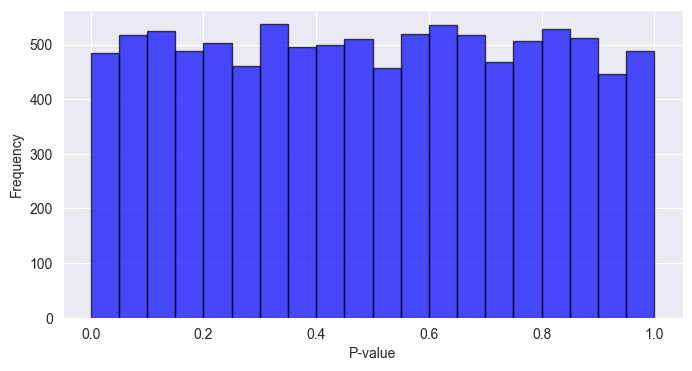

In [58]:
# histogram of p-values
plt.figure(figsize=(8, 4))
plt.hist(p_values, bins=20, edgecolor='black', color='blue', alpha=0.7)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

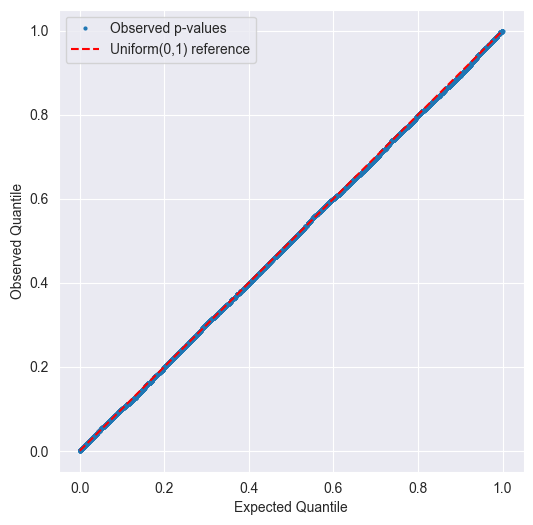

In [59]:
# QQ plot
plt.figure(figsize=(6, 6))
sorted_p = np.sort(p_values)
expected = np.linspace(0, 1, len(sorted_p))

plt.plot(expected, sorted_p, marker='o', linestyle='', markersize=2, label='Observed p-values')
plt.plot([0, 1], [0, 1], 'r--', label='Uniform(0,1) reference')
plt.xlabel('Expected Quantile')
plt.ylabel('Observed Quantile')
plt.legend()
plt.grid(True)
plt.show()

#### Questions:
* Complete loop to generate data from null and get null pvalues
* Make P value and QQ plot
* Compute lambda genetic control

In [61]:
# lambda enetic control
chi2_stats = st.chi2.ppf(1 - np.array(p_values), df=1)

lambda_gc = np.median(chi2_stats) / 0.455

print(f"Lambda genetic control = {lambda_gc:.4f}")

Lambda genetic control = 1.0091


## Simulating Data and Assessing Multiple Testing Corrections Under the Alternative Model

To investigate the behavior of our statistical tests under the alternative hypothesis, where a genetic variant has an effect on the phenotype, we'll simulate such scenarios. Further, we will apply multiple testing corrections and assess their impact.

### Steps:

1. **Loop Over Simulations**:
   - Iterate through a predefined number of simulations, e.g., 10,000 times, to generate robust results.
   
2. **Generate a Random Genetic Variant**:
   - In each loop, simulate a genetic variant.
   
3. **Simulate Phenotype Under the Alternative**:
   - Use the `simulate_phenotype` function. This time, set the `variance_genotype` to a non-zero value, representing a genuine genetic effect on the phenotype.
   
4. **Conduct Statistical Tests**:
   - Apply the `lrt_test` function on each dataset to get p-values, testing the association of the genetic variant with the phenotype.
   
5. **After getting all P values, Apply Multiple Testing Corrections**:
   
   a. **Bonferroni Correction**:
      - Adjust the p-values using Bonferroni correction.
      - Determine the number of significant tests at a given alpha, e.g., 0.05.
   
   b. **False Discovery Rate (FDR) Control**:
      - Use an FDR control method, like Benjamini-Hochberg, to adjust the p-values.
      - Identify the number of significant tests at a chosen q-value threshold, e.g., 0.05.
   
6. **Evaluate Test Power**:
   - Based on the true simulated effects and the test results, compute the power, representing the proportion of true positives out of all positives.
   
7. **Visualize Results**:
   
   a. **QQ Plots**:
      - Generate QQ plots for raw p-values and for those adjusted using each correction method.

By following these steps, we'll simulate data under the alternative hypothesis, apply multiple testing corrections, and evaluate their outcomes in the context of genetic studies.


In [62]:
# code for power analysis
alpha = 0.05

# Multiple testing corrections
rejected_bonferroni, pvals_bonferroni, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
rejected_fdr, pvals_fdr, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Number of discoveries
num_discoveries_bonferroni = sum(rejected_bonferroni)
num_discoveries_fdr = sum(rejected_fdr)

# Results
print(f"Number of significant associations using Bonferroni correction: {num_discoveries_bonferroni}/{iterations} (power = {num_discoveries_bonferroni/iterations})")
print(f"Number of significant associations using FDR control: {num_discoveries_fdr}/{iterations} (power = {num_discoveries_fdr/iterations})")

Number of significant associations using Bonferroni correction: 0/10000 (power = 0.0)
Number of significant associations using FDR control: 0/10000 (power = 0.0)


## Power Analysis

### Introduction

Power analysis allows us to determine the probability that a statistical test will detect an effect when there is an effect to be detected. In the context of genetic association studies, this means evaluating the likelihood of detecting a true association between a genetic variant and a phenotype.

### Task 1: Defining the `compute_power` Function

**Function**: `compute_power`

**Description**:  
This function simulates datasets and calculates the power of a statistical test to detect an association between a genetic variant and a phenotype. It does this by comparing the p-values obtained from the tests to a significance threshold, after adjusting for multiple testing.

**Input**:  
- `N`: Sample size (e.g., 500)
- `maf`: Minor allele frequency, which defines the frequency of the less common allele (e.g., 0.1)
- `genotype_variance`: Variance explained by the genetic variant (e.g., 0.01)
- `iterations`: Number of simulations (e.g., 1000)

**Output**:
- `power_bonferroni`: Power after adjusting p-values using the Bonferroni correction.
- `power_fdr`: Power after adjusting p-values using the False Discovery Rate (FDR) method.

### Task 2: Power Assessment

Using the `compute_power` function, you'll assess the statistical power as a function of:

1. **Sample Size**:
   - Default values to start: `N = [200, 500, 1000, 2000]`
   - Keep `maf` and `genotype_variance` constant.

2. **Allele Frequency**:
   - Default values to start: `maf = [0.05, 0.1, 0.2, 0.3]`
   - Keep `N` and `genotype_variance` constant.

3. **Genotype Variance**:
   - Default values to start: `genotype_variance = [0.005, 0.01, 0.02, 0.05]`
   - Keep `N` and `maf` constant.

For each parameter set in the above scenarios, loop through its values, use the `compute_power` function, and visualize the power using bar plots. This will allow you to see how power changes as a function of sample size, allele frequency, and genotype variance.


In [63]:
def compute_power(N, maf, genotype_variance, iterations):
    # Simulate phenotypes and genotypes for the specified number of iterations
    p_values = []
    for _ in range(iterations):
        geno_probs = [(1-maf)**2, 2*maf*(1-maf), maf**2]
        genotype = np.random.choice([0, 1, 2], size=N, p=geno_probs)
        phenotype = simulate_phenotype(genotype, variance_genotype=genotype_variance, N=N)
        covariates = np.ones((N, 1))
        _, _, pval = lrt_test(phenotype, covariates, genotype)

        p_values.append(pval)

    p_values = np.array(p_values)

    # Apply multiple testing corrections
    # Bonferroni
    rejected_bonferroni, _, _, _ = multipletests(p_values, method="bonferroni", alpha=0.05)

    # FDR
    rejected_fdr, _, _, _ = multipletests(p_values, method="fdr_bh", alpha=0.05)

    # Compute power: proportion of times null hypothesis rejected (i.e., effect detected)
    power_bonferroni = np.mean(rejected_bonferroni)
    power_fdr = np.mean(rejected_fdr)

    return power_bonferroni, power_fdr

#### Varying sample size

In [64]:
# Parameters
Ns = [200, 500, 1000, 2000]
maf = 0.1
genotype_variance = 0.05
iterations = 1000

#### Varying allele frequency

In [65]:
# Parameters
N = 500
maf_values = [0.05, 0.1, 0.2, 0.5]
genotype_variance = 0.01
iterations = 1000

#### Varying genotype variance

In [66]:
# Parameters
N = 2000
maf = 0.1
genotype_variance_values = [0.005, 0.01, 0.02, 0.05]
iterations = 1000

#### Questions:
* Complete compute_power function
* evaluate power at differnet Ns, allele frequency and genotype variance. What do you see?
* Make bar plot to visualize results

In [ ]:
Ns = [200, 500, 1000, 2000]
power_bonferroni_list = [] # fill with output from compute_power for each N
power_fdr_list = []        # fill with output from compute_power for each N

plt.figure(figsize=(7,4))
plt.bar([str(n) for n in Ns], power_bonferroni_list, width=0.4, label='Bonferroni', align='edge')
plt.bar([str(n) for n in Ns], power_fdr_list, width=-0.4, label='FDR', align='edge')
plt.ylabel("Power")
plt.xlabel("Sample Size")
plt.title("Power vs. Sample Size")
plt.legend()
plt.show()